In [1]:
import pandas as pd  
import math, random
data  = pd.read_csv("sensor_data_600.txt", delimiter=" ", 
                    header=None, names = ("date","time","ir","lidar")).sample(1000).sort_values(by="lidar").reset_index()  #.sort_values(by="lidar").reset_index() #lidarの値でソートしておく

lidar_data = pd.DataFrame(data["lidar"])

In [2]:
###負担率の初期化###

K = 3 #クラスタ数
cluster_data_num = int(math.ceil(len(lidar_data)/K)) #クラスタあたりのセンサ値の数
for k in range(K):
    tmp = [1.0 if k == int(i/cluster_data_num) else 0.0 for i,d in lidar_data.iterrows()]
    lidar_data[k] = tmp

In [3]:
lidar_data

,lidar,0,1,2
0,611,1.0,0.0,0.0
1,612,1.0,0.0,0.0
2,613,1.0,0.0,0.0
3,613,1.0,0.0,0.0
4,613,1.0,0.0,0.0
5,613,1.0,0.0,0.0
6,615,1.0,0.0,0.0
7,615,1.0,0.0,0.0
8,615,1.0,0.0,0.0
9,615,1.0,0.0,0.0


In [4]:
def init_parameters(k, min_z, max_z, K):
    step = (max_z - min_z)/K
    return pd.DataFrame({"mu_avg": step*(k + 0.5) + min_z, "zeta":1, "alpha":1, "beta":1, "tau":1}, index=[k])

In [5]:
init_params = pd.concat([init_parameters(k, lidar_data["lidar"].values[0], lidar_data["lidar"].values[-1], K) for k in range(K)])
init_params

,mu_avg,zeta,alpha,beta,tau
0,616.0,1,1,1,1
1,626.0,1,1,1,1
2,636.0,1,1,1,1


In [6]:
def RST(data, k):
    R = sum([d[k] for _, d in data.iterrows()])
    S = sum([d[k]*d["lidar"] for _, d in data.iterrows()])
    T = sum([d[k]*(d["lidar"]**2) for _, d in data.iterrows()])
    return [R, S, T]

In [7]:
def post_parameters(RST, k):
    R, S, T = RST[k]
    zeta, mu_avg = init_params["zeta"][k],  init_params["mu_avg"][k]
    alpha, beta = init_params["alpha"][k],  init_params["beta"][k]
    tau = init_params["tau"][k]

    tau_post = R + tau
    zeta_post = R + zeta
    mu_avg_post = (S + zeta*mu_avg)/zeta_post
    alpha_post = R/2 + alpha
    beta_post = (T + zeta*(mu_avg**2) - zeta_post*(mu_avg_post**2))/2 + beta
    return pd.DataFrame({"mu_avg": mu_avg_post, "zeta": zeta_post, 
                         "alpha": alpha_post, "beta": beta_post, "tau": tau_post}, index=[k])

In [8]:
def m_step():
    RSTs = [RST(lidar_data, k) for k in range(K)]
    return pd.concat([post_parameters(RSTs, k) for k in range(K)])

In [9]:
params = m_step()

In [10]:
import math
from scipy.special import digamma

def responsibility(d, K, params):
    tau_sum = sum([params["tau"][k] for k in range(K)])
    w = 0.0
    r = {}
    for k in range(K):
        zeta, mu_avg = params["zeta"][k],  params["mu_avg"][k]
        alpha, beta = params["alpha"][k],  params["beta"][k]
        tau = params["tau"][k]
        z = d["lidar"]
        
        log_rho = (digamma(alpha) - math.log(beta))/2 - (1/zeta + ((mu_avg - z)**2)*alpha/beta)/2 + digamma(tau) - digamma(tau_sum)
        r[k] = math.exp(log_rho)
        
        w += r[k]
    for k in range(K):
        r[k] /= w
    
    return r

In [11]:
def e_step(data):
    rs = [responsibility(d, K, params) for _, d in data.iterrows() ]

    for k in range(K):
        data[k] = [rs[i][k] for i,_ in data.iterrows()]
        
    return data

In [12]:
import numpy as np

def one_step(lidar_data):
    params = m_step()
    lidar_data = e_step(lidar_data)
    return params, lidar_data
    
for i in range(1000):
    params, lidar_data = one_step(lidar_data)
    params["stddev_avg"] = np.sqrt(params["beta"]/params["alpha"])
    display(params)

,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.247761,335.0,168.0,929.217910,335.0,2.351820
1,627.286567,335.0,168.0,647.244776,335.0,1.962816
2,633.501502,333.0,167.0,1024.624625,333.0,2.476989


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.449334,345.144111,173.072055,1114.123759,345.144111,2.537191
1,627.393058,316.671530,158.835765,809.954412,316.671530,2.258167
2,633.258943,341.184359,171.092180,1252.842835,341.184359,2.706034


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.449334,345.144111,173.072055,1114.123759,345.144111,2.537191
1,627.393058,316.671530,158.835765,809.954412,316.671530,2.258167
2,633.258943,341.184359,171.092180,1252.842835,341.184359,2.706034


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.556454,350.224514,175.612257,1220.059940,350.224514,2.635804
1,627.482400,308.582340,154.791170,920.748764,308.582340,2.438920
2,633.121062,344.193147,172.596573,1394.237473,344.193147,2.842185


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.556454,350.224514,175.612257,1220.059940,350.224514,2.635804
1,627.482400,308.582340,154.791170,920.748764,308.582340,2.438920
2,633.121062,344.193147,172.596573,1394.237473,344.193147,2.842185


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.628451,353.700660,177.350330,1291.672389,353.700660,2.698735
1,627.561745,303.719701,152.359851,1004.128682,303.719701,2.567198
2,633.024684,345.579638,173.289819,1494.527821,345.579638,2.936740


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.628451,353.700660,177.350330,1291.672389,353.700660,2.698735
1,627.561745,303.719701,152.359851,1004.128682,303.719701,2.567198
2,633.024684,345.579638,173.289819,1494.527821,345.579638,2.936740


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.681935,356.408951,178.704476,1344.529134,356.408951,2.742947
1,627.633629,300.341714,150.670857,1069.514933,300.341714,2.664273
2,632.950942,346.249334,173.624667,1570.622183,346.249334,3.007670


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.681935,356.408951,178.704476,1344.529134,356.408951,2.742947
1,627.633629,300.341714,150.670857,1069.514933,300.341714,2.664273
2,632.950942,346.249334,173.624667,1570.622183,346.249334,3.007670


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.724041,358.671994,179.835997,1385.784759,358.671994,2.775937
1,627.699452,297.779279,149.389639,1121.925483,297.779279,2.740449
2,632.891606,346.548727,173.774364,1630.792910,346.548727,3.063420


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.724041,358.671994,179.835997,1385.784759,358.671994,2.775937
1,627.699452,297.779279,149.389639,1121.925483,297.779279,2.740449
2,632.891606,346.548727,173.774364,1630.792910,346.548727,3.063420


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.758509,360.645521,180.822761,1419.284533,360.645521,2.801613
1,627.760174,295.717075,148.358537,1164.488913,295.717075,2.801634
2,632.842328,346.637404,173.818702,1679.739585,346.637404,3.108656


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.758509,360.645521,180.822761,1419.284533,360.645521,2.801613
1,627.760174,295.717075,148.358537,1164.488913,295.717075,2.801634
2,632.842328,346.637404,173.818702,1679.739585,346.637404,3.108656


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.787547,362.415989,181.707995,1447.314965,362.415989,2.822244
1,627.816524,293.986545,147.493273,1199.332943,293.986545,2.851568
2,632.800519,346.597465,173.798733,1720.393262,346.597465,3.146231


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.787547,362.415989,181.707995,1447.314965,362.415989,2.822244
1,627.816524,293.986545,147.493273,1199.332943,293.986545,2.851568
2,632.800519,346.597465,173.798733,1720.393262,346.597465,3.146231


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.812569,364.036282,182.518141,1471.335136,364.036282,2.839244
1,627.869082,292.489225,146.744612,1227.984469,292.489225,2.892780
2,632.764500,346.474493,173.737247,1754.702306,346.474493,3.178010


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.812569,364.036282,182.518141,1471.335136,364.036282,2.839244
1,627.869082,292.489225,146.744612,1227.984469,292.489225,2.892780
2,632.764500,346.474493,173.737247,1754.702306,346.474493,3.178010


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.834527,365.541133,183.270566,1492.325905,365.541133,2.853550
1,627.918320,291.163584,146.081792,1251.580071,291.163584,2.927058
2,632.733120,346.295283,173.647641,1784.023549,346.295283,3.205279


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.834527,365.541133,183.270566,1492.325905,365.541133,2.853550
1,627.918320,291.163584,146.081792,1251.580071,291.163584,2.927058
2,632.733120,346.295283,173.647641,1784.023549,346.295283,3.205279


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.854096,366.954614,183.977307,1510.973562,366.954614,2.865803
1,627.964628,289.969073,145.484537,1270.988886,289.969073,2.955714
2,632.705550,346.076312,173.538156,1809.336278,346.076312,3.228956


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.854096,366.954614,183.977307,1510.973562,366.954614,2.865803
1,627.964628,289.969073,145.484537,1270.988886,289.969073,2.955714
2,632.705550,346.076312,173.538156,1809.336278,346.076312,3.228956


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.871764,368.294124,184.647062,1527.773787,368.294124,2.876460
1,628.008335,288.877781,144.938890,1286.889682,288.877781,2.979739
2,632.681169,345.828095,173.414048,1831.367783,345.828095,3.249718


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.871764,368.294124,184.647062,1527.773787,368.294124,2.876460
1,628.008335,288.877781,144.938890,1286.889682,288.877781,2.979739
2,632.681169,345.828095,173.414048,1831.367783,345.828095,3.249718


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.887897,369.572655,185.286327,1543.093989,369.572655,2.885855
1,628.049718,287.869792,144.434896,1299.821718,287.869792,2.999893
2,632.659503,345.557553,173.278777,1850.671083,345.557553,3.268074


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.887897,369.572655,185.286327,1543.093989,369.572655,2.885855
1,628.049718,287.869792,144.434896,1299.821718,287.869792,2.999893
2,632.659503,345.557553,173.278777,1850.671083,345.557553,3.268074


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.902775,370.800173,185.900086,1557.212456,370.800173,2.894237
1,628.089014,286.930465,143.965232,1310.219669,286.930465,3.016777
2,632.640179,345.269362,173.134681,1867.675124,345.269362,3.284420


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.902775,370.800173,185.900086,1557.212456,370.800173,2.894237
1,628.089014,286.930465,143.965232,1310.219669,286.930465,3.016777
2,632.640179,345.269362,173.134681,1867.675124,345.269362,3.284420


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.916614,371.984490,186.492245,1570.343892,371.984490,2.901797
1,628.126426,286.048752,143.524376,1318.438297,286.048752,3.030868
2,632.622897,344.966758,172.983379,1882.718332,344.966758,3.299062


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.916614,371.984490,186.492245,1570.343892,371.984490,2.901797
1,628.126426,286.048752,143.524376,1318.438297,286.048752,3.030868
2,632.622897,344.966758,172.983379,1882.718332,344.966758,3.299062


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.929586,373.131842,187.065921,1582.656590,373.131842,2.908680
1,628.162131,285.216134,143.108067,1324.770348,285.216134,3.042554
2,632.607413,344.652024,172.826012,1896.071712,344.652024,3.312248


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.929586,373.131842,187.065921,1582.656590,373.131842,2.908680
1,628.162131,285.216134,143.108067,1324.770348,285.216134,3.042554
2,632.607413,344.652024,172.826012,1896.071712,344.652024,3.312248


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.941827,374.247280,187.623640,1594.284322,374.247280,2.915004
1,628.196282,284.425918,142.712959,1329.459754,284.425918,3.052150
2,632.593527,344.326802,172.663401,1907.955132,344.326802,3.324175


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.941827,374.247280,187.623640,1594.284322,374.247280,2.915004
1,628.196282,284.425918,142.712959,1329.459754,284.425918,3.052150
2,632.593527,344.326802,172.663401,1907.955132,344.326802,3.324175


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.953448,375.334954,188.167477,1605.334743,375.334954,2.920859
1,628.229013,283.672755,142.336377,1332.711584,283.672755,3.059920
2,632.581069,343.992291,172.496145,1918.549049,343.992291,3.335007


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.953448,375.334954,188.167477,1605.334743,375.334954,2.920859
1,628.229013,283.672755,142.336377,1332.711584,283.672755,3.059920
2,632.581069,343.992291,172.496145,1918.549049,343.992291,3.335007


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.964540,376.398308,188.699154,1615.895451,376.398308,2.926319
1,628.260443,282.952311,141.976155,1334.699618,282.952311,3.066084
2,632.569897,343.649381,172.324691,1928.003119,343.649381,3.344877


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.964540,376.398308,188.699154,1615.895451,376.398308,2.926319
1,628.260443,282.952311,141.976155,1334.699618,282.952311,3.066084
2,632.569897,343.649381,172.324691,1928.003119,343.649381,3.344877


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.975177,377.440228,189.220114,1626.038443,377.440228,2.931445
1,628.290675,282.261029,141.630515,1335.572211,282.261029,3.070826
2,632.559890,343.298743,172.149371,1936.442618,343.298743,3.353896


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.975177,377.440228,189.220114,1626.038443,377.440228,2.931445
1,628.290675,282.261029,141.630515,1335.572211,282.261029,3.070826
2,632.559890,343.298743,172.149371,1936.442618,343.298743,3.353896


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.985422,378.463157,189.731579,1635.823430,378.463157,2.936286
1,628.319802,281.595957,141.297979,1335.456878,281.595957,3.074305
2,632.550943,342.940886,171.970443,1943.973308,342.940886,3.362159


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.985422,378.463157,189.731579,1635.823430,378.463157,2.936286
1,628.319802,281.595957,141.297979,1335.456878,281.595957,3.074305
2,632.550943,342.940886,171.970443,1943.973308,342.940886,3.362159


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.995327,379.469175,190.234588,1645.300340,379.469175,2.940884
1,628.347907,280.954620,140.977310,1334.463915,280.954620,3.076655
2,632.542965,342.576204,171.788102,1950.685163,342.576204,3.369745


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,620.995327,379.469175,190.234588,1645.300340,379.469175,2.940884
1,628.347907,280.954620,140.977310,1334.463915,280.954620,3.076655
2,632.542965,342.576204,171.788102,1950.685163,342.576204,3.369745


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.004935,380.460066,190.730033,1654.511239,380.460066,2.945271
1,628.375063,280.334926,140.667463,1332.689283,280.334926,3.077993
2,632.535877,342.205008,171.602504,1956.655277,342.205008,3.376722


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.004935,380.460066,190.730033,1654.511239,380.460066,2.945271
1,628.375063,280.334926,140.667463,1332.689283,280.334926,3.077993
2,632.535877,342.205008,171.602504,1956.655277,342.205008,3.376722


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.014285,381.437367,191.218684,1663.491829,381.437367,2.949478
1,628.401336,279.735092,140.367546,1330.216937,279.735092,3.078420
2,632.529609,341.827541,171.413770,1961.950130,341.827541,3.383149


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.014285,381.437367,191.218684,1663.491829,381.437367,2.949478
1,628.401336,279.735092,140.367546,1330.216937,279.735092,3.078420
2,632.529609,341.827541,171.413770,1961.950130,341.827541,3.383149


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.023408,382.402414,191.701207,1672.272579,382.402414,2.953528
1,628.426786,279.153587,140.076794,1327.120705,279.153587,3.078025
2,632.524101,341.443999,171.221999,1966.627397,341.443999,3.389076


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.023408,382.402414,191.701207,1672.272579,382.402414,2.953528
1,628.426786,279.153587,140.076794,1327.120705,279.153587,3.078025
2,632.524101,341.443999,171.221999,1966.627397,341.443999,3.389076


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.032332,383.356367,192.178184,1680.879673,383.356367,2.957442
1,628.451466,278.589091,139.794546,1323.465824,278.589091,3.076885
2,632.519296,341.054542,171.027271,1970.737410,341.054542,3.394546


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.032332,383.356367,192.178184,1680.879673,383.356367,2.957442
1,628.451466,278.589091,139.794546,1323.465824,278.589091,3.076885
2,632.519296,341.054542,171.027271,1970.737410,341.054542,3.394546


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.041080,384.300241,192.650121,1689.335711,384.300241,2.961238
1,628.475426,278.040456,139.520228,1319.310218,278.040456,3.075069
2,632.515148,340.659303,170.829651,1974.324304,340.659303,3.399598


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.041080,384.300241,192.650121,1689.335711,384.300241,2.961238
1,628.475426,278.040456,139.520228,1319.310218,278.040456,3.075069
2,632.515148,340.659303,170.829651,1974.324304,340.659303,3.399598


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.049673,385.234927,193.117463,1697.660305,385.234927,2.964931
1,628.498708,277.506681,139.253341,1314.705520,277.506681,3.072638
2,632.511611,340.258392,170.629196,1977.426987,340.258392,3.404267


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.049673,385.234927,193.117463,1697.660305,385.234927,2.964931
1,628.498708,277.506681,139.253341,1314.705520,277.506681,3.072638
2,632.511611,340.258392,170.629196,1977.426987,340.258392,3.404267


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.058130,386.161205,193.580602,1705.870544,386.161205,2.968535
1,628.521355,276.986890,138.993445,1309.697958,276.986890,3.069647
2,632.508647,339.851906,170.425953,1980.079914,339.851906,3.408580


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.058130,386.161205,193.580602,1705.870544,386.161205,2.968535
1,628.521355,276.986890,138.993445,1309.697958,276.986890,3.069647
2,632.508647,339.851906,170.425953,1980.079914,339.851906,3.408580


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.066465,387.079765,194.039882,1713.981381,387.079765,2.972060
1,628.543402,276.480310,138.740155,1304.329081,276.480310,3.066144
2,632.506220,339.439925,170.219962,1982.313732,339.439925,3.412565


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.066465,387.079765,194.039882,1713.981381,387.079765,2.972060
1,628.543402,276.480310,138.740155,1304.329081,276.480310,3.066144
2,632.506220,339.439925,170.219962,1982.313732,339.439925,3.412565


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.074693,387.991214,194.495607,1722.005952,387.991214,2.975517
1,628.564883,275.986263,138.493131,1298.636367,275.986263,3.062173
2,632.504298,339.022524,170.011262,1984.155823,339.022524,3.416245


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.074693,387.991214,194.495607,1722.005952,387.991214,2.975517
1,628.564883,275.986263,138.493131,1298.636367,275.986263,3.062173
2,632.504298,339.022524,170.011262,1984.155823,339.022524,3.416245


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.082825,388.896087,194.948043,1729.955812,388.896087,2.978915
1,628.585828,275.504145,138.252072,1292.653740,275.504145,3.057773
2,632.502851,338.599768,169.799884,1985.630744,338.599768,3.419641


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.082825,388.896087,194.948043,1729.955812,388.896087,2.978915
1,628.585828,275.504145,138.252072,1292.653740,275.504145,3.057773
2,632.502851,338.599768,169.799884,1985.630744,338.599768,3.419641


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.090872,389.794858,195.397429,1737.841172,389.794858,2.982261
1,628.606267,275.033422,138.016711,1286.412007,275.033422,3.052982
2,632.501852,338.171720,169.585860,1986.760616,338.171720,3.422772


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.090872,389.794858,195.397429,1737.841172,389.794858,2.982261
1,628.606267,275.033422,138.016711,1286.412007,275.033422,3.052982
2,632.501852,338.171720,169.585860,1986.760616,338.171720,3.422772


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.098843,390.687942,195.843971,1745.671071,390.687942,2.985562
1,628.626225,274.573622,137.786811,1279.939237,274.573622,3.047831
2,632.501276,337.738436,169.369218,1987.565431,337.738436,3.425654


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.098843,390.687942,195.843971,1745.671071,390.687942,2.985562
1,628.626225,274.573622,137.786811,1279.939237,274.573622,3.047831
2,632.501276,337.738436,169.369218,1987.565431,337.738436,3.425654


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.106747,391.575708,196.287854,1753.453510,391.575708,2.988824
1,628.645725,274.124321,137.562161,1273.261072,274.124321,3.042350
2,632.501101,337.299971,169.149985,1988.063334,337.299971,3.428302


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.106747,391.575708,196.287854,1753.453510,391.575708,2.988824
1,628.645725,274.124321,137.562161,1273.261072,274.124321,3.042350
2,632.501101,337.299971,169.149985,1988.063334,337.299971,3.428302


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.114591,392.458478,196.729239,1761.195595,392.458478,2.992053
1,628.664791,273.685145,137.342572,1266.401009,273.685145,3.036568
2,632.501306,336.856377,168.928188,1988.270849,336.856377,3.430731


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.114591,392.458478,196.729239,1761.195595,392.458478,2.992053
1,628.664791,273.685145,137.342572,1266.401009,273.685145,3.036568
2,632.501306,336.856377,168.928188,1988.270849,336.856377,3.430731


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.122381,393.336534,197.168267,1768.903624,393.336534,2.995253
1,628.683443,273.255759,137.127880,1259.380628,273.255759,3.030509
2,632.501871,336.407707,168.703854,1988.203079,336.407707,3.432953


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.122381,393.336534,197.168267,1768.903624,393.336534,2.995253
1,628.683443,273.255759,137.127880,1259.380628,273.255759,3.030509
2,632.501871,336.407707,168.703854,1988.203079,336.407707,3.432953


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.130122,394.210121,197.605061,1776.583195,394.210121,2.998429
1,628.701699,272.835866,136.917933,1252.219799,272.835866,3.024197
2,632.502779,335.954013,168.477006,1987.873874,335.954013,3.434979


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.130122,394.210121,197.605061,1776.583195,394.210121,2.998429
1,628.701699,272.835866,136.917933,1252.219799,272.835866,3.024197
2,632.502779,335.954013,168.477006,1987.873874,335.954013,3.434979


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.137821,395.079454,198.039727,1784.239276,395.079454,3.001583
1,628.719578,272.425201,136.712601,1244.936863,272.425201,3.017654
2,632.504012,335.495345,168.247672,1987.295987,335.495345,3.436820


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.137821,395.079454,198.039727,1784.239276,395.079454,3.001583
1,628.719578,272.425201,136.712601,1244.936863,272.425201,3.017654
2,632.504012,335.495345,168.247672,1987.295987,335.495345,3.436820


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.145480,395.944716,198.472358,1791.876262,395.944716,3.004720
1,628.737095,272.023529,136.511764,1237.548781,272.023529,3.010899
2,632.505554,335.031756,168.015878,1986.481191,335.031756,3.438484


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.145480,395.944716,198.472358,1791.876262,395.944716,3.004720
1,628.737095,272.023529,136.511764,1237.548781,272.023529,3.010899
2,632.505554,335.031756,168.015878,1986.481191,335.031756,3.438484


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.153104,396.806062,198.903031,1799.498039,396.806062,3.007842
1,628.754267,271.630640,136.315320,1230.071268,271.630640,3.003951
2,632.507392,334.563298,167.781649,1985.440394,334.563298,3.439982


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.153104,396.806062,198.903031,1799.498039,396.806062,3.007842
1,628.754267,271.630640,136.315320,1230.071268,271.630640,3.003951
2,632.507392,334.563298,167.781649,1985.440394,334.563298,3.439982


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.160696,397.663625,199.331812,1807.108022,397.663625,3.010951
1,628.771107,271.246351,136.123175,1222.518911,271.246351,2.996828
2,632.509511,334.090025,167.545012,1984.183736,334.090025,3.441321


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.160696,397.663625,199.331812,1807.108022,397.663625,3.010951
1,628.771107,271.246351,136.123175,1222.518911,271.246351,2.996828
2,632.509511,334.090025,167.545012,1984.183736,334.090025,3.441321


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.168259,398.517512,199.758756,1814.709224,398.517512,3.014051
1,628.787628,270.870497,135.935249,1214.905270,270.870497,2.989545
2,632.511898,333.611991,167.305995,1982.720677,333.611991,3.442508


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.168259,398.517512,199.758756,1814.709224,398.517512,3.014051
1,628.787628,270.870497,135.935249,1214.905270,270.870497,2.989545
2,632.511898,333.611991,167.305995,1982.720677,333.611991,3.442508


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.175796,399.367812,200.183906,1822.304257,399.367812,3.017143
1,628.803843,270.502937,135.751468,1207.242973,270.502937,2.982120
2,632.514541,333.129251,167.064626,1981.060059,333.129251,3.443551


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.175796,399.367812,200.183906,1822.304257,399.367812,3.017143
1,628.803843,270.502937,135.751468,1207.242973,270.502937,2.982120
2,632.514541,333.129251,167.064626,1981.060059,333.129251,3.443551


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.183308,400.214591,200.607296,1829.895393,400.214591,3.020228
1,628.819763,270.143544,135.571772,1199.543788,270.143544,2.974565
2,632.517428,332.641864,166.820932,1979.210186,332.641864,3.444456


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.183308,400.214591,200.607296,1829.895393,400.214591,3.020228
1,628.819763,270.143544,135.571772,1199.543788,270.143544,2.974565
2,632.517428,332.641864,166.820932,1979.210186,332.641864,3.444456


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.190798,401.057902,201.028951,1837.484569,401.057902,3.023309
1,628.835400,269.792211,135.396105,1191.818702,269.792211,2.966894
2,632.520550,332.149887,166.574944,1977.178866,332.149887,3.445229


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.190798,401.057902,201.028951,1837.484569,401.057902,3.023309
1,628.835400,269.792211,135.396105,1191.818702,269.792211,2.966894
2,632.520550,332.149887,166.574944,1977.178866,332.149887,3.445229


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.198266,401.897778,201.448889,1845.073426,401.897778,3.026386
1,628.850763,269.448842,135.224421,1184.077975,269.448842,2.959120
2,632.523894,331.653380,166.326690,1974.973469,331.653380,3.445876


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.198266,401.897778,201.448889,1845.073426,401.897778,3.026386
1,628.850763,269.448842,135.224421,1184.077975,269.448842,2.959120
2,632.523894,331.653380,166.326690,1974.973469,331.653380,3.445876


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.205714,402.734238,201.867119,1852.663340,402.734238,3.029462
1,628.865861,269.113359,135.056679,1176.331198,269.113359,2.951255
2,632.527452,331.152404,166.076202,1972.600972,331.152404,3.446402


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.205714,402.734238,201.867119,1852.663340,402.734238,3.029462
1,628.865861,269.113359,135.056679,1176.331198,269.113359,2.951255
2,632.527452,331.152404,166.076202,1972.600972,331.152404,3.446402


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.213143,403.567287,202.283643,1860.255422,403.567287,3.032536
1,628.880705,268.785693,134.892846,1168.587347,268.785693,2.943311
2,632.531214,330.647021,165.823510,1970.067992,330.647021,3.446812


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.213143,403.567287,202.283643,1860.255422,403.567287,3.032536
1,628.880705,268.785693,134.892846,1168.587347,268.785693,2.943311
2,632.531214,330.647021,165.823510,1970.067992,330.647021,3.446812


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.220554,404.396917,202.698459,1867.850546,404.396917,3.035609
1,628.895301,268.465788,134.732894,1160.854819,268.465788,2.935298
2,632.535172,330.137294,165.568647,1967.380820,330.137294,3.447110


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.220554,404.396917,202.698459,1867.850546,404.396917,3.035609
1,628.895301,268.465788,134.732894,1160.854819,268.465788,2.935298
2,632.535172,330.137294,165.568647,1967.380820,330.137294,3.447110


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.227947,405.22311,203.111555,1875.449360,405.22311,3.038683
1,628.909658,268.15360,134.576800,1153.141472,268.15360,2.927226
2,632.539316,329.62329,165.311645,1964.545455,329.62329,3.447302


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.227947,405.22311,203.111555,1875.449360,405.22311,3.038683
1,628.909658,268.15360,134.576800,1153.141472,268.15360,2.927226
2,632.539316,329.62329,165.311645,1964.545455,329.62329,3.447302


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.235322,406.045835,203.522917,1883.052319,406.045835,3.041757
1,628.923784,267.849091,134.424546,1145.454668,267.849091,2.919105
2,632.543640,329.105074,165.052537,1961.567631,329.105074,3.447391


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.235322,406.045835,203.522917,1883.052319,406.045835,3.041757
1,628.923784,267.849091,134.424546,1145.454668,267.849091,2.919105
2,632.543640,329.105074,165.052537,1961.567631,329.105074,3.447391


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.242679,406.865051,203.932526,1890.659671,406.865051,3.044833
1,628.937684,267.552235,134.276117,1137.801294,267.552235,2.910944
2,632.548134,328.582714,164.791357,1958.452833,328.582714,3.447381


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.242679,406.865051,203.932526,1890.659671,406.865051,3.044833
1,628.937684,267.552235,134.276117,1137.801294,267.552235,2.910944
2,632.548134,328.582714,164.791357,1958.452833,328.582714,3.447381


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.250019,407.680710,204.340355,1898.271494,407.680710,3.047910
1,628.951367,267.263012,134.131506,1130.187802,267.263012,2.902752
2,632.552792,328.056278,164.528139,1955.206322,328.056278,3.447277


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.250019,407.680710,204.340355,1898.271494,407.680710,3.047910
1,628.951367,267.263012,134.131506,1130.187802,267.263012,2.902752
2,632.552792,328.056278,164.528139,1955.206322,328.056278,3.447277


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.257341,408.492755,204.746377,1905.887691,408.492755,3.050988
1,628.964837,266.981410,133.990705,1122.620222,266.981410,2.894537
2,632.557606,327.525835,164.262917,1951.833155,327.525835,3.447082


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.257341,408.492755,204.746377,1905.887691,408.492755,3.050988
1,628.964837,266.981410,133.990705,1122.620222,266.981410,2.894537
2,632.557606,327.525835,164.262917,1951.833155,327.525835,3.447082


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.264645,409.301119,205.150560,1913.508013,409.301119,3.054069
1,628.978101,266.707424,133.853712,1115.104195,266.707424,2.886307
2,632.562570,326.991456,163.995728,1948.338198,326.991456,3.446799


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.264645,409.301119,205.150560,1913.508013,409.301119,3.054069
1,628.978101,266.707424,133.853712,1115.104195,266.707424,2.886307
2,632.562570,326.991456,163.995728,1948.338198,326.991456,3.446799


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.271930,410.105733,205.552867,1921.132055,410.105733,3.057151
1,628.991164,266.441054,133.720527,1107.644993,266.441054,2.878069
2,632.567678,326.453213,163.726606,1944.726135,326.453213,3.446431


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.271930,410.105733,205.552867,1921.132055,410.105733,3.057151
1,628.991164,266.441054,133.720527,1107.644993,266.441054,2.878069
2,632.567678,326.453213,163.726606,1944.726135,326.453213,3.446431


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.279196,410.906518,205.953259,1928.759287,410.906518,3.060234
1,629.004032,266.182305,133.591153,1100.247532,266.182305,2.869831
2,632.572922,325.911177,163.455589,1941.001493,325.911177,3.445982


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.279196,410.906518,205.953259,1928.759287,410.906518,3.060234
1,629.004032,266.182305,133.591153,1100.247532,266.182305,2.869831
2,632.572922,325.911177,163.455589,1941.001493,325.911177,3.445982


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.286442,411.703390,206.351695,1936.389046,411.703390,3.063319
1,629.016709,265.931188,133.465594,1092.916402,265.931188,2.861599
2,632.578298,325.365421,163.182711,1937.168639,325.365421,3.445455


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.286442,411.703390,206.351695,1936.389046,411.703390,3.063319
1,629.016709,265.931188,133.465594,1092.916402,265.931188,2.861599
2,632.578298,325.365421,163.182711,1937.168639,325.365421,3.445455


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.293668,412.496263,206.748132,1944.020545,412.496263,3.066406
1,629.029199,265.687718,133.343859,1085.655870,265.687718,2.853380
2,632.583799,324.816019,162.908009,1933.231798,324.816019,3.444853


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.293668,412.496263,206.748132,1944.020545,412.496263,3.066406
1,629.029199,265.687718,133.343859,1085.655870,265.687718,2.853380
2,632.583799,324.816019,162.908009,1933.231798,324.816019,3.444853


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.300872,413.285044,207.142522,1951.652893,413.285044,3.069493
1,629.041508,265.451912,133.225956,1078.469906,265.451912,2.845179
2,632.589420,324.263044,162.631522,1929.195054,324.263044,3.444179


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.300872,413.285044,207.142522,1951.652893,413.285044,3.069493
1,629.041508,265.451912,133.225956,1078.469906,265.451912,2.845179
2,632.589420,324.263044,162.631522,1929.195054,324.263044,3.444179


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.308053,414.069638,207.534819,1959.285089,414.069638,3.072581
1,629.053639,265.223793,133.111896,1071.362192,265.223793,2.837003
2,632.595155,323.706569,162.353285,1925.062369,323.706569,3.443435


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.308053,414.069638,207.534819,1959.285089,414.069638,3.072581
1,629.053639,265.223793,133.111896,1071.362192,265.223793,2.837003
2,632.595155,323.706569,162.353285,1925.062369,323.706569,3.443435


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.315211,414.849946,207.924973,1966.916053,414.849946,3.075669
1,629.065596,265.003383,133.001692,1064.336137,265.003383,2.828856
2,632.601000,323.146671,162.073335,1920.837573,323.146671,3.442624


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.315211,414.849946,207.924973,1966.916053,414.849946,3.075669
1,629.065596,265.003383,133.001692,1064.336137,265.003383,2.828856
2,632.601000,323.146671,162.073335,1920.837573,323.146671,3.442624


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.322344,415.625867,208.312933,1974.544601,415.625867,3.078757
1,629.077383,264.790711,132.895356,1057.394892,264.790711,2.820744
2,632.606949,322.583422,161.791711,1916.524382,322.583422,3.441748


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.322344,415.625867,208.312933,1974.544601,415.625867,3.078757
1,629.077383,264.790711,132.895356,1057.394892,264.790711,2.820744
2,632.606949,322.583422,161.791711,1916.524382,322.583422,3.441748


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.329451,416.397298,208.698649,1982.169476,416.397298,3.081843
1,629.089004,264.585804,132.792902,1050.541349,264.585804,2.812672
2,632.612998,322.016898,161.508449,1912.126401,322.016898,3.440810


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.329451,416.397298,208.698649,1982.169476,416.397298,3.081843
1,629.089004,264.585804,132.792902,1050.541349,264.585804,2.812672
2,632.612998,322.016898,161.508449,1912.126401,322.016898,3.440810


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.336532,417.164135,209.082068,1989.789348,417.164135,3.084929
1,629.100461,264.388692,132.694346,1043.778175,264.388692,2.804645
2,632.619143,321.447173,161.223586,1907.647122,321.447173,3.439812


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.336532,417.164135,209.082068,1989.789348,417.164135,3.084929
1,629.100461,264.388692,132.694346,1043.778175,264.388692,2.804645
2,632.619143,321.447173,161.223586,1907.647122,321.447173,3.439812


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.343584,417.926273,209.463136,1997.402823,417.926273,3.088012
1,629.111759,264.199407,132.599703,1037.107804,264.199407,2.796666
2,632.625378,320.874321,160.937160,1903.089931,320.874321,3.438757


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.343584,417.926273,209.463136,1997.402823,417.926273,3.088012
1,629.111759,264.199407,132.599703,1037.107804,264.199407,2.796666
2,632.625378,320.874321,160.937160,1903.089931,320.874321,3.438757


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.350607,418.683604,209.841802,2005.008442,418.683604,3.091093
1,629.122899,264.017980,132.508990,1030.532452,264.017980,2.788741
2,632.631700,320.298416,160.649208,1898.458113,320.298416,3.437647


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.350607,418.683604,209.841802,2005.008442,418.683604,3.091093
1,629.122899,264.017980,132.508990,1030.532452,264.017980,2.788741
2,632.631700,320.298416,160.649208,1898.458113,320.298416,3.437647


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.357600,419.436024,210.218012,2012.604700,419.436024,3.094171
1,629.133885,263.844443,132.422222,1024.054129,263.844443,2.780872
2,632.638105,319.719533,160.359766,1893.754855,319.719533,3.436483


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.357600,419.436024,210.218012,2012.604700,419.436024,3.094171
1,629.133885,263.844443,132.422222,1024.054129,263.844443,2.780872
2,632.638105,319.719533,160.359766,1893.754855,319.719533,3.436483


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.364560,420.183426,210.591713,2020.190040,420.183426,3.097244
1,629.144719,263.678831,132.339415,1017.674646,263.678831,2.773064
2,632.644588,319.137743,160.068872,1888.983243,319.137743,3.435268


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.364560,420.183426,210.591713,2020.190040,420.183426,3.097244
1,629.144719,263.678831,132.339415,1017.674646,263.678831,2.773064
2,632.644588,319.137743,160.068872,1888.983243,319.137743,3.435268


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.371488,420.925705,210.962852,2027.762868,420.925705,3.100313
1,629.155405,263.521173,132.260587,1011.395625,263.521173,2.765319
2,632.651147,318.553122,159.776561,1884.146270,318.553122,3.434004


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.371488,420.925705,210.962852,2027.762868,420.925705,3.100313
1,629.155405,263.521173,132.260587,1011.395625,263.521173,2.765319
2,632.651147,318.553122,159.776561,1884.146270,318.553122,3.434004


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.378381,421.662757,211.331378,2035.321553,421.662757,3.103377
1,629.165944,263.371504,132.185752,1005.218506,263.371504,2.757642
2,632.657778,317.965739,159.482870,1879.246837,317.965739,3.432692


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.378381,421.662757,211.331378,2035.321553,421.662757,3.103377
1,629.165944,263.371504,132.185752,1005.218506,263.371504,2.757642
2,632.657778,317.965739,159.482870,1879.246837,317.965739,3.432692


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.385238,422.394478,211.697239,2042.864442,422.394478,3.106434
1,629.176340,263.229855,132.114927,999.144559,263.229855,2.750035
2,632.664477,317.375668,159.187834,1874.287752,317.375668,3.431336


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.385238,422.394478,211.697239,2042.864442,422.394478,3.106434
1,629.176340,263.229855,132.114927,999.144559,263.229855,2.750035
2,632.664477,317.375668,159.187834,1874.287752,317.375668,3.431336


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.392058,423.120767,212.060384,2050.389850,423.120767,3.109485
1,629.186593,263.096255,132.048128,993.174886,263.096255,2.742501
2,632.671241,316.782978,158.891489,1869.271735,316.782978,3.429935


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.392058,423.120767,212.060384,2050.389850,423.120767,3.109485
1,629.186593,263.096255,132.048128,993.174886,263.096255,2.742501
2,632.671241,316.782978,158.891489,1869.271735,316.782978,3.429935


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.398839,423.841525,212.420763,2057.896068,423.841525,3.112528
1,629.196707,262.970735,131.985368,987.310435,262.970735,2.735042
2,632.678066,316.187739,158.593870,1864.201412,316.187739,3.428493


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.398839,423.841525,212.420763,2057.896068,423.841525,3.112528
1,629.196707,262.970735,131.985368,987.310435,262.970735,2.735042
2,632.678066,316.187739,158.593870,1864.201412,316.187739,3.428493


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.405581,424.556655,212.778328,2065.381398,424.556655,3.115562
1,629.206683,262.853324,131.926662,981.552001,262.853324,2.727661
2,632.684951,315.590021,158.295011,1859.079332,315.590021,3.427010


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.405581,424.556655,212.778328,2065.381398,424.556655,3.115562
1,629.206683,262.853324,131.926662,981.552001,262.853324,2.727661
2,632.684951,315.590021,158.295011,1859.079332,315.590021,3.427010


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.412282,425.266062,213.133031,2072.844109,425.266062,3.118588
1,629.216524,262.744047,131.872023,975.900238,262.744047,2.720360
2,632.691892,314.989891,157.994946,1853.907953,314.989891,3.425488


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.412282,425.266062,213.133031,2072.844109,425.266062,3.118588
1,629.216524,262.744047,131.872023,975.900238,262.744047,2.720360
2,632.691892,314.989891,157.994946,1853.907953,314.989891,3.425488


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.418940,425.969654,213.484827,2080.282482,425.969654,3.121603
1,629.226231,262.642929,131.821465,970.355667,262.642929,2.713141
2,632.698887,314.387417,157.693709,1848.689648,314.387417,3.423930


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.418940,425.969654,213.484827,2080.282482,425.969654,3.121603
1,629.226231,262.642929,131.821465,970.355667,262.642929,2.713141
2,632.698887,314.387417,157.693709,1848.689648,314.387417,3.423930


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.425555,426.667341,213.833670,2087.694794,426.667341,3.124607
1,629.235807,262.549996,131.774998,964.918674,262.549996,2.706007
2,632.705932,313.782664,157.391332,1843.426712,313.782664,3.422335


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.425555,426.667341,213.833670,2087.694794,426.667341,3.124607
1,629.235807,262.549996,131.774998,964.918674,262.549996,2.706007
2,632.705932,313.782664,157.391332,1843.426712,313.782664,3.422335


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.432125,427.359038,214.179519,2095.079327,427.359038,3.127600
1,629.245252,262.465267,131.732633,959.589529,262.465267,2.698958
2,632.713026,313.175696,157.087848,1838.121353,313.175696,3.420706


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.432125,427.359038,214.179519,2095.079327,427.359038,3.127600
1,629.245252,262.465267,131.732633,959.589529,262.465267,2.698958
2,632.713026,313.175696,157.087848,1838.121353,313.175696,3.420706


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.438650,428.044661,214.522331,2102.434375,428.044661,3.130581
1,629.254570,262.388762,131.694381,954.368386,262.388762,2.691996
2,632.720165,312.566577,156.783289,1832.775704,312.566577,3.419045


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.438650,428.044661,214.522331,2102.434375,428.044661,3.130581
1,629.254570,262.388762,131.694381,954.368386,262.388762,2.691996
2,632.720165,312.566577,156.783289,1832.775704,312.566577,3.419045


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.445127,428.724132,214.862066,2109.758242,428.724132,3.133549
1,629.263760,262.320498,131.660249,949.255283,262.320498,2.685123
2,632.727349,311.955369,156.477685,1827.391818,311.955369,3.417351


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.445127,428.724132,214.862066,2109.758242,428.724132,3.133549
1,629.263760,262.320498,131.660249,949.255283,262.320498,2.685123
2,632.727349,311.955369,156.477685,1827.391818,311.955369,3.417351


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.451556,429.397375,215.198688,2117.049254,429.397375,3.136503
1,629.272826,262.260492,131.630246,944.250163,262.260492,2.678340
2,632.734574,311.342133,156.171066,1821.971669,311.342133,3.415628


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.451556,429.397375,215.198688,2117.049254,429.397375,3.136503
1,629.272826,262.260492,131.630246,944.250163,262.260492,2.678340
2,632.734574,311.342133,156.171066,1821.971669,311.342133,3.415628


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.457936,430.064318,215.532159,2124.305756,430.064318,3.139442
1,629.281769,262.208754,131.604377,939.352865,262.208754,2.671648
2,632.741839,310.726927,155.863464,1816.517159,310.726927,3.413875


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.457936,430.064318,215.532159,2124.305756,430.064318,3.139442
1,629.281769,262.208754,131.604377,939.352865,262.208754,2.671648
2,632.741839,310.726927,155.863464,1816.517159,310.726927,3.413875


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.464266,430.724892,215.862446,2131.526120,430.724892,3.142366
1,629.290590,262.165297,131.582648,934.563139,262.165297,2.665048
2,632.749142,310.109811,155.554905,1811.030112,310.109811,3.412094


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.464266,430.724892,215.862446,2131.526120,430.724892,3.142366
1,629.290590,262.165297,131.582648,934.563139,262.165297,2.665048
2,632.749142,310.109811,155.554905,1811.030112,310.109811,3.412094


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.470544,431.379034,216.189517,2138.708745,431.379034,3.145274
1,629.299290,262.130127,131.565063,929.880649,262.130127,2.658541
2,632.756481,309.490839,155.245420,1805.512280,309.490839,3.410286


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.470544,431.379034,216.189517,2138.708745,431.379034,3.145274
1,629.299290,262.130127,131.565063,929.880649,262.130127,2.658541
2,632.756481,309.490839,155.245420,1805.512280,309.490839,3.410286


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.476770,432.026682,216.513341,2145.852059,432.026682,3.148166
1,629.307872,262.103250,131.551625,925.304973,262.103250,2.652127
2,632.763854,308.870068,154.935034,1799.965345,308.870068,3.408453


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.476770,432.026682,216.513341,2145.852059,432.026682,3.148166
1,629.307872,262.103250,131.551625,925.304973,262.103250,2.652127
2,632.763854,308.870068,154.935034,1799.965345,308.870068,3.408453


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.482943,432.667782,216.833891,2152.954521,432.667782,3.151039
1,629.316336,262.084669,131.542334,920.835618,262.084669,2.645808
2,632.771260,308.247549,154.623775,1794.390917,308.247549,3.406594


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.482943,432.667782,216.833891,2152.954521,432.667782,3.151039
1,629.316336,262.084669,131.542334,920.835618,262.084669,2.645808
2,632.771260,308.247549,154.623775,1794.390917,308.247549,3.406594


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.489061,433.302280,217.151140,2160.014628,433.302280,3.153895
1,629.324685,262.074384,131.537192,916.472016,262.074384,2.639583
2,632.778697,307.623336,154.311668,1788.790541,307.623336,3.404712


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.489061,433.302280,217.151140,2160.014628,433.302280,3.153895
1,629.324685,262.074384,131.537192,916.472016,262.074384,2.639583
2,632.778697,307.623336,154.311668,1788.790541,307.623336,3.404712


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.495125,433.930128,217.465064,2167.030916,433.930128,3.156733
1,629.332919,262.072393,131.536197,912.213537,262.072393,2.633453
2,632.786164,306.997478,153.998739,1783.165692,306.997478,3.402807


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.495125,433.930128,217.465064,2167.030916,433.930128,3.156733
1,629.332919,262.072393,131.536197,912.213537,262.072393,2.633453
2,632.786164,306.997478,153.998739,1783.165692,306.997478,3.402807


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.501132,434.551284,217.775642,2174.001967,434.551284,3.159551
1,629.341040,262.078692,131.539346,908.059484,262.078692,2.627419
2,632.793659,306.370024,153.685012,1777.517782,306.370024,3.400879


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.501132,434.551284,217.775642,2174.001967,434.551284,3.159551
1,629.341040,262.078692,131.539346,908.059484,262.078692,2.627419
2,632.793659,306.370024,153.685012,1777.517782,306.370024,3.400879


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.507084,435.165706,218.082853,2180.926400,435.165706,3.162349
1,629.349049,262.093273,131.546637,904.009108,262.093273,2.621480
2,632.801181,305.741020,153.370510,1771.848159,305.741020,3.398931


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.507084,435.165706,218.082853,2180.926400,435.165706,3.162349
1,629.349049,262.093273,131.546637,904.009108,262.093273,2.621480
2,632.801181,305.741020,153.370510,1771.848159,305.741020,3.398931


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.512977,435.773361,218.386680,2187.802874,435.773361,3.165126
1,629.356947,262.116126,131.558063,900.061601,262.116126,2.615636
2,632.808729,305.110513,153.055257,1766.158110,305.110513,3.396962


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.512977,435.773361,218.386680,2187.802874,435.773361,3.165126
1,629.356947,262.116126,131.558063,900.061601,262.116126,2.615636
2,632.808729,305.110513,153.055257,1766.158110,305.110513,3.396962


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.518813,436.374216,218.687108,2194.630098,436.374216,3.167883
1,629.364737,262.147239,131.573620,896.216109,262.147239,2.609889
2,632.816303,304.478545,152.739273,1760.448861,304.478545,3.394973


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.518813,436.374216,218.687108,2194.630098,436.374216,3.167883
1,629.364737,262.147239,131.573620,896.216109,262.147239,2.609889
2,632.816303,304.478545,152.739273,1760.448861,304.478545,3.394973


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.524591,436.968244,218.984122,2201.406835,436.968244,3.170617
1,629.372418,262.186597,131.593299,892.471732,262.186597,2.604236
2,632.823900,303.845159,152.422580,1754.721579,303.845159,3.392966


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.524591,436.968244,218.984122,2201.406835,436.968244,3.170617
1,629.372418,262.186597,131.593299,892.471732,262.186597,2.604236
2,632.823900,303.845159,152.422580,1754.721579,303.845159,3.392966


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.530309,437.555422,219.277711,2208.131883,437.555422,3.173330
1,629.379993,262.234183,131.617092,888.827530,262.234183,2.598679
2,632.831520,303.210395,152.105197,1748.977377,303.210395,3.390940


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.530309,437.555422,219.277711,2208.131883,437.555422,3.173330
1,629.379993,262.234183,131.617092,888.827530,262.234183,2.598679
2,632.831520,303.210395,152.105197,1748.977377,303.210395,3.390940


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.535967,438.135732,219.567866,2214.804094,438.135732,3.176020
1,629.387463,262.289977,131.644989,885.282524,262.289977,2.593217
2,632.839162,302.574291,151.787146,1743.217311,302.574291,3.388896


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.535967,438.135732,219.567866,2214.804094,438.135732,3.176020
1,629.387463,262.289977,131.644989,885.282524,262.289977,2.593217
2,632.839162,302.574291,151.787146,1743.217311,302.574291,3.388896


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.541566,438.709157,219.854579,2221.422375,438.709157,3.178687
1,629.394830,262.353958,131.676979,881.835699,262.353958,2.587849
2,632.846825,301.936885,151.468442,1737.442387,301.936885,3.386836


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.541566,438.709157,219.854579,2221.422375,438.709157,3.178687
1,629.394830,262.353958,131.676979,881.835699,262.353958,2.587849
2,632.846825,301.936885,151.468442,1737.442387,301.936885,3.386836


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.547103,439.275688,220.137844,2227.985689,439.275688,3.181331
1,629.402093,262.426100,131.713050,878.486010,262.426100,2.582575
2,632.854509,301.298212,151.149106,1731.653556,301.298212,3.384759


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.547103,439.275688,220.137844,2227.985689,439.275688,3.181331
1,629.402093,262.426100,131.713050,878.486010,262.426100,2.582575
2,632.854509,301.298212,151.149106,1731.653556,301.298212,3.384759


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.552580,439.835318,220.417659,2234.493034,439.835318,3.183951
1,629.409256,262.506377,131.753188,875.232385,262.506377,2.577396
2,632.862212,300.658305,150.829153,1725.851723,300.658305,3.382666


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.552580,439.835318,220.417659,2234.493034,439.835318,3.183951
1,629.409256,262.506377,131.753188,875.232385,262.506377,2.577396
2,632.862212,300.658305,150.829153,1725.851723,300.658305,3.382666


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.557995,440.388042,220.694021,2240.943469,440.388042,3.186546
1,629.416318,262.594760,131.797380,872.073726,262.594760,2.572309
2,632.869935,300.017197,150.508599,1720.037741,300.017197,3.380558


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.557995,440.388042,220.694021,2240.943469,440.388042,3.186546
1,629.416318,262.594760,131.797380,872.073726,262.594760,2.572309
2,632.869935,300.017197,150.508599,1720.037741,300.017197,3.380558


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.563349,440.933862,220.966931,2247.336116,440.933862,3.189116
1,629.423282,262.691219,131.845610,869.008912,262.691219,2.567316
2,632.877676,299.374919,150.187459,1714.212422,299.374919,3.378434


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.563349,440.933862,220.966931,2247.336116,440.933862,3.189116
1,629.423282,262.691219,131.845610,869.008912,262.691219,2.567316
2,632.877676,299.374919,150.187459,1714.212422,299.374919,3.378434


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.568641,441.472781,221.236391,2253.670132,441.472781,3.191662
1,629.430148,262.795721,131.897860,866.036805,262.795721,2.562414
2,632.885435,298.731498,149.865749,1708.376531,298.731498,3.376297


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.568641,441.472781,221.236391,2253.670132,441.472781,3.191662
1,629.430148,262.795721,131.897860,866.036805,262.795721,2.562414
2,632.885435,298.731498,149.865749,1708.376531,298.731498,3.376297


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.573871,442.004808,221.502404,2259.944734,442.004808,3.194182
1,629.436918,262.908229,131.954115,863.156246,262.908229,2.557604
2,632.893212,298.086963,149.543481,1702.530788,298.086963,3.374145


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.573871,442.004808,221.502404,2259.944734,442.004808,3.194182
1,629.436918,262.908229,131.954115,863.156246,262.908229,2.557604
2,632.893212,298.086963,149.543481,1702.530788,298.086963,3.374145


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.579038,442.529954,221.764977,2266.159197,442.529954,3.196677
1,629.443593,263.028708,132.014354,860.366063,263.028708,2.552884
2,632.901005,297.441338,149.220669,1696.675877,297.441338,3.371980


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.579038,442.529954,221.764977,2266.159197,442.529954,3.196677
1,629.443593,263.028708,132.014354,860.366063,263.028708,2.552884
2,632.901005,297.441338,149.220669,1696.675877,297.441338,3.371980


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.584143,443.048232,222.024116,2272.312839,443.048232,3.199145
1,629.450175,263.157119,132.078559,857.665074,263.157119,2.548254
2,632.908816,296.794649,148.897325,1690.812438,296.794649,3.369801


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.584143,443.048232,222.024116,2272.312839,443.048232,3.199145
1,629.450175,263.157119,132.078559,857.665074,263.157119,2.548254
2,632.908816,296.794649,148.897325,1690.812438,296.794649,3.369801


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.589185,443.559662,222.279831,2278.405030,443.559662,3.201588
1,629.456665,263.293420,132.146710,855.052082,263.293420,2.543713
2,632.916643,296.146917,148.573459,1684.941079,296.146917,3.367610


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.589185,443.559662,222.279831,2278.405030,443.559662,3.201588
1,629.456665,263.293420,132.146710,855.052082,263.293420,2.543713
2,632.916643,296.146917,148.573459,1684.941079,296.146917,3.367610


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.594165,444.064265,222.532132,2284.435202,444.064265,3.204004
1,629.463063,263.437570,132.218785,852.525884,263.437570,2.539260
2,632.924486,295.498165,148.249082,1679.062365,295.498165,3.365406


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.594165,444.064265,222.532132,2284.435202,444.064265,3.204004
1,629.463063,263.437570,132.218785,852.525884,263.437570,2.539260
2,632.924486,295.498165,148.249082,1679.062365,295.498165,3.365406


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.599082,444.562064,222.781032,2290.402835,444.562064,3.206394
1,629.469372,263.589525,132.294762,850.085271,263.589525,2.534895
2,632.932345,294.848411,147.924206,1673.176830,294.848411,3.363189


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.599082,444.562064,222.781032,2290.402835,444.562064,3.206394
1,629.469372,263.589525,132.294762,850.085271,263.589525,2.534895
2,632.932345,294.848411,147.924206,1673.176830,294.848411,3.363189


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.603937,445.053088,223.026544,2296.307449,445.053088,3.208756
1,629.475593,263.749238,132.374619,847.729033,263.749238,2.530616
2,632.940220,294.197674,147.598837,1667.284975,294.197674,3.360961


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.603937,445.053088,223.026544,2296.307449,445.053088,3.208756
1,629.475593,263.749238,132.374619,847.729033,263.749238,2.530616
2,632.940220,294.197674,147.598837,1667.284975,294.197674,3.360961


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.608729,445.537365,223.268683,2302.148631,445.537365,3.211092
1,629.481727,263.916664,132.458332,845.455947,263.916664,2.526422
2,632.948110,293.545971,147.272985,1661.387269,293.545971,3.358721


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.608729,445.537365,223.268683,2302.148631,445.537365,3.211092
1,629.481727,263.916664,132.458332,845.455947,263.916664,2.526422
2,632.948110,293.545971,147.272985,1661.387269,293.545971,3.358721


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.613458,446.014931,223.507465,2307.925995,446.014931,3.213401
1,629.487775,264.091752,132.545876,843.264799,264.091752,2.522312
2,632.956015,292.893317,146.946659,1655.484149,292.893317,3.356469


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.613458,446.014931,223.507465,2307.925995,446.014931,3.213401
1,629.487775,264.091752,132.545876,843.264799,264.091752,2.522312
2,632.956015,292.893317,146.946659,1655.484149,292.893317,3.356469


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.618126,446.485818,223.742909,2313.639222,446.485818,3.215683
1,629.493739,264.274455,132.637227,841.154368,264.274455,2.518286
2,632.963936,292.239727,146.619863,1649.576025,292.239727,3.354206


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.618126,446.485818,223.742909,2313.639222,446.485818,3.215683
1,629.493739,264.274455,132.637227,841.154368,264.274455,2.518286
2,632.963936,292.239727,146.619863,1649.576025,292.239727,3.354206


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.622731,446.950068,223.975034,2319.288044,446.950068,3.217937
1,629.499620,264.464719,132.732360,839.123440,264.464719,2.514343
2,632.971872,291.585213,146.292607,1643.663280,291.585213,3.351932


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.622731,446.950068,223.975034,2319.288044,446.950068,3.217937
1,629.499620,264.464719,132.732360,839.123440,264.464719,2.514343
2,632.971872,291.585213,146.292607,1643.663280,291.585213,3.351932


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.627274,447.407719,224.203859,2324.872213,447.407719,3.220164
1,629.505419,264.662494,132.831247,837.170797,264.662494,2.510481
2,632.979823,290.929788,145.964894,1637.746268,290.929788,3.349647


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.627274,447.407719,224.203859,2324.872213,447.407719,3.220164
1,629.505419,264.662494,132.831247,837.170797,264.662494,2.510481
2,632.979823,290.929788,145.964894,1637.746268,290.929788,3.349647


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.631756,447.858815,224.429407,2330.391555,447.858815,3.222364
1,629.511137,264.867725,132.933862,835.295232,264.867725,2.506699
2,632.987789,290.273460,145.636730,1631.825321,290.273460,3.347352


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.631756,447.858815,224.429407,2330.391555,447.858815,3.222364
1,629.511137,264.867725,132.933862,835.295232,264.867725,2.506699
2,632.987789,290.273460,145.636730,1631.825321,290.273460,3.347352


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.636176,448.303401,224.651701,2335.845922,448.303401,3.224536
1,629.516777,265.080357,133.040179,833.495538,265.080357,2.502996
2,632.995770,289.616241,145.308121,1625.900745,289.616241,3.345046


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.636176,448.303401,224.651701,2335.845922,448.303401,3.224536
1,629.516777,265.080357,133.040179,833.495538,265.080357,2.502996
2,632.995770,289.616241,145.308121,1625.900745,289.616241,3.345046


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.640535,448.741526,224.870763,2341.235218,448.741526,3.226681
1,629.522339,265.300337,133.150168,831.770518,265.300337,2.499372
2,633.003767,288.958138,144.979069,1619.972825,288.958138,3.342729


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.640535,448.741526,224.870763,2341.235218,448.741526,3.226681
1,629.522339,265.300337,133.150168,831.770518,265.300337,2.499372
2,633.003767,288.958138,144.979069,1619.972825,288.958138,3.342729


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.644833,449.173237,225.086618,2346.559389,449.173237,3.228798
1,629.527825,265.527605,133.263803,830.118976,265.527605,2.495825
2,633.011778,288.299158,144.649579,1614.041825,288.299158,3.340403


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.644833,449.173237,225.086618,2346.559389,449.173237,3.228798
1,629.527825,265.527605,133.263803,830.118976,265.527605,2.495825
2,633.011778,288.299158,144.649579,1614.041825,288.299158,3.340403


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.649070,449.598587,225.299294,2351.818417,449.598587,3.230889
1,629.533235,265.762107,133.381053,828.539731,265.762107,2.492353
2,633.019805,287.639306,144.319653,1608.107988,287.639306,3.338066


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.649070,449.598587,225.299294,2351.818417,449.598587,3.230889
1,629.533235,265.762107,133.381053,828.539731,265.762107,2.492353
2,633.019805,287.639306,144.319653,1608.107988,287.639306,3.338066


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.653247,450.017629,225.508815,2357.012329,450.017629,3.232951
1,629.538572,266.003782,133.501891,827.031604,266.003782,2.488957
2,633.027847,286.978589,143.989294,1602.171536,286.978589,3.335719


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.653247,450.017629,225.508815,2357.012329,450.017629,3.232951
1,629.538572,266.003782,133.501891,827.031604,266.003782,2.488957
2,633.027847,286.978589,143.989294,1602.171536,286.978589,3.335719


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.657365,450.430418,225.715209,2362.141188,450.430418,3.234987
1,629.543837,266.252573,133.626286,825.593430,266.252573,2.485634
2,633.035905,286.317009,143.658504,1596.232674,286.317009,3.333362


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.657365,450.430418,225.715209,2362.141188,450.430418,3.234987
1,629.543837,266.252573,133.626286,825.593430,266.252573,2.485634
2,633.035905,286.317009,143.658504,1596.232674,286.317009,3.333362


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.661423,450.837011,225.918505,2367.205097,450.837011,3.236995
1,629.549030,266.508419,133.754210,824.224053,266.508419,2.482384
2,633.043978,285.654570,143.327285,1590.291594,285.654570,3.330995


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.661423,450.837011,225.918505,2367.205097,450.837011,3.236995
1,629.549030,266.508419,133.754210,824.224053,266.508419,2.482384
2,633.043978,285.654570,143.327285,1590.291594,285.654570,3.330995


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.665422,451.237465,226.118733,2372.204198,451.237465,3.238976
1,629.554154,266.771261,133.885630,822.922324,266.771261,2.479205
2,633.052068,284.991274,142.995637,1584.348463,284.991274,3.328618


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.665422,451.237465,226.118733,2372.204198,451.237465,3.238976
1,629.554154,266.771261,133.885630,822.922324,266.771261,2.479205
2,633.052068,284.991274,142.995637,1584.348463,284.991274,3.328618


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.669363,451.631841,226.315920,2377.13865,451.631841,3.240930
1,629.559210,267.041037,134.020518,821.68711,267.041037,2.476097
2,633.060173,284.327122,142.663561,1578.40344,284.327122,3.326232


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.669363,451.631841,226.315920,2377.13865,451.631841,3.240930
1,629.559210,267.041037,134.020518,821.68711,267.041037,2.476097
2,633.060173,284.327122,142.663561,1578.40344,284.327122,3.326232


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.673246,452.020198,226.510099,2382.008675,452.020198,3.242858
1,629.564198,267.317686,134.158843,820.517287,267.317686,2.473058
2,633.068294,283.662116,142.331058,1572.456666,283.662116,3.323835


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.673246,452.020198,226.510099,2382.008675,452.020198,3.242858
1,629.564198,267.317686,134.158843,820.517287,267.317686,2.473058
2,633.068294,283.662116,142.331058,1572.456666,283.662116,3.323835


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.677071,452.402600,226.701300,2386.814499,452.402600,3.244758
1,629.569121,267.601147,134.300574,819.411742,267.601147,2.470086
2,633.076432,282.996253,141.998126,1566.508272,282.996253,3.321430


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.677071,452.402600,226.701300,2386.814499,452.402600,3.244758
1,629.569121,267.601147,134.300574,819.411742,267.601147,2.470086
2,633.076432,282.996253,141.998126,1566.508272,282.996253,3.321430


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.680839,452.779109,226.889555,2391.556393,452.779109,3.246632
1,629.573979,267.891357,134.445679,818.369376,267.891357,2.467182
2,633.084586,282.329533,141.664767,1560.558371,282.329533,3.319014


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.680839,452.779109,226.889555,2391.556393,452.779109,3.246632
1,629.573979,267.891357,134.445679,818.369376,267.891357,2.467182
2,633.084586,282.329533,141.664767,1560.558371,282.329533,3.319014


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.684550,453.149790,227.074895,2396.234658,453.149790,3.248479
1,629.578774,268.188254,134.594127,817.389106,268.188254,2.464344
2,633.092757,281.661955,141.330978,1554.607066,281.661955,3.316589


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.684550,453.149790,227.074895,2396.234658,453.149790,3.248479
1,629.578774,268.188254,134.594127,817.389106,268.188254,2.464344
2,633.092757,281.661955,141.330978,1554.607066,281.661955,3.316589


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.688206,453.514708,227.257354,2400.849620,453.514708,3.250300
1,629.583508,268.491775,134.745888,816.469855,268.491775,2.461571
2,633.100946,280.993516,140.996758,1548.654453,280.993516,3.314154


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.688206,453.514708,227.257354,2400.849620,453.514708,3.250300
1,629.583508,268.491775,134.745888,816.469855,268.491775,2.461571
2,633.100946,280.993516,140.996758,1548.654453,280.993516,3.314154


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.691806,453.873929,227.436965,2405.401634,453.873929,3.252095
1,629.588181,268.801857,134.900929,815.610564,268.801857,2.458861
2,633.109151,280.324213,140.662107,1542.700610,280.324213,3.311710


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.691806,453.873929,227.436965,2405.401634,453.873929,3.252095
1,629.588181,268.801857,134.900929,815.610564,268.801857,2.458861
2,633.109151,280.324213,140.662107,1542.700610,280.324213,3.311710


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.695351,454.227521,227.613760,2409.891085,454.227521,3.253864
1,629.592795,269.118437,135.059218,814.810186,269.118437,2.456213
2,633.117375,279.654043,140.327021,1536.745611,279.654043,3.309256


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.695351,454.227521,227.613760,2409.891085,454.227521,3.253864
1,629.592795,269.118437,135.059218,814.810186,269.118437,2.456213
2,633.117375,279.654043,140.327021,1536.745611,279.654043,3.309256


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.698842,454.575550,227.787775,2414.318379,454.575550,3.255608
1,629.597351,269.441451,135.220725,814.067692,269.441451,2.453627
2,633.125616,278.983000,139.991500,1530.789516,278.983000,3.306792


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.698842,454.575550,227.787775,2414.318379,454.575550,3.255608
1,629.597351,269.441451,135.220725,814.067692,269.441451,2.453627
2,633.125616,278.983000,139.991500,1530.789516,278.983000,3.306792


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.702279,454.918085,227.959042,2418.683940,454.918085,3.257325
1,629.601850,269.770835,135.385418,813.382062,269.770835,2.451102
2,633.133876,278.311080,139.655540,1524.832380,278.311080,3.304319


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.702279,454.918085,227.959042,2418.683940,454.918085,3.257325
1,629.601850,269.770835,135.385418,813.382062,269.770835,2.451102
2,633.133876,278.311080,139.655540,1524.832380,278.311080,3.304319


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.705664,455.255194,228.127597,2422.988229,455.255194,3.259018
1,629.606295,270.106527,135.553263,812.752291,270.106527,2.448635
2,633.142154,277.638279,139.319139,1518.874249,277.638279,3.301836


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.705664,455.255194,228.127597,2422.988229,455.255194,3.259018
1,629.606295,270.106527,135.553263,812.752291,270.106527,2.448635
2,633.142154,277.638279,139.319139,1518.874249,277.638279,3.301836


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.708995,455.586949,228.293474,2427.231706,455.586949,3.260685
1,629.610685,270.448462,135.724231,812.177391,270.448462,2.446227
2,633.150450,276.964589,138.982295,1512.915160,276.964589,3.299344


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.708995,455.586949,228.293474,2427.231706,455.586949,3.260685
1,629.610685,270.448462,135.724231,812.177391,270.448462,2.446227
2,633.150450,276.964589,138.982295,1512.915160,276.964589,3.299344


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.712275,455.913417,228.456708,2431.414876,455.913417,3.262328
1,629.615023,270.796577,135.898289,811.656384,270.796577,2.443876
2,633.158766,276.290006,138.645003,1506.955146,276.290006,3.296841


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.712275,455.913417,228.456708,2431.414876,455.913417,3.262328
1,629.615023,270.796577,135.898289,811.656384,270.796577,2.443876
2,633.158766,276.290006,138.645003,1506.955146,276.290006,3.296841


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.715503,456.234669,228.617335,2435.538245,456.234669,3.263945
1,629.619309,271.150808,136.075404,811.188311,271.150808,2.441580
2,633.167102,275.614523,138.307261,1500.994228,275.614523,3.294329


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.715503,456.234669,228.617335,2435.538245,456.234669,3.263945
1,629.619309,271.150808,136.075404,811.188311,271.150808,2.441580
2,633.167102,275.614523,138.307261,1500.994228,275.614523,3.294329


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.718681,456.550776,228.775388,2439.602349,456.550776,3.265539
1,629.623545,271.511092,136.255546,810.772226,271.511092,2.439340
2,633.175457,274.938132,137.969066,1495.032428,274.938132,3.291808


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.718681,456.550776,228.775388,2439.602349,456.550776,3.265539
1,629.623545,271.511092,136.255546,810.772226,271.511092,2.439340
2,633.175457,274.938132,137.969066,1495.032428,274.938132,3.291808


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.721809,456.861808,228.930904,2443.607727,456.861808,3.267108
1,629.627732,271.877365,136.438682,810.407196,271.877365,2.437154
2,633.183833,274.260827,137.630414,1489.069758,274.260827,3.289276


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.721809,456.861808,228.930904,2443.607727,456.861808,3.267108
1,629.627732,271.877365,136.438682,810.407196,271.877365,2.437154
2,633.183833,274.260827,137.630414,1489.069758,274.260827,3.289276


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.724888,457.167836,229.083918,2447.554946,457.167836,3.268654
1,629.631871,272.249564,136.624782,810.092302,272.249564,2.435020
2,633.192229,273.582600,137.291300,1483.106224,273.582600,3.286734


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.724888,457.167836,229.083918,2447.554946,457.167836,3.268654
1,629.631871,272.249564,136.624782,810.092302,272.249564,2.435020
2,633.192229,273.582600,137.291300,1483.106224,273.582600,3.286734


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.727918,457.468931,229.234465,2451.444581,457.468931,3.270176
1,629.635964,272.627626,136.813813,809.826644,272.627626,2.432938
2,633.200645,272.903444,136.951722,1477.141833,272.903444,3.284183


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.727918,457.468931,229.234465,2451.444581,457.468931,3.270176
1,629.635964,272.627626,136.813813,809.826644,272.627626,2.432938
2,633.200645,272.903444,136.951722,1477.141833,272.903444,3.284183


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.730899,457.765163,229.382582,2455.277226,457.765163,3.271674
1,629.640011,273.011487,137.005744,809.609330,273.011487,2.430907
2,633.209083,272.223350,136.611675,1471.176581,272.223350,3.281622


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.730899,457.765163,229.382582,2455.277226,457.765163,3.271674
1,629.640011,273.011487,137.005744,809.609330,273.011487,2.430907
2,633.209083,272.223350,136.611675,1471.176581,272.223350,3.281622


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.733834,458.056604,229.528302,2459.053482,458.056604,3.273150
1,629.644014,273.401086,137.200543,809.439487,273.401086,2.428926
2,633.217543,271.542310,136.271155,1465.210464,271.542310,3.279050


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.733834,458.056604,229.528302,2459.053482,458.056604,3.273150
1,629.644014,273.401086,137.200543,809.439487,273.401086,2.428926
2,633.217543,271.542310,136.271155,1465.210464,271.542310,3.279050


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.736721,458.343325,229.671663,2462.773962,458.343325,3.274602
1,629.647975,273.796359,137.398179,809.316259,273.796359,2.426994
2,633.226024,270.860316,135.930158,1459.243474,270.860316,3.276468


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.736721,458.343325,229.671663,2462.773962,458.343325,3.274602
1,629.647975,273.796359,137.398179,809.316259,273.796359,2.426994
2,633.226024,270.860316,135.930158,1459.243474,270.860316,3.276468


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.739563,458.625397,229.812698,2466.439298,458.625397,3.276033
1,629.651893,274.197244,137.598622,809.238795,274.197244,2.425109
2,633.234528,270.177359,135.588679,1453.275599,270.177359,3.273876


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.739563,458.625397,229.812698,2466.439298,458.625397,3.276033
1,629.651893,274.197244,137.598622,809.238795,274.197244,2.425109
2,633.234528,270.177359,135.588679,1453.275599,270.177359,3.273876


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.742359,458.902889,229.951445,2470.050116,458.902889,3.277440
1,629.655771,274.603680,137.801840,809.206268,274.603680,2.423272
2,633.243055,269.493430,135.246715,1447.306826,269.493430,3.271274


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.742359,458.902889,229.951445,2470.050116,458.902889,3.277440
1,629.655771,274.603680,137.801840,809.206268,274.603680,2.423272
2,633.243055,269.493430,135.246715,1447.306826,269.493430,3.271274


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.745110,459.175874,230.087937,2473.607059,459.175874,3.278826
1,629.659610,275.015605,138.007803,809.217858,275.015605,2.421480
2,633.251604,268.808521,134.904261,1441.337136,268.808521,3.268662


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.745110,459.175874,230.087937,2473.607059,459.175874,3.278826
1,629.659610,275.015605,138.007803,809.217858,275.015605,2.421480
2,633.251604,268.808521,134.904261,1441.337136,268.808521,3.268662


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.747817,459.444419,230.222210,2477.110790,459.444419,3.280191
1,629.663410,275.432958,138.216479,809.272764,275.432958,2.419734
2,633.260177,268.122623,134.561312,1435.366512,268.122623,3.266038


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.747817,459.444419,230.222210,2477.110790,459.444419,3.280191
1,629.663410,275.432958,138.216479,809.272764,275.432958,2.419734
2,633.260177,268.122623,134.561312,1435.366512,268.122623,3.266038


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.750481,459.708597,230.354298,2480.561960,459.708597,3.281534
1,629.667174,275.855677,138.427838,809.370196,275.855677,2.418031
2,633.268774,267.435726,134.217863,1429.394931,267.435726,3.263405


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.750481,459.708597,230.354298,2480.561960,459.708597,3.281534
1,629.667174,275.855677,138.427838,809.370196,275.855677,2.418031
2,633.268774,267.435726,134.217863,1429.394931,267.435726,3.263405


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.753102,459.968476,230.484238,2483.961231,459.968476,3.282856
1,629.670901,276.283702,138.641851,809.509381,276.283702,2.416372
2,633.277395,266.747822,133.873911,1423.422371,266.747822,3.260761


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.753102,459.968476,230.484238,2483.961231,459.968476,3.282856
1,629.670901,276.283702,138.641851,809.509381,276.283702,2.416372
2,633.277395,266.747822,133.873911,1423.422371,266.747822,3.260761


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.755681,460.224125,230.612063,2487.309285,460.224125,3.284157
1,629.674593,276.716973,138.858487,809.689555,276.716973,2.414755
2,633.286040,266.058902,133.529451,1417.448810,266.058902,3.258106


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.755681,460.224125,230.612063,2487.309285,460.224125,3.284157
1,629.674593,276.716973,138.858487,809.689555,276.716973,2.414755
2,633.286040,266.058902,133.529451,1417.448810,266.058902,3.258106


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.758218,460.475614,230.737807,2490.606789,460.475614,3.285437
1,629.678252,277.155431,139.077715,809.909970,277.155431,2.413179
2,633.294711,265.368956,133.184478,1411.474220,265.368956,3.255440


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.758218,460.475614,230.737807,2490.606789,460.475614,3.285437
1,629.678252,277.155431,139.077715,809.909970,277.155431,2.413179
2,633.294711,265.368956,133.184478,1411.474220,265.368956,3.255440


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.760714,460.723011,230.861505,2493.854431,460.723011,3.286698
1,629.681877,277.599015,139.299507,810.169893,277.599015,2.411644
2,633.303407,264.677974,132.838987,1405.498576,264.677974,3.252763


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.760714,460.723011,230.861505,2493.854431,460.723011,3.286698
1,629.681877,277.599015,139.299507,810.169893,277.599015,2.411644
2,633.303407,264.677974,132.838987,1405.498576,264.677974,3.252763


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.763171,460.966384,230.983192,2497.052886,460.966384,3.287938
1,629.685471,278.047667,139.523834,810.468599,278.047667,2.410149
2,633.312129,263.985949,132.492975,1399.521850,263.985949,3.250075


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.763171,460.966384,230.983192,2497.052886,460.966384,3.287938
1,629.685471,278.047667,139.523834,810.468599,278.047667,2.410149
2,633.312129,263.985949,132.492975,1399.521850,263.985949,3.250075


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.765587,461.205800,231.102900,2500.202847,461.205800,3.289159
1,629.689035,278.501329,139.750664,810.805385,278.501329,2.408693
2,633.320876,263.292871,132.146436,1393.544014,263.292871,3.247376


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.765587,461.205800,231.102900,2500.202847,461.205800,3.289159
1,629.689035,278.501329,139.750664,810.805385,278.501329,2.408693
2,633.320876,263.292871,132.146436,1393.544014,263.292871,3.247376


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.767965,461.441327,231.220664,2503.304998,461.441327,3.290361
1,629.692568,278.959942,139.979971,811.179554,278.959942,2.407274
2,633.329651,262.598731,131.799365,1387.565042,262.598731,3.244666


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.767965,461.441327,231.220664,2503.304998,461.441327,3.290361
1,629.692568,278.959942,139.979971,811.179554,278.959942,2.407274
2,633.329651,262.598731,131.799365,1387.565042,262.598731,3.244666


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.770305,461.673032,231.336516,2506.360028,461.673032,3.291544
1,629.696074,279.423449,140.211725,811.590424,279.423449,2.405893
2,633.338452,261.903519,131.451760,1381.584905,261.903519,3.241945


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.770305,461.673032,231.336516,2506.360028,461.673032,3.291544
1,629.696074,279.423449,140.211725,811.590424,279.423449,2.405893
2,633.338452,261.903519,131.451760,1381.584905,261.903519,3.241945


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.772607,461.900980,231.450490,2509.368633,461.900980,3.292708
1,629.699551,279.891793,140.445897,812.037324,279.891793,2.404548
2,633.347281,261.207227,131.103614,1375.603575,261.207227,3.239212


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.772607,461.900980,231.450490,2509.368633,461.900980,3.292708
1,629.699551,279.891793,140.445897,812.037324,279.891793,2.404548
2,633.347281,261.207227,131.103614,1375.603575,261.207227,3.239212


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.774872,462.125236,231.562618,2512.331503,462.125236,3.293853
1,629.703002,280.364917,140.682459,812.519596,280.364917,2.403239
2,633.356137,260.509847,130.754923,1369.621026,260.509847,3.236467


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.774872,462.125236,231.562618,2512.331503,462.125236,3.293853
1,629.703002,280.364917,140.682459,812.519596,280.364917,2.403239
2,633.356137,260.509847,130.754923,1369.621026,260.509847,3.236467


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.777101,462.345866,231.672933,2515.249327,462.345866,3.294981
1,629.706427,280.842766,140.921383,813.036597,280.842766,2.401965
2,633.365022,259.811368,130.405684,1363.637227,259.811368,3.233711


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.777101,462.345866,231.672933,2515.249327,462.345866,3.294981
1,629.706427,280.842766,140.921383,813.036597,280.842766,2.401965
2,633.365022,259.811368,130.405684,1363.637227,259.811368,3.233711


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.779294,462.562934,231.781467,2518.122798,462.562934,3.296090
1,629.709828,281.325283,141.162641,813.587694,281.325283,2.400724
2,633.373935,259.111783,130.055892,1357.652154,259.111783,3.230943


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.779294,462.562934,231.781467,2518.122798,462.562934,3.296090
1,629.709828,281.325283,141.162641,813.587694,281.325283,2.400724
2,633.373935,259.111783,130.055892,1357.652154,259.111783,3.230943


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.781452,462.776503,231.888252,2520.952607,462.776503,3.297182
1,629.713205,281.812414,141.406207,814.172266,281.812414,2.399517
2,633.382878,258.411083,129.705542,1351.665778,258.411083,3.228163


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.781452,462.776503,231.888252,2520.952607,462.776503,3.297182
1,629.713205,281.812414,141.406207,814.172266,281.812414,2.399517
2,633.382878,258.411083,129.705542,1351.665778,258.411083,3.228163


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.783576,462.986637,231.993319,2523.739439,462.986637,3.298257
1,629.716559,282.304103,141.652051,814.789705,282.304103,2.398343
2,633.391849,257.709260,129.354630,1345.678074,257.709260,3.225370


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.783576,462.986637,231.993319,2523.739439,462.986637,3.298257
1,629.716559,282.304103,141.652051,814.789705,282.304103,2.398343
2,633.391849,257.709260,129.354630,1345.678074,257.709260,3.225370


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.785666,463.193398,232.096699,2526.483980,463.193398,3.299315
1,629.719892,282.800297,141.900149,815.439414,282.800297,2.397201
2,633.400851,257.006304,129.003152,1339.689019,257.006304,3.222566


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.785666,463.193398,232.096699,2526.483980,463.193398,3.299315
1,629.719892,282.800297,141.900149,815.439414,282.800297,2.397201
2,633.400851,257.006304,129.003152,1339.689019,257.006304,3.222566


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.787722,463.396848,232.198424,2529.186918,463.396848,3.300356
1,629.723203,283.300943,142.150471,816.120807,283.300943,2.396090
2,633.409882,256.302209,128.651105,1333.698587,256.302209,3.219750


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.787722,463.396848,232.198424,2529.186918,463.396848,3.300356
1,629.723203,283.300943,142.150471,816.120807,283.300943,2.396090
2,633.409882,256.302209,128.651105,1333.698587,256.302209,3.219750


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.789746,463.597047,232.298523,2531.848933,463.597047,3.301381
1,629.726495,283.805987,142.402993,816.833309,283.805987,2.395009
2,633.418944,255.596966,128.298483,1327.706757,255.596966,3.216920


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.789746,463.597047,232.298523,2531.848933,463.597047,3.301381
1,629.726495,283.805987,142.402993,816.833309,283.805987,2.395009
2,633.418944,255.596966,128.298483,1327.706757,255.596966,3.216920


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.791738,463.794056,232.397028,2534.470702,463.794056,3.302390
1,629.729767,284.315377,142.657688,817.576357,284.315377,2.393958
2,633.428037,254.890567,127.945284,1321.713506,254.890567,3.214079


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.791738,463.794056,232.397028,2534.470702,463.794056,3.302390
1,629.729767,284.315377,142.657688,817.576357,284.315377,2.393958
2,633.428037,254.890567,127.945284,1321.713506,254.890567,3.214079


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.793699,463.987935,232.493968,2537.052897,463.987935,3.303383
1,629.733021,284.829060,142.914530,818.349401,284.829060,2.392937
2,633.437162,254.183004,127.591502,1315.718813,254.183004,3.211224


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.793699,463.987935,232.493968,2537.052897,463.987935,3.303383
1,629.733021,284.829060,142.914530,818.349401,284.829060,2.392937
2,633.437162,254.183004,127.591502,1315.718813,254.183004,3.211224


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.795628,464.178743,232.589372,2539.596198,464.178743,3.304360
1,629.736258,285.346986,143.173493,819.151901,285.346986,2.391943
2,633.446318,253.474271,127.237135,1309.722661,253.474271,3.208357


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.795628,464.178743,232.589372,2539.596198,464.178743,3.304360
1,629.736258,285.346986,143.173493,819.151901,285.346986,2.391943
2,633.446318,253.474271,127.237135,1309.722661,253.474271,3.208357


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.797527,464.366538,232.683269,2542.101267,464.366538,3.305323
1,629.739478,285.869104,143.434552,819.983324,285.869104,2.390978
2,633.455507,252.764359,126.882179,1303.725031,252.764359,3.205477


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.797527,464.366538,232.683269,2542.101267,464.366538,3.305323
1,629.739478,285.869104,143.434552,819.983324,285.869104,2.390978
2,633.455507,252.764359,126.882179,1303.725031,252.764359,3.205477


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.799397,464.551377,232.775689,2544.568759,464.551377,3.306270
1,629.742683,286.395362,143.697681,820.843150,286.395362,2.390040
2,633.464728,252.053261,126.526630,1297.725907,252.053261,3.202584


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.799397,464.551377,232.775689,2544.568759,464.551377,3.306270
1,629.742683,286.395362,143.697681,820.843150,286.395362,2.390040
2,633.464728,252.053261,126.526630,1297.725907,252.053261,3.202584


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.801237,464.733318,232.866659,2546.999346,464.733318,3.307202
1,629.745872,286.925712,143.962856,821.730870,286.925712,2.389129
2,633.473982,251.340970,126.170485,1291.725275,251.340970,3.199677


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.801237,464.733318,232.866659,2546.999346,464.733318,3.307202
1,629.745872,286.925712,143.962856,821.730870,286.925712,2.389129
2,633.473982,251.340970,126.170485,1291.725275,251.340970,3.199677


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.803049,464.912416,232.956208,2549.393667,464.912416,3.308120
1,629.749048,287.460104,144.230052,822.645983,287.460104,2.388244
2,633.483269,250.627480,125.813740,1285.723121,250.627480,3.196757


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.803049,464.912416,232.956208,2549.393667,464.912416,3.308120
1,629.749048,287.460104,144.230052,822.645983,287.460104,2.388244
2,633.483269,250.627480,125.813740,1285.723121,250.627480,3.196757


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.804833,465.088728,233.044364,2551.752384,465.088728,3.309024
1,629.752210,287.998489,144.499245,823.588004,287.998489,2.387384
2,633.492590,249.912783,125.456392,1279.719435,249.912783,3.193824


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.804833,465.088728,233.044364,2551.752384,465.088728,3.309024
1,629.752210,287.998489,144.499245,823.588004,287.998489,2.387384
2,633.492590,249.912783,125.456392,1279.719435,249.912783,3.193824


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.806589,465.262307,233.131153,2554.076129,465.262307,3.309914
1,629.755360,288.540819,144.770410,824.556451,288.540819,2.386549
2,633.501946,249.196874,125.098437,1273.714206,249.196874,3.190877


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.806589,465.262307,233.131153,2554.076129,465.262307,3.309914
1,629.755360,288.540819,144.770410,824.556451,288.540819,2.386549
2,633.501946,249.196874,125.098437,1273.714206,249.196874,3.190877


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.808318,465.433208,233.216604,2556.365542,465.433208,3.310791
1,629.758498,289.087046,145.043523,825.550854,289.087046,2.385738
2,633.511336,248.479746,124.739873,1267.707427,248.479746,3.187916


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.808318,465.433208,233.216604,2556.365542,465.433208,3.310791
1,629.758498,289.087046,145.043523,825.550854,289.087046,2.385738
2,633.511336,248.479746,124.739873,1267.707427,248.479746,3.187916


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.810021,465.601483,233.300742,2558.621262,465.601483,3.311654
1,629.761624,289.637124,145.318562,826.570754,289.637124,2.384951
2,633.520761,247.761393,124.380696,1261.699093,247.761393,3.184941


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.810021,465.601483,233.300742,2558.621262,465.601483,3.311654
1,629.761624,289.637124,145.318562,826.570754,289.637124,2.384951
2,633.520761,247.761393,124.380696,1261.699093,247.761393,3.184941


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.811698,465.767187,233.383593,2560.843909,465.767187,3.312504
1,629.764741,290.191005,145.595502,827.615700,290.191005,2.384187
2,633.530222,247.041809,124.020904,1255.689199,247.041809,3.181952


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.811698,465.767187,233.383593,2560.843909,465.767187,3.312504
1,629.764741,290.191005,145.595502,827.615700,290.191005,2.384187
2,633.530222,247.041809,124.020904,1255.689199,247.041809,3.181952


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.813350,465.930369,233.465185,2563.034102,465.930369,3.313341
1,629.767848,290.748643,145.874321,828.685251,290.748643,2.383446
2,633.539718,246.320988,123.660494,1249.677742,246.320988,3.178949


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.813350,465.930369,233.465185,2563.034102,465.930369,3.313341
1,629.767848,290.748643,145.874321,828.685251,290.748643,2.383446
2,633.539718,246.320988,123.660494,1249.677742,246.320988,3.178949


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.814976,466.091082,233.545541,2565.192460,466.091082,3.314165
1,629.770946,291.309993,146.154996,829.778976,291.309993,2.382728
2,633.549250,245.598926,123.299463,1243.664722,245.598926,3.175931


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.814976,466.091082,233.545541,2565.192460,466.091082,3.314165
1,629.770946,291.309993,146.154996,829.778976,291.309993,2.382728
2,633.549250,245.598926,123.299463,1243.664722,245.598926,3.175931


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.816579,466.249375,233.624688,2567.319590,466.249375,3.314978
1,629.774037,291.875009,146.437504,830.896450,291.875009,2.382030
2,633.558819,244.875616,122.937808,1237.650142,244.875616,3.172899


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.816579,466.249375,233.624688,2567.319590,466.249375,3.314978
1,629.774037,291.875009,146.437504,830.896450,291.875009,2.382030
2,633.558819,244.875616,122.937808,1237.650142,244.875616,3.172899


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.818157,466.405299,233.702650,2569.416090,466.405299,3.315778
1,629.777119,292.443647,146.721824,832.037256,292.443647,2.381354
2,633.568426,244.151053,122.575527,1231.634003,244.151053,3.169852


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.818157,466.405299,233.702650,2569.416090,466.405299,3.315778
1,629.777119,292.443647,146.721824,832.037256,292.443647,2.381354
2,633.568426,244.151053,122.575527,1231.634003,244.151053,3.169852


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.819712,466.558903,233.779451,2571.482550,466.558903,3.316566
1,629.780195,293.015863,147.007932,833.200994,293.015863,2.380699
2,633.578069,243.425234,122.212617,1225.616313,243.425234,3.166790


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.819712,466.558903,233.779451,2571.482550,466.558903,3.316566
1,629.780195,293.015863,147.007932,833.200994,293.015863,2.380699
2,633.578069,243.425234,122.212617,1225.616313,243.425234,3.166790


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.821244,466.710234,233.855117,2573.519570,466.710234,3.317342
1,629.783265,293.591614,147.295807,834.387262,293.591614,2.380064
2,633.587751,242.698152,121.849076,1219.597079,242.698152,3.163713


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.821244,466.710234,233.855117,2573.519570,466.710234,3.317342
1,629.783265,293.591614,147.295807,834.387262,293.591614,2.380064
2,633.587751,242.698152,121.849076,1219.597079,242.698152,3.163713


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.822754,466.859339,233.929670,2575.527725,466.859339,3.318108
1,629.786330,294.170856,147.585428,835.595674,294.170856,2.379449
2,633.597470,241.969805,121.484902,1213.576310,241.969805,3.160621


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.822754,466.859339,233.929670,2575.527725,466.859339,3.318108
1,629.786330,294.170856,147.585428,835.595674,294.170856,2.379449
2,633.597470,241.969805,121.484902,1213.576310,241.969805,3.160621


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.824242,467.006267,234.003134,2577.507594,467.006267,3.318862
1,629.789390,294.753547,147.876773,836.825849,294.753547,2.378853
2,633.607228,241.240186,121.120093,1207.554017,241.240186,3.157513


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.824242,467.006267,234.003134,2577.507594,467.006267,3.318862
1,629.789390,294.753547,147.876773,836.825849,294.753547,2.378853
2,633.607228,241.240186,121.120093,1207.554017,241.240186,3.157513


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.825708,467.151063,234.075531,2579.459739,467.151063,3.319605
1,629.792445,295.339644,148.169822,838.077415,295.339644,2.378276
2,633.617026,240.509293,120.754647,1201.530214,240.509293,3.154390


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.825708,467.151063,234.075531,2579.459739,467.151063,3.319605
1,629.792445,295.339644,148.169822,838.077415,295.339644,2.378276
2,633.617026,240.509293,120.754647,1201.530214,240.509293,3.154390


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.827153,467.293772,234.146886,2581.384727,467.293772,3.320337
1,629.795498,295.929106,148.464553,839.350006,295.929106,2.377717
2,633.626862,239.777122,120.388561,1195.504918,239.777122,3.151252


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.827153,467.293772,234.146886,2581.384727,467.293772,3.320337
1,629.795498,295.929106,148.464553,839.350006,295.929106,2.377717
2,633.626862,239.777122,120.388561,1195.504918,239.777122,3.151252


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.828578,467.434439,234.217220,2583.283117,467.434439,3.321059
1,629.798547,296.521893,148.760946,840.643266,296.521893,2.377176
2,633.636739,239.043668,120.021834,1189.478145,239.043668,3.148097


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.828578,467.434439,234.217220,2583.283117,467.434439,3.321059
1,629.798547,296.521893,148.760946,840.643266,296.521893,2.377176
2,633.636739,239.043668,120.021834,1189.478145,239.043668,3.148097


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.829982,467.573109,234.286554,2585.155454,467.573109,3.321771
1,629.801594,297.117963,149.058981,841.956850,297.117963,2.376653
2,633.646655,238.308928,119.654464,1183.449915,238.308928,3.144926


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.829982,467.573109,234.286554,2585.155454,467.573109,3.321771
1,629.801594,297.117963,149.058981,841.956850,297.117963,2.376653
2,633.646655,238.308928,119.654464,1183.449915,238.308928,3.144926


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.831367,467.709824,234.354912,2587.002277,467.709824,3.322472
1,629.804640,297.717276,149.358638,843.290412,297.717276,2.376148
2,633.656612,237.572900,119.286450,1177.420250,237.572900,3.141740


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.831367,467.709824,234.354912,2587.002277,467.709824,3.322472
1,629.804640,297.717276,149.358638,843.290412,297.717276,2.376148
2,633.656612,237.572900,119.286450,1177.420250,237.572900,3.141740


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.832733,467.844627,234.422314,2588.824126,467.844627,3.323164
1,629.807684,298.319793,149.659897,844.643621,298.319793,2.375659
2,633.666611,236.835580,118.917790,1171.389173,236.835580,3.138537


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.832733,467.844627,234.422314,2588.824126,467.844627,3.323164
1,629.807684,298.319793,149.659897,844.643621,298.319793,2.375659
2,633.666611,236.835580,118.917790,1171.389173,236.835580,3.138537


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.834079,467.977561,234.488780,2590.621520,467.977561,3.323846
1,629.810728,298.925474,149.962737,846.016151,298.925474,2.375186
2,633.676650,236.096965,118.548482,1165.356710,236.096965,3.135317


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.834079,467.977561,234.488780,2590.621520,467.977561,3.323846
1,629.810728,298.925474,149.962737,846.016151,298.925474,2.375186
2,633.676650,236.096965,118.548482,1165.356710,236.096965,3.135317


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.835408,468.108666,234.554333,2592.394984,468.108666,3.324519
1,629.813772,299.534282,150.267141,847.407684,299.534282,2.374730
2,633.686732,235.357052,118.178526,1159.322889,235.357052,3.132081


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.835408,468.108666,234.554333,2592.394984,468.108666,3.324519
1,629.813772,299.534282,150.267141,847.407684,299.534282,2.374730
2,633.686732,235.357052,118.178526,1159.322889,235.357052,3.132081


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.836718,468.237984,234.618992,2594.145033,468.237984,3.325183
1,629.816816,300.146176,150.573088,848.817908,300.146176,2.374289
2,633.696855,234.615839,117.807920,1153.287739,234.615839,3.128827


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.836718,468.237984,234.618992,2594.145033,468.237984,3.325183
1,629.816816,300.146176,150.573088,848.817908,300.146176,2.374289
2,633.696855,234.615839,117.807920,1153.287739,234.615839,3.128827


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.838010,468.365555,234.682777,2595.872172,468.365555,3.325838
1,629.819862,300.761121,150.880561,850.246518,300.761121,2.373864
2,633.707021,233.873324,117.436662,1147.251292,233.873324,3.125557


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.838010,468.365555,234.682777,2595.872172,468.365555,3.325838
1,629.819862,300.761121,150.880561,850.246518,300.761121,2.373864
2,633.707021,233.873324,117.436662,1147.251292,233.873324,3.125557


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.839286,468.491417,234.745709,2597.576906,468.491417,3.326484
1,629.822909,301.379078,151.189539,851.693216,301.379078,2.373453
2,633.717231,233.129505,117.064752,1141.213581,233.129505,3.122270


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.839286,468.491417,234.745709,2597.576906,468.491417,3.326484
1,629.822909,301.379078,151.189539,851.693216,301.379078,2.373453
2,633.717231,233.129505,117.064752,1141.213581,233.129505,3.122270


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.840544,468.615611,234.807805,2599.259726,468.615611,3.327121
1,629.825959,302.000011,151.500005,853.157712,302.000011,2.373058
2,633.727483,232.384379,116.692189,1135.174644,232.384379,3.118965


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.840544,468.615611,234.807805,2599.259726,468.615611,3.327121
1,629.825959,302.000011,151.500005,853.157712,302.000011,2.373058
2,633.727483,232.384379,116.692189,1135.174644,232.384379,3.118965


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.841786,468.738173,234.869087,2600.921122,468.738173,3.327750
1,629.829011,302.623882,151.811941,854.639723,302.623882,2.372677
2,633.737780,231.637944,116.318972,1129.134514,231.637944,3.115642


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.841786,468.738173,234.869087,2600.921122,468.738173,3.327750
1,629.829011,302.623882,151.811941,854.639723,302.623882,2.372677
2,633.737780,231.637944,116.318972,1129.134514,231.637944,3.115642


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.843012,468.859143,234.929571,2602.561567,468.859143,3.328370
1,629.832066,303.250657,152.125328,856.138974,303.250657,2.372310
2,633.748120,230.890200,115.945100,1123.093232,230.890200,3.112302


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.843012,468.859143,234.929571,2602.561567,468.859143,3.328370
1,629.832066,303.250657,152.125328,856.138974,303.250657,2.372310
2,633.748120,230.890200,115.945100,1123.093232,230.890200,3.112302


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.844223,468.978556,234.989278,2604.181540,468.978556,3.328983
1,629.835126,303.880299,152.440150,857.655191,303.880299,2.371956
2,633.758505,230.141145,115.570572,1117.050839,230.141145,3.108944


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.844223,468.978556,234.989278,2604.181540,468.978556,3.328983
1,629.835126,303.880299,152.440150,857.655191,303.880299,2.371956
2,633.758505,230.141145,115.570572,1117.050839,230.141145,3.108944


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.845418,469.096449,235.048225,2605.781506,469.096449,3.329588
1,629.838189,304.512774,152.756387,859.188112,304.512774,2.371616
2,633.768935,229.390777,115.195388,1111.007379,229.390777,3.105567


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.845418,469.096449,235.048225,2605.781506,469.096449,3.329588
1,629.838189,304.512774,152.756387,859.188112,304.512774,2.371616
2,633.768935,229.390777,115.195388,1111.007379,229.390777,3.105567


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.846598,469.212859,235.106429,2607.361931,469.212859,3.330185
1,629.841258,305.148046,153.074023,860.737477,305.148046,2.371290
2,633.779411,228.639095,114.819548,1104.962896,228.639095,3.102172


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.846598,469.212859,235.106429,2607.361931,469.212859,3.330185
1,629.841258,305.148046,153.074023,860.737477,305.148046,2.371290
2,633.779411,228.639095,114.819548,1104.962896,228.639095,3.102172


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.847763,469.327819,235.163910,2608.923258,469.327819,3.330775
1,629.844331,305.786082,153.393041,862.303038,305.786082,2.370976
2,633.789932,227.886099,114.443050,1098.917435,227.886099,3.098759


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.847763,469.327819,235.163910,2608.923258,469.327819,3.330775
1,629.844331,305.786082,153.393041,862.303038,305.786082,2.370976
2,633.789932,227.886099,114.443050,1098.917435,227.886099,3.098759


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.848914,469.441366,235.220683,2610.465936,469.441366,3.331358
1,629.847410,306.426847,153.713423,863.884550,306.426847,2.370675
2,633.800500,227.131787,114.065894,1092.871045,227.131787,3.095327


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.848914,469.441366,235.220683,2610.465936,469.441366,3.331358
1,629.847410,306.426847,153.713423,863.884550,306.426847,2.370675
2,633.800500,227.131787,114.065894,1092.871045,227.131787,3.095327


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.850052,469.553532,235.276766,2611.990414,469.553532,3.331933
1,629.850496,307.070308,154.035154,865.481774,307.070308,2.370386
2,633.811114,226.376160,113.688080,1086.823776,226.376160,3.091876


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.850052,469.553532,235.276766,2611.990414,469.553532,3.331933
1,629.850496,307.070308,154.035154,865.481774,307.070308,2.370386
2,633.811114,226.376160,113.688080,1086.823776,226.376160,3.091876


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.851175,469.664352,235.332176,2613.497120,469.664352,3.332502
1,629.853587,307.716432,154.358216,867.094478,307.716432,2.370109
2,633.821775,225.619215,113.309608,1080.775680,225.619215,3.088406


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.851175,469.664352,235.332176,2613.497120,469.664352,3.332502
1,629.853587,307.716432,154.358216,867.094478,307.716432,2.370109
2,633.821775,225.619215,113.309608,1080.775680,225.619215,3.088406


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.852286,469.773859,235.386930,2614.986489,469.773859,3.333063
1,629.856686,308.365187,154.682594,868.722435,308.365187,2.369844
2,633.832484,224.860954,112.930477,1074.726809,224.860954,3.084917


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.852286,469.773859,235.386930,2614.986489,469.773859,3.333063
1,629.856686,308.365187,154.682594,868.722435,308.365187,2.369844
2,633.832484,224.860954,112.930477,1074.726809,224.860954,3.084917


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.853384,469.882085,235.441042,2616.458931,469.882085,3.333618
1,629.859793,309.016540,155.008270,870.365424,309.016540,2.369591
2,633.843240,224.101375,112.550688,1068.677219,224.101375,3.081408


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.853384,469.882085,235.441042,2616.458931,469.882085,3.333618
1,629.859793,309.016540,155.008270,870.365424,309.016540,2.369591
2,633.843240,224.101375,112.550688,1068.677219,224.101375,3.081408


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.854469,469.989062,235.494531,2617.914867,469.989062,3.334167
1,629.862907,309.670459,155.335229,872.023230,309.670459,2.369349
2,633.854045,223.340479,112.170240,1062.626965,223.340479,3.077879


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.854469,469.989062,235.494531,2617.914867,469.989062,3.334167
1,629.862907,309.670459,155.335229,872.023230,309.670459,2.369349
2,633.854045,223.340479,112.170240,1062.626965,223.340479,3.077879


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.855541,470.094821,235.547411,2619.354711,470.094821,3.334709
1,629.866030,310.326913,155.663456,873.695646,310.326913,2.369118
2,633.864899,222.578266,111.789133,1056.576104,222.578266,3.074331


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.855541,470.094821,235.547411,2619.354711,470.094821,3.334709
1,629.866030,310.326913,155.663456,873.695646,310.326913,2.369118
2,633.864899,222.578266,111.789133,1056.576104,222.578266,3.074331


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.856602,470.199394,235.599697,2620.778863,470.199394,3.335246
1,629.869161,310.985871,155.992935,875.382469,310.985871,2.368899
2,633.875801,221.814736,111.407368,1050.524698,221.814736,3.070762


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.856602,470.199394,235.599697,2620.778863,470.199394,3.335246
1,629.869161,310.985871,155.992935,875.382469,310.985871,2.368899
2,633.875801,221.814736,111.407368,1050.524698,221.814736,3.070762


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.857651,470.302810,235.651405,2622.187714,470.302810,3.335776
1,629.872302,311.647302,156.323651,877.083502,311.647302,2.368689
2,633.886753,221.049888,111.024944,1044.472805,221.049888,3.067173


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.857651,470.302810,235.651405,2622.187714,470.302810,3.335776
1,629.872302,311.647302,156.323651,877.083502,311.647302,2.368689
2,633.886753,221.049888,111.024944,1044.472805,221.049888,3.067173


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.858689,470.405100,235.702550,2623.581664,470.405100,3.336300
1,629.875452,312.311176,156.655588,878.798556,312.311176,2.368491
2,633.897755,220.283724,110.641862,1038.420488,220.283724,3.063563


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.858689,470.405100,235.702550,2623.581664,470.405100,3.336300
1,629.875452,312.311176,156.655588,878.798556,312.311176,2.368491
2,633.897755,220.283724,110.641862,1038.420488,220.283724,3.063563


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.859716,470.506293,235.753146,2624.961092,470.506293,3.336819
1,629.878612,312.977463,156.988732,880.527442,312.977463,2.368303
2,633.908807,219.516244,110.258122,1032.367811,219.516244,3.059933


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.859716,470.506293,235.753146,2624.961092,470.506293,3.336819
1,629.878612,312.977463,156.988732,880.527442,312.977463,2.368303
2,633.908807,219.516244,110.258122,1032.367811,219.516244,3.059933


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.860732,470.606417,235.803209,2626.326379,470.606417,3.337333
1,629.881783,313.646134,157.323067,882.269981,313.646134,2.368125
2,633.919910,218.747449,109.873724,1026.314838,218.747449,3.056282


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.860732,470.606417,235.803209,2626.326379,470.606417,3.337333
1,629.881783,313.646134,157.323067,882.269981,313.646134,2.368125
2,633.919910,218.747449,109.873724,1026.314838,218.747449,3.056282


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.861737,470.705502,235.852751,2627.677900,470.705502,3.337841
1,629.884964,314.317160,157.658580,884.026002,314.317160,2.367956
2,633.931064,217.977338,109.488669,1020.261635,217.977338,3.052609


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.861737,470.705502,235.852751,2627.677900,470.705502,3.337841
1,629.884964,314.317160,157.658580,884.026002,314.317160,2.367956
2,633.931064,217.977338,109.488669,1020.261635,217.977338,3.052609


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.862733,470.803575,235.901788,2629.016029,470.803575,3.338343
1,629.888156,314.990511,157.995256,885.795333,314.990511,2.367798
2,633.942270,217.205913,109.102957,1014.208269,217.205913,3.048915


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.862733,470.803575,235.901788,2629.016029,470.803575,3.338343
1,629.888156,314.990511,157.995256,885.795333,314.990511,2.367798
2,633.942270,217.205913,109.102957,1014.208269,217.205913,3.048915


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.863718,470.900664,235.950332,2630.341119,470.900664,3.338841
1,629.891360,315.666161,158.333080,887.577810,315.666161,2.367649
2,633.953528,216.433175,108.716588,1008.154809,216.433175,3.045199


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.863718,470.900664,235.950332,2630.341119,470.900664,3.338841
1,629.891360,315.666161,158.333080,887.577810,315.666161,2.367649
2,633.953528,216.433175,108.716588,1008.154809,216.433175,3.045199


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.864694,470.996795,235.998398,2631.653530,470.996795,3.339334
1,629.894576,316.344080,158.672040,889.373279,316.344080,2.367510
2,633.964838,215.659125,108.329562,1002.101324,215.659125,3.041462


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.864694,470.996795,235.998398,2631.653530,470.996795,3.339334
1,629.894576,316.344080,158.672040,889.373279,316.344080,2.367510
2,633.964838,215.659125,108.329562,1002.101324,215.659125,3.041462


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.865660,471.091996,236.045998,2632.953615,471.091996,3.339822
1,629.897803,317.024241,159.012121,891.181585,317.024241,2.367380
2,633.976202,214.883763,107.941881,996.047884,214.883763,3.037702


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.865660,471.091996,236.045998,2632.953615,471.091996,3.339822
1,629.897803,317.024241,159.012121,891.181585,317.024241,2.367380
2,633.976202,214.883763,107.941881,996.047884,214.883763,3.037702


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.866618,471.186292,236.093146,2634.241720,471.186292,3.340305
1,629.901044,317.706618,159.353309,893.002581,317.706618,2.367259
2,633.987618,214.107090,107.553545,989.994561,214.107090,3.033919


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.866618,471.186292,236.093146,2634.241720,471.186292,3.340305
1,629.901044,317.706618,159.353309,893.002581,317.706618,2.367259
2,633.987618,214.107090,107.553545,989.994561,214.107090,3.033919


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.867566,471.279709,236.139855,2635.518184,471.279709,3.340784
1,629.904297,318.391182,159.695591,894.836127,318.391182,2.367147
2,633.999089,213.329109,107.164554,983.941428,213.329109,3.030115


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.867566,471.279709,236.139855,2635.518184,471.279709,3.340784
1,629.904297,318.391182,159.695591,894.836127,318.391182,2.367147
2,633.999089,213.329109,107.164554,983.941428,213.329109,3.030115


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.868506,471.372273,236.186136,2636.783343,471.372273,3.341258
1,629.907564,319.077909,160.038954,896.682087,319.077909,2.367044
2,634.010613,212.549818,106.774909,977.888558,212.549818,3.026287


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.868506,471.372273,236.186136,2636.783343,471.372273,3.341258
1,629.907564,319.077909,160.038954,896.682087,319.077909,2.367044
2,634.010613,212.549818,106.774909,977.888558,212.549818,3.026287


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.869438,471.464007,236.232004,2638.037533,471.464007,3.341728
1,629.910844,319.766772,160.383386,898.540332,319.766772,2.366950
2,634.022192,211.769221,106.384611,971.836025,211.769221,3.022436


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.869438,471.464007,236.232004,2638.037533,471.464007,3.341728
1,629.910844,319.766772,160.383386,898.540332,319.766772,2.366950
2,634.022192,211.769221,106.384611,971.836025,211.769221,3.022436


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.870361,471.554938,236.277469,2639.281070,471.554938,3.342194
1,629.914139,320.457745,160.728872,900.410736,320.457745,2.366864
2,634.033827,210.987318,105.993659,965.783903,210.987318,3.018562


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.870361,471.554938,236.277469,2639.281070,471.554938,3.342194
1,629.914139,320.457745,160.728872,900.410736,320.457745,2.366864
2,634.033827,210.987318,105.993659,965.783903,210.987318,3.018562


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.871277,471.645087,236.322544,2640.514282,471.645087,3.342656
1,629.917447,321.150803,161.075401,902.293176,321.150803,2.366787
2,634.045517,210.204110,105.602055,959.732270,210.204110,3.014664


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.871277,471.645087,236.322544,2640.514282,471.645087,3.342656
1,629.917447,321.150803,161.075401,902.293176,321.150803,2.366787
2,634.045517,210.204110,105.602055,959.732270,210.204110,3.014664


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.872185,471.734480,236.367240,2641.737479,471.734480,3.343114
1,629.920770,321.845921,161.422961,904.187540,321.845921,2.366718
2,634.057263,209.419598,105.209799,953.681202,209.419598,3.010742


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.872185,471.734480,236.367240,2641.737479,471.734480,3.343114
1,629.920770,321.845921,161.422961,904.187540,321.845921,2.366718
2,634.057263,209.419598,105.209799,953.681202,209.419598,3.010742


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.873085,471.823139,236.411570,2642.950977,471.823139,3.343568
1,629.924109,322.543076,161.771538,906.093722,322.543076,2.366658
2,634.069066,208.633785,104.816892,947.630775,208.633785,3.006796


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.873085,471.823139,236.411570,2642.950977,471.823139,3.343568
1,629.924109,322.543076,161.771538,906.093722,322.543076,2.366658
2,634.069066,208.633785,104.816892,947.630775,208.633785,3.006796


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.873979,471.911088,236.455544,2644.155066,471.911088,3.344019
1,629.927462,323.242242,162.121121,908.011614,323.242242,2.366606
2,634.080925,207.846670,104.423335,941.581067,207.846670,3.002825


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.873979,471.911088,236.455544,2644.155066,471.911088,3.344019
1,629.927462,323.242242,162.121121,908.011614,323.242242,2.366606
2,634.080925,207.846670,104.423335,941.581067,207.846670,3.002825


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.874866,471.998348,236.499174,2645.350064,471.998348,3.344466
1,629.930831,323.943397,162.471698,909.941119,323.943397,2.366561
2,634.092843,207.058255,104.029128,935.532157,207.058255,2.998830


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.874866,471.998348,236.499174,2645.350064,471.998348,3.344466
1,629.930831,323.943397,162.471698,909.941119,323.943397,2.366561
2,634.092843,207.058255,104.029128,935.532157,207.058255,2.998830


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.875746,472.084941,236.542470,2646.536259,472.084941,3.344909
1,629.934216,324.646517,162.823258,911.882146,324.646517,2.366525
2,634.104818,206.268542,103.634271,929.484124,206.268542,2.994810


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.875746,472.084941,236.542470,2646.536259,472.084941,3.344909
1,629.934216,324.646517,162.823258,911.882146,324.646517,2.366525
2,634.104818,206.268542,103.634271,929.484124,206.268542,2.994810


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.876619,472.170890,236.585445,2647.713944,472.170890,3.345350
1,629.937617,325.351578,163.175789,913.834610,325.351578,2.366497
2,634.116851,205.477532,103.238766,923.437047,205.477532,2.990765


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.876619,472.170890,236.585445,2647.713944,472.170890,3.345350
1,629.937617,325.351578,163.175789,913.834610,325.351578,2.366497
2,634.116851,205.477532,103.238766,923.437047,205.477532,2.990765


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.877486,472.256214,236.628107,2648.883410,472.256214,3.345787
1,629.941034,326.058560,163.529280,915.798424,326.058560,2.366476
2,634.128944,204.685225,102.842613,917.391005,204.685225,2.986694


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.877486,472.256214,236.628107,2648.883410,472.256214,3.345787
1,629.941034,326.058560,163.529280,915.798424,326.058560,2.366476
2,634.128944,204.685225,102.842613,917.391005,204.685225,2.986694


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.878348,472.340937,236.670468,2650.044930,472.340937,3.346221
1,629.944469,326.767440,163.883720,917.773514,326.767440,2.366464
2,634.141096,203.891624,102.445812,911.346078,203.891624,2.982597


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.878348,472.340937,236.670468,2650.044930,472.340937,3.346221
1,629.944469,326.767440,163.883720,917.773514,326.767440,2.366464
2,634.141096,203.891624,102.445812,911.346078,203.891624,2.982597


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.879203,472.425077,236.712538,2651.198787,472.425077,3.346652
1,629.947920,327.478195,164.239098,919.759808,327.478195,2.366459
2,634.153308,203.096728,102.048364,905.302346,203.096728,2.978474


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.879203,472.425077,236.712538,2651.198787,472.425077,3.346652
1,629.947920,327.478195,164.239098,919.759808,327.478195,2.366459
2,634.153308,203.096728,102.048364,905.302346,203.096728,2.978474


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.880053,472.508655,236.754327,2652.345253,472.508655,3.347080
1,629.951389,328.190806,164.595403,921.757244,328.190806,2.366461
2,634.165580,202.300540,101.650270,899.259890,202.300540,2.974324


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.880053,472.508655,236.754327,2652.345253,472.508655,3.347080
1,629.951389,328.190806,164.595403,921.757244,328.190806,2.366461
2,634.165580,202.300540,101.650270,899.259890,202.300540,2.974324


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.880897,472.591690,236.795845,2653.484597,472.591690,3.347505
1,629.954875,328.905251,164.952625,923.765759,328.905251,2.366472
2,634.177913,201.503059,101.251530,893.218788,201.503059,2.970148


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.880897,472.591690,236.795845,2653.484597,472.591690,3.347505
1,629.954875,328.905251,164.952625,923.765759,328.905251,2.366472
2,634.177913,201.503059,101.251530,893.218788,201.503059,2.970148


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.881736,472.674203,236.837102,2654.617081,472.674203,3.347928
1,629.958380,329.621509,165.310755,925.785300,329.621509,2.366490
2,634.190308,200.704288,100.852144,887.179124,200.704288,2.965945


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.881736,472.674203,236.837102,2654.617081,472.674203,3.347928
1,629.958380,329.621509,165.310755,925.785300,329.621509,2.366490
2,634.190308,200.704288,100.852144,887.179124,200.704288,2.965945


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.882570,472.756212,236.878106,2655.742966,472.756212,3.348348
1,629.961902,330.339562,165.669781,927.815818,330.339562,2.366515
2,634.202765,199.904226,100.452113,881.140976,199.904226,2.961714


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.882570,472.756212,236.878106,2655.742966,472.756212,3.348348
1,629.961902,330.339562,165.669781,927.815818,330.339562,2.366515
2,634.202765,199.904226,100.452113,881.140976,199.904226,2.961714


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.883400,472.837737,236.918868,2656.862510,472.837737,3.348765
1,629.965443,331.059389,166.029694,929.857271,331.059389,2.366548
2,634.215284,199.102874,100.051437,875.104425,199.102874,2.957456


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.883400,472.837737,236.918868,2656.862510,472.837737,3.348765
1,629.965443,331.059389,166.029694,929.857271,331.059389,2.366548
2,634.215284,199.102874,100.051437,875.104425,199.102874,2.957456


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.884224,472.918794,236.959397,2657.975959,472.918794,3.349181
1,629.969003,331.780972,166.390486,931.909623,331.780972,2.366588
2,634.227867,198.300234,99.650117,869.069552,198.300234,2.953169


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.884224,472.918794,236.959397,2657.975959,472.918794,3.349181
1,629.969003,331.780972,166.390486,931.909623,331.780972,2.366588
2,634.227867,198.300234,99.650117,869.069552,198.300234,2.953169


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.885044,472.999404,236.999702,2659.083567,472.999404,3.349593
1,629.972582,332.504291,166.752146,933.972843,332.504291,2.366636
2,634.240513,197.496305,99.248153,863.036436,197.496305,2.948855


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.885044,472.999404,236.999702,2659.083567,472.999404,3.349593
1,629.972582,332.504291,166.752146,933.972843,332.504291,2.366636
2,634.240513,197.496305,99.248153,863.036436,197.496305,2.948855


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.885860,473.079582,237.039791,2660.185572,473.079582,3.350004
1,629.976181,333.229330,167.114665,936.046905,333.229330,2.366691
2,634.253224,196.691088,98.845544,857.005156,196.691088,2.944511


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.885860,473.079582,237.039791,2660.185572,473.079582,3.350004
1,629.976181,333.229330,167.114665,936.046905,333.229330,2.366691
2,634.253224,196.691088,98.845544,857.005156,196.691088,2.944511


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.886672,473.159347,237.079673,2661.282212,473.159347,3.350413
1,629.979799,333.956070,167.478035,938.131791,333.956070,2.366753
2,634.265999,195.884583,98.442291,850.975794,195.884583,2.940138


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.886672,473.159347,237.079673,2661.282212,473.159347,3.350413
1,629.979799,333.956070,167.478035,938.131791,333.956070,2.366753
2,634.265999,195.884583,98.442291,850.975794,195.884583,2.940138


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.887480,473.238715,237.119358,2662.373729,473.238715,3.350819
1,629.983436,334.684495,167.842247,940.227485,334.684495,2.366823
2,634.278839,195.076790,98.038395,844.948428,195.076790,2.935736


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.887480,473.238715,237.119358,2662.373729,473.238715,3.350819
1,629.983436,334.684495,167.842247,940.227485,334.684495,2.366823
2,634.278839,195.076790,98.038395,844.948428,195.076790,2.935736


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.888284,473.317704,237.158852,2663.460344,473.317704,3.351224
1,629.987094,335.414586,168.207293,942.333982,335.414586,2.366901
2,634.291746,194.267709,97.633855,838.923137,194.267709,2.931304


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.888284,473.317704,237.158852,2663.460344,473.317704,3.351224
1,629.987094,335.414586,168.207293,942.333982,335.414586,2.366901
2,634.291746,194.267709,97.633855,838.923137,194.267709,2.931304


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.889084,473.39633,237.198165,2664.542298,473.39633,3.351627
1,629.990773,336.14633,168.573165,944.451282,336.14633,2.366985
2,634.304719,193.45734,97.228670,832.899998,193.45734,2.926842


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.889084,473.39633,237.198165,2664.542298,473.39633,3.351627
1,629.990773,336.14633,168.573165,944.451282,336.14633,2.366985
2,634.304719,193.45734,97.228670,832.899998,193.45734,2.926842


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.889881,473.474609,237.237304,2665.619802,473.474609,3.352028
1,629.994472,336.879709,168.939854,946.579390,336.879709,2.367077
2,634.317759,192.645682,96.822841,826.879089,192.645682,2.922349


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.889881,473.474609,237.237304,2665.619802,473.474609,3.352028
1,629.994472,336.879709,168.939854,946.579390,336.879709,2.367077
2,634.317759,192.645682,96.822841,826.879089,192.645682,2.922349


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.890675,473.552556,237.276278,2666.693076,473.552556,3.352427
1,629.998191,337.614709,169.307354,948.718316,337.614709,2.367177
2,634.330867,191.832735,96.416368,820.860488,191.832735,2.917825


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.890675,473.552556,237.276278,2666.693076,473.552556,3.352427
1,629.998191,337.614709,169.307354,948.718316,337.614709,2.367177
2,634.330867,191.832735,96.416368,820.860488,191.832735,2.917825


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.891466,473.630187,237.315094,2667.762333,473.630187,3.352825
1,630.001932,338.351314,169.675657,950.868080,338.351314,2.367284
2,634.344044,191.018498,96.009249,814.844271,191.018498,2.913270


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.891466,473.630187,237.315094,2667.762333,473.630187,3.352825
1,630.001932,338.351314,169.675657,950.868080,338.351314,2.367284
2,634.344044,191.018498,96.009249,814.844271,191.018498,2.913270


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.892253,473.707518,237.353759,2668.827798,473.707518,3.353221
1,630.005695,339.089513,170.044756,953.028707,339.089513,2.367399
2,634.357290,190.202970,95.601485,808.830513,190.202970,2.908683


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.892253,473.707518,237.353759,2668.827798,473.707518,3.353221
1,630.005695,339.089513,170.044756,953.028707,339.089513,2.367399
2,634.357290,190.202970,95.601485,808.830513,190.202970,2.908683


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.893038,473.784562,237.392281,2669.889665,473.784562,3.353616
1,630.009479,339.829289,170.414644,955.200229,339.829289,2.367521
2,634.370605,189.386149,95.193075,802.819289,189.386149,2.904064


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.893038,473.784562,237.392281,2669.889665,473.784562,3.353616
1,630.009479,339.829289,170.414644,955.200229,339.829289,2.367521
2,634.370605,189.386149,95.193075,802.819289,189.386149,2.904064


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.893821,473.861334,237.430667,2670.948139,473.861334,3.354010
1,630.013285,340.570631,170.785316,957.382683,340.570631,2.367650
2,634.383991,188.568034,94.784017,796.810673,188.568034,2.899413


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.893821,473.861334,237.430667,2670.948139,473.861334,3.354010
1,630.013285,340.570631,170.785316,957.382683,340.570631,2.367650
2,634.383991,188.568034,94.784017,796.810673,188.568034,2.899413


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.894600,473.937849,237.468925,2672.003419,473.937849,3.354402
1,630.017113,341.313526,171.156763,959.576115,341.313526,2.367787
2,634.397447,187.748624,94.374312,790.804738,187.748624,2.894728


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.894600,473.937849,237.468925,2672.003419,473.937849,3.354402
1,630.017113,341.313526,171.156763,959.576115,341.313526,2.367787
2,634.397447,187.748624,94.374312,790.804738,187.748624,2.894728


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.895378,474.014121,237.507060,2673.055707,474.014121,3.354793
1,630.020964,342.057963,171.528982,961.780577,342.057963,2.367932
2,634.410976,186.927916,93.963958,784.801557,186.927916,2.890010


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.895378,474.014121,237.507060,2673.055707,474.014121,3.354793
1,630.020964,342.057963,171.528982,961.780577,342.057963,2.367932
2,634.410976,186.927916,93.963958,784.801557,186.927916,2.890010


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.896153,474.090162,237.545081,2674.105190,474.090162,3.355183
1,630.024837,342.803930,171.901965,963.996129,342.803930,2.368085
2,634.424577,186.105908,93.552954,778.801199,186.105908,2.885257


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.896153,474.090162,237.545081,2674.105190,474.090162,3.355183
1,630.024837,342.803930,171.901965,963.996129,342.803930,2.368085
2,634.424577,186.105908,93.552954,778.801199,186.105908,2.885257


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.896926,474.165986,237.582993,2675.152054,474.165986,3.355572
1,630.028734,343.551417,172.275708,966.222838,343.551417,2.368245
2,634.438251,185.282597,93.141299,772.803734,185.282597,2.880471


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.896926,474.165986,237.582993,2675.152054,474.165986,3.355572
1,630.028734,343.551417,172.275708,966.222838,343.551417,2.368245
2,634.438251,185.282597,93.141299,772.803734,185.282597,2.880471


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.897697,474.241606,237.620803,2676.196489,474.241606,3.355960
1,630.032653,344.300413,172.650207,968.460777,344.300413,2.368413
2,634.451999,184.457981,92.728990,766.809232,184.457981,2.875649


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.897697,474.241606,237.620803,2676.196489,474.241606,3.355960
1,630.032653,344.300413,172.650207,968.460777,344.300413,2.368413
2,634.451999,184.457981,92.728990,766.809232,184.457981,2.875649


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.898466,474.317034,237.658517,2677.238666,474.317034,3.356347
1,630.036596,345.050910,173.025455,970.710029,345.050910,2.368589
2,634.465822,183.632056,92.316028,760.817759,183.632056,2.870792


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.898466,474.317034,237.658517,2677.238666,474.317034,3.356347
1,630.036596,345.050910,173.025455,970.710029,345.050910,2.368589
2,634.465822,183.632056,92.316028,760.817759,183.632056,2.870792


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.899234,474.392283,237.696142,2678.278781,474.392283,3.356733
1,630.040563,345.802898,173.401449,972.970683,345.802898,2.368773
2,634.479720,182.804818,91.902409,754.829382,182.804818,2.865899


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.899234,474.392283,237.696142,2678.278781,474.392283,3.356733
1,630.040563,345.802898,173.401449,972.970683,345.802898,2.368773
2,634.479720,182.804818,91.902409,754.829382,182.804818,2.865899


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.900000,474.467365,237.733682,2679.316980,474.467365,3.357119
1,630.044553,346.556370,173.778185,975.242837,346.556370,2.368966
2,634.493694,181.976265,91.488132,748.844166,181.976265,2.860970


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.900000,474.467365,237.733682,2679.316980,474.467365,3.357119
1,630.044553,346.556370,173.778185,975.242837,346.556370,2.368966
2,634.493694,181.976265,91.488132,748.844166,181.976265,2.860970


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.900764,474.542291,237.771145,2680.353454,474.542291,3.357503
1,630.048568,347.311319,174.155659,977.526597,347.311319,2.369166
2,634.507745,181.146391,91.073195,742.862173,181.146391,2.856004


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.900764,474.542291,237.771145,2680.353454,474.542291,3.357503
1,630.048568,347.311319,174.155659,977.526597,347.311319,2.369166
2,634.507745,181.146391,91.073195,742.862173,181.146391,2.856004


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.901528,474.617072,237.808536,2681.388355,474.617072,3.357887
1,630.052607,348.067736,174.533868,979.822075,348.067736,2.369375
2,634.521874,180.315192,90.657596,736.883466,180.315192,2.851001


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.901528,474.617072,237.808536,2681.388355,474.617072,3.357887
1,630.052607,348.067736,174.533868,979.822075,348.067736,2.369375
2,634.521874,180.315192,90.657596,736.883466,180.315192,2.851001


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.902290,474.691719,237.845860,2682.421850,474.691719,3.358271
1,630.056670,348.825618,174.912809,982.129396,348.825618,2.369592
2,634.536082,179.482663,90.241331,730.908104,179.482663,2.845959


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.902290,474.691719,237.845860,2682.421850,474.691719,3.358271
1,630.056670,348.825618,174.912809,982.129396,348.825618,2.369592
2,634.536082,179.482663,90.241331,730.908104,179.482663,2.845959


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.903051,474.766243,237.883122,2683.454090,474.766243,3.358654
1,630.060759,349.584958,175.292479,984.448690,349.584958,2.369817
2,634.550369,178.648799,89.824399,724.936148,178.648799,2.840879


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.903051,474.766243,237.883122,2683.454090,474.766243,3.358654
1,630.060759,349.584958,175.292479,984.448690,349.584958,2.369817
2,634.550369,178.648799,89.824399,724.936148,178.648799,2.840879


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.903811,474.840655,237.920327,2684.485231,474.840655,3.359037
1,630.064872,350.345752,175.672876,986.780099,350.345752,2.370052
2,634.564736,177.813593,89.406797,718.967655,177.813593,2.835760


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.903811,474.840655,237.920327,2684.485231,474.840655,3.359037
1,630.064872,350.345752,175.672876,986.780099,350.345752,2.370052
2,634.564736,177.813593,89.406797,718.967655,177.813593,2.835760


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.904570,474.914963,237.957481,2685.515425,474.914963,3.359419
1,630.069011,351.107997,176.053998,989.123770,351.107997,2.370295
2,634.579185,176.977041,88.988520,713.002680,176.977041,2.830601


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.904570,474.914963,237.957481,2685.515425,474.914963,3.359419
1,630.069011,351.107997,176.053998,989.123770,351.107997,2.370295
2,634.579185,176.977041,88.988520,713.002680,176.977041,2.830601


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.905328,474.989178,237.994589,2686.544808,474.989178,3.359801
1,630.073176,351.871688,176.435844,991.479862,351.871688,2.370547
2,634.593716,176.139134,88.569567,707.041275,176.139134,2.825401


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.905328,474.989178,237.994589,2686.544808,474.989178,3.359801
1,630.073176,351.871688,176.435844,991.479862,351.871688,2.370547
2,634.593716,176.139134,88.569567,707.041275,176.139134,2.825401


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.906085,475.063309,238.031654,2687.573538,475.063309,3.360182
1,630.077367,352.636825,176.818413,993.848543,352.636825,2.370808
2,634.608329,175.299866,88.149933,701.083496,175.299866,2.820161


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.906085,475.063309,238.031654,2687.573538,475.063309,3.360182
1,630.077367,352.636825,176.818413,993.848543,352.636825,2.370808
2,634.608329,175.299866,88.149933,701.083496,175.299866,2.820161


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.906842,475.137364,238.068682,2688.601742,475.137364,3.360563
1,630.081583,353.403406,177.201703,996.229988,353.403406,2.371078
2,634.623027,174.459229,87.729615,695.129391,174.459229,2.814879


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.906842,475.137364,238.068682,2688.601742,475.137364,3.360563
1,630.081583,353.403406,177.201703,996.229988,353.403406,2.371078
2,634.623027,174.459229,87.729615,695.129391,174.459229,2.814879


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.907599,475.211353,238.105677,2689.629549,475.211353,3.360945
1,630.085826,354.171430,177.585715,998.624388,354.171430,2.371358
2,634.637810,173.617216,87.308608,689.179010,173.617216,2.809555


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.907599,475.211353,238.105677,2689.629549,475.211353,3.360945
1,630.085826,354.171430,177.585715,998.624388,354.171430,2.371358
2,634.637810,173.617216,87.308608,689.179010,173.617216,2.809555


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.908355,475.285284,238.142642,2690.657093,475.285284,3.361326
1,630.090096,354.940898,177.970449,1001.031941,354.940898,2.371647
2,634.652678,172.773818,86.886909,683.232398,172.773818,2.804188


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.908355,475.285284,238.142642,2690.657093,475.285284,3.361326
1,630.090096,354.940898,177.970449,1001.031941,354.940898,2.371647
2,634.652678,172.773818,86.886909,683.232398,172.773818,2.804188


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.909111,475.359163,238.179582,2691.684500,475.359163,3.361707
1,630.094393,355.711811,178.355906,1003.452855,355.711811,2.371946
2,634.667634,171.929026,86.464513,677.289603,171.929026,2.798777


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.909111,475.359163,238.179582,2691.684500,475.359163,3.361707
1,630.094393,355.711811,178.355906,1003.452855,355.711811,2.371946
2,634.667634,171.929026,86.464513,677.289603,171.929026,2.798777


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.909867,475.433000,238.216500,2692.711876,475.433000,3.362088
1,630.098716,356.484171,178.742085,1005.887348,356.484171,2.372254
2,634.682677,171.082829,86.041415,671.350666,171.082829,2.793322


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.909867,475.433000,238.216500,2692.711876,475.433000,3.362088
1,630.098716,356.484171,178.742085,1005.887348,356.484171,2.372254
2,634.682677,171.082829,86.041415,671.350666,171.082829,2.793322


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.910622,475.506800,238.25340,2693.739353,475.506800,3.362469
1,630.103067,357.257980,179.12899,1008.335652,357.257980,2.372573
2,634.697810,170.235219,85.61761,665.415630,170.235219,2.787821


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.910622,475.506800,238.25340,2693.739353,475.506800,3.362469
1,630.103067,357.257980,179.12899,1008.335652,357.257980,2.372573
2,634.697810,170.235219,85.61761,665.415630,170.235219,2.787821


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.911377,475.580571,238.290286,2694.767039,475.580571,3.362850
1,630.107446,358.033244,179.516622,1010.798010,358.033244,2.372902
2,634.713032,169.386185,85.193093,659.484534,169.386185,2.782275


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.911377,475.580571,238.290286,2694.767039,475.580571,3.362850
1,630.107446,358.033244,179.516622,1010.798010,358.033244,2.372902
2,634.713032,169.386185,85.193093,659.484534,169.386185,2.782275


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.912133,475.654319,238.327159,2695.795036,475.654319,3.363231
1,630.111853,358.809966,179.904983,1013.274674,358.809966,2.373242
2,634.728346,168.535715,84.767858,653.557416,168.535715,2.776683


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.912133,475.654319,238.327159,2695.795036,475.654319,3.363231
1,630.111853,358.809966,179.904983,1013.274674,358.809966,2.373242
2,634.728346,168.535715,84.767858,653.557416,168.535715,2.776683


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.912888,475.728049,238.364025,2696.823448,475.728049,3.363612
1,630.116287,359.588152,180.294076,1015.765912,359.588152,2.373592
2,634.743752,167.683798,84.341899,647.634311,167.683798,2.771043


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.912888,475.728049,238.364025,2696.823448,475.728049,3.363612
1,630.116287,359.588152,180.294076,1015.765912,359.588152,2.373592
2,634.743752,167.683798,84.341899,647.634311,167.683798,2.771043


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.913644,475.801768,238.400884,2697.852379,475.801768,3.363994
1,630.120751,360.367810,180.683905,1018.272000,360.367810,2.373953
2,634.759252,166.830422,83.915211,641.715254,166.830422,2.765355


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.913644,475.801768,238.400884,2697.852379,475.801768,3.363994
1,630.120751,360.367810,180.683905,1018.272000,360.367810,2.373953
2,634.759252,166.830422,83.915211,641.715254,166.830422,2.765355


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.914399,475.875480,238.437740,2698.881909,475.875480,3.364375
1,630.125242,361.148946,181.074473,1020.793230,361.148946,2.374326
2,634.774846,165.975574,83.487787,635.800277,165.975574,2.759617


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.914399,475.875480,238.437740,2698.881909,475.875480,3.364375
1,630.125242,361.148946,181.074473,1020.793230,361.148946,2.374326
2,634.774846,165.975574,83.487787,635.800277,165.975574,2.759617


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.915155,475.949190,238.474595,2699.912134,475.949190,3.364757
1,630.129763,361.931570,181.465785,1023.329906,361.931570,2.374709
2,634.790537,165.119239,83.059620,629.889410,165.119239,2.753830


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.915155,475.949190,238.474595,2699.912134,475.949190,3.364757
1,630.129763,361.931570,181.465785,1023.329906,361.931570,2.374709
2,634.790537,165.119239,83.059620,629.889410,165.119239,2.753830


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.915912,476.022903,238.511451,2700.943132,476.022903,3.365140
1,630.134313,362.715692,181.857846,1025.882343,362.715692,2.375105
2,634.806324,164.261405,82.630703,623.982683,164.261405,2.747993


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.915912,476.022903,238.511451,2700.943132,476.022903,3.365140
1,630.134313,362.715692,181.857846,1025.882343,362.715692,2.375105
2,634.806324,164.261405,82.630703,623.982683,164.261405,2.747993


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.916668,476.096621,238.548311,2701.974987,476.096621,3.365522
1,630.138893,363.501321,182.250661,1028.450877,363.501321,2.375512
2,634.822210,163.402057,82.201029,618.080122,163.402057,2.742103


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.916668,476.096621,238.548311,2701.974987,476.096621,3.365522
1,630.138893,363.501321,182.250661,1028.450877,363.501321,2.375512
2,634.822210,163.402057,82.201029,618.080122,163.402057,2.742103


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.917426,476.170349,238.585175,2703.007762,476.170349,3.365906
1,630.143502,364.288471,182.644236,1031.035850,364.288471,2.375931
2,634.838196,162.541179,81.770590,612.181754,162.541179,2.736161


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.917426,476.170349,238.585175,2703.007762,476.170349,3.365906
1,630.143502,364.288471,182.644236,1031.035850,364.288471,2.375931
2,634.838196,162.541179,81.770590,612.181754,162.541179,2.736161


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.918183,476.244090,238.622045,2704.041531,476.244090,3.366289
1,630.148142,365.077154,183.038577,1033.637626,365.077154,2.376363
2,634.854283,161.678756,81.339378,606.287601,161.678756,2.730165


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.918183,476.244090,238.622045,2704.041531,476.244090,3.366289
1,630.148142,365.077154,183.038577,1033.637626,365.077154,2.376363
2,634.854283,161.678756,81.339378,606.287601,161.678756,2.730165


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.918941,476.317844,238.658922,2705.076354,476.317844,3.366673
1,630.152811,365.867384,183.433692,1036.256576,365.867384,2.376808
2,634.870472,160.814772,80.907386,600.397686,160.814772,2.724115


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.918941,476.317844,238.658922,2705.076354,476.317844,3.366673
1,630.152811,365.867384,183.433692,1036.256576,365.867384,2.376808
2,634.870472,160.814772,80.907386,600.397686,160.814772,2.724115


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.919700,476.391616,238.695808,2706.112285,476.391616,3.367057
1,630.157512,366.659176,183.829588,1038.893094,366.659176,2.377266
2,634.886765,159.949208,80.474604,594.512031,159.949208,2.718009


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.919700,476.391616,238.695808,2706.112285,476.391616,3.367057
1,630.157512,366.659176,183.829588,1038.893094,366.659176,2.377266
2,634.886765,159.949208,80.474604,594.512031,159.949208,2.718009


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.920459,476.465406,238.732703,2707.149368,476.465406,3.367442
1,630.162243,367.452546,184.226273,1041.547587,367.452546,2.377737
2,634.903164,159.082048,80.041024,588.630654,159.082048,2.711847


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.920459,476.465406,238.732703,2707.149368,476.465406,3.367442
1,630.162243,367.452546,184.226273,1041.547587,367.452546,2.377737
2,634.903164,159.082048,80.041024,588.630654,159.082048,2.711847


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.921218,476.539214,238.769607,2708.187658,476.539214,3.367828
1,630.167005,368.247513,184.623756,1044.220478,368.247513,2.378222
2,634.919669,158.213273,79.606637,582.753576,158.213273,2.705626


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.921218,476.539214,238.769607,2708.187658,476.539214,3.367828
1,630.167005,368.247513,184.623756,1044.220478,368.247513,2.378222
2,634.919669,158.213273,79.606637,582.753576,158.213273,2.705626


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.921979,476.613042,238.806521,2709.227190,476.613042,3.368214
1,630.171799,369.044093,185.022047,1046.912208,369.044093,2.378720
2,634.936283,157.342865,79.171432,576.880815,157.342865,2.699347


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.921979,476.613042,238.806521,2709.227190,476.613042,3.368214
1,630.171799,369.044093,185.022047,1046.912208,369.044093,2.378720
2,634.936283,157.342865,79.171432,576.880815,157.342865,2.699347


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.922740,476.686889,238.843444,2710.267986,476.686889,3.368600
1,630.176625,369.842308,185.421154,1049.623236,369.842308,2.379234
2,634.953006,156.470803,78.735402,571.012385,156.470803,2.693009


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.922740,476.686889,238.843444,2710.267986,476.686889,3.368600
1,630.176625,369.842308,185.421154,1049.623236,369.842308,2.379234
2,634.953006,156.470803,78.735402,571.012385,156.470803,2.693009


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.923501,476.760754,238.880377,2711.310078,476.760754,3.368987
1,630.181482,370.642178,185.821089,1052.354037,370.642178,2.379762
2,634.969842,155.597069,78.298534,565.148306,155.597069,2.686609


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.923501,476.760754,238.880377,2711.310078,476.760754,3.368987
1,630.181482,370.642178,185.821089,1052.354037,370.642178,2.379762
2,634.969842,155.597069,78.298534,565.148306,155.597069,2.686609


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.924263,476.834636,238.917318,2712.353476,476.834636,3.369375
1,630.186372,371.443724,186.221862,1055.105107,371.443724,2.380305
2,634.986790,154.721640,77.860820,559.288592,154.721640,2.680146


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.924263,476.834636,238.917318,2712.353476,476.834636,3.369375
1,630.186372,371.443724,186.221862,1055.105107,371.443724,2.380305
2,634.986790,154.721640,77.860820,559.288592,154.721640,2.680146


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.925026,476.908532,238.954266,2713.398194,476.908532,3.369763
1,630.191295,372.246971,186.623486,1057.876958,372.246971,2.380863
2,635.003853,153.844497,77.422248,553.433259,153.844497,2.673620


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.925026,476.908532,238.954266,2713.398194,476.908532,3.369763
1,630.191295,372.246971,186.623486,1057.876958,372.246971,2.380863
2,635.003853,153.844497,77.422248,553.433259,153.844497,2.673620


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.925789,476.982441,238.991221,2714.444236,476.982441,3.370152
1,630.196250,373.051943,187.025971,1060.670125,373.051943,2.381438
2,635.021032,152.965616,76.982808,547.582325,152.965616,2.667030


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.925789,476.982441,238.991221,2714.444236,476.982441,3.370152
1,630.196250,373.051943,187.025971,1060.670125,373.051943,2.381438
2,635.021032,152.965616,76.982808,547.582325,152.965616,2.667030


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.926553,477.056359,239.028179,2715.491601,477.056359,3.370542
1,630.201239,373.858664,187.429332,1063.485162,373.858664,2.382028
2,635.038329,152.084977,76.542489,541.735804,152.084977,2.660373


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.926553,477.056359,239.028179,2715.491601,477.056359,3.370542
1,630.201239,373.858664,187.429332,1063.485162,373.858664,2.382028
2,635.038329,152.084977,76.542489,541.735804,152.084977,2.660373


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.927318,477.130282,239.065141,2716.540257,477.130282,3.370932
1,630.206262,374.667162,187.833581,1066.322642,374.667162,2.382636
2,635.055747,151.202556,76.101278,535.893715,151.202556,2.653648


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.927318,477.130282,239.065141,2716.540257,477.130282,3.370932
1,630.206262,374.667162,187.833581,1066.322642,374.667162,2.382636
2,635.055747,151.202556,76.101278,535.893715,151.202556,2.653648


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.928083,477.204204,239.102102,2717.590200,477.204204,3.371322
1,630.211318,375.477465,188.238733,1069.183165,375.477465,2.383261
2,635.073286,150.318331,75.659165,530.056076,150.318331,2.646855


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.928083,477.204204,239.102102,2717.590200,477.204204,3.371322
1,630.211318,375.477465,188.238733,1069.183165,375.477465,2.383261
2,635.073286,150.318331,75.659165,530.056076,150.318331,2.646855


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.928848,477.278122,239.139061,2718.641397,477.278122,3.371714
1,630.216408,376.289602,188.644801,1072.067346,376.289602,2.383903
2,635.090949,149.432277,75.216138,524.222908,149.432277,2.639991


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.928848,477.278122,239.139061,2718.641397,477.278122,3.371714
1,630.216408,376.289602,188.644801,1072.067346,376.289602,2.383903
2,635.090949,149.432277,75.216138,524.222908,149.432277,2.639991


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.929614,477.352028,239.176014,2719.693807,477.352028,3.372106
1,630.221533,377.103602,189.051801,1074.975826,377.103602,2.384564
2,635.108737,148.544370,74.772185,518.394232,148.544370,2.633056


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.929614,477.352028,239.176014,2719.693807,477.352028,3.372106
1,630.221533,377.103602,189.051801,1074.975826,377.103602,2.384564
2,635.108737,148.544370,74.772185,518.394232,148.544370,2.633056


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.930380,477.425915,239.212958,2720.747373,477.425915,3.372498
1,630.226693,377.919498,189.459749,1077.909273,377.919498,2.385243
2,635.126653,147.654587,74.327293,512.570073,147.654587,2.626047


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.930380,477.425915,239.212958,2720.747373,477.425915,3.372498
1,630.226693,377.919498,189.459749,1077.909273,377.919498,2.385243
2,635.126653,147.654587,74.327293,512.570073,147.654587,2.626047


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.931147,477.499776,239.249888,2721.802051,477.499776,3.372892
1,630.231888,378.737322,189.868661,1080.868373,378.737322,2.385941
2,635.144698,146.762902,73.881451,506.750459,146.762902,2.618963


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.931147,477.499776,239.249888,2721.802051,477.499776,3.372892
1,630.231888,378.737322,189.868661,1080.868373,378.737322,2.385941
2,635.144698,146.762902,73.881451,506.750459,146.762902,2.618963


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.931914,477.573602,239.286801,2722.857761,477.573602,3.373286
1,630.237118,379.557106,190.278553,1083.853842,379.557106,2.386659
2,635.162875,145.869291,73.434646,500.935420,145.869291,2.611803


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.931914,477.573602,239.286801,2722.857761,477.573602,3.373286
1,630.237118,379.557106,190.278553,1083.853842,379.557106,2.386659
2,635.162875,145.869291,73.434646,500.935420,145.869291,2.611803


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.932682,477.647383,239.323692,2723.914425,477.647383,3.373680
1,630.242384,380.378887,190.689443,1086.866420,380.378887,2.387398
2,635.181185,144.973730,72.986865,495.124994,144.973730,2.604564


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.932682,477.647383,239.323692,2723.914425,477.647383,3.373680
1,630.242384,380.378887,190.689443,1086.866420,380.378887,2.387398
2,635.181185,144.973730,72.986865,495.124994,144.973730,2.604564


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.933449,477.721108,239.360554,2724.971954,477.721108,3.374075
1,630.247686,381.202698,191.101349,1089.906871,381.202698,2.388157
2,635.199630,144.076193,72.538097,489.319221,144.076193,2.597246


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.933449,477.721108,239.360554,2724.971954,477.721108,3.374075
1,630.247686,381.202698,191.101349,1089.906871,381.202698,2.388157
2,635.199630,144.076193,72.538097,489.319221,144.076193,2.597246


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.934217,477.794767,239.397383,2726.030242,477.794767,3.374470
1,630.253025,382.028578,191.514289,1092.975986,382.028578,2.388937
2,635.218214,143.176656,72.088328,483.518146,143.176656,2.589846


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.934217,477.794767,239.397383,2726.030242,477.794767,3.374470
1,630.253025,382.028578,191.514289,1092.975986,382.028578,2.388937
2,635.218214,143.176656,72.088328,483.518146,143.176656,2.589846


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.934984,477.868345,239.434173,2727.089177,477.868345,3.374867
1,630.258400,382.856562,191.928281,1096.074587,382.856562,2.389740
2,635.236937,142.275093,71.637546,477.721824,142.275093,2.582362


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.934984,477.868345,239.434173,2727.089177,477.868345,3.374867
1,630.258400,382.856562,191.928281,1096.074587,382.856562,2.389740
2,635.236937,142.275093,71.637546,477.721824,142.275093,2.582362


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.935751,477.941830,239.470915,2728.148627,477.941830,3.375263
1,630.263812,383.686689,192.343345,1099.203524,383.686689,2.390565
2,635.255802,141.371481,71.185740,471.930314,141.371481,2.574794


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.935751,477.941830,239.470915,2728.148627,477.941830,3.375263
1,630.263812,383.686689,192.343345,1099.203524,383.686689,2.390565
2,635.255802,141.371481,71.185740,471.930314,141.371481,2.574794


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.936518,478.015206,239.507603,2729.208454,478.015206,3.375660
1,630.269262,384.518998,192.759499,1102.363672,384.518998,2.391413
2,635.274811,140.465796,70.732898,466.143688,140.465796,2.567138


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.936518,478.015206,239.507603,2729.208454,478.015206,3.375660
1,630.269262,384.518998,192.759499,1102.363672,384.518998,2.391413
2,635.274811,140.465796,70.732898,466.143688,140.465796,2.567138


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.937285,478.088457,239.544229,2730.268498,478.088457,3.376057
1,630.274749,385.353529,193.176764,1105.555938,385.353529,2.392285
2,635.293966,139.558014,70.279007,460.362024,139.558014,2.559393


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.937285,478.088457,239.544229,2730.268498,478.088457,3.376057
1,630.274749,385.353529,193.176764,1105.555938,385.353529,2.392285
2,635.293966,139.558014,70.279007,460.362024,139.558014,2.559393


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.938051,478.161566,239.580783,2731.328585,478.161566,3.376455
1,630.280274,386.190321,193.595160,1108.781263,386.190321,2.393182
2,635.313271,138.648113,69.824056,454.585412,138.648113,2.551557


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.938051,478.161566,239.580783,2731.328585,478.161566,3.376455
1,630.280274,386.190321,193.595160,1108.781263,386.190321,2.393182
2,635.313271,138.648113,69.824056,454.585412,138.648113,2.551557


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.938817,478.234514,239.617257,2732.388535,478.234514,3.376853
1,630.285837,387.029415,194.014707,1112.040615,387.029415,2.394104
2,635.332726,137.736071,69.368036,448.813956,137.736071,2.543627


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.938817,478.234514,239.617257,2732.388535,478.234514,3.376853
1,630.285837,387.029415,194.014707,1112.040615,387.029415,2.394104
2,635.332726,137.736071,69.368036,448.813956,137.736071,2.543627


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.939581,478.307281,239.653640,2733.448141,478.307281,3.377252
1,630.291439,387.870851,194.435425,1115.334996,387.870851,2.395052
2,635.352334,136.821868,68.910934,443.047773,136.821868,2.535603


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.939581,478.307281,239.653640,2733.448141,478.307281,3.377252
1,630.291439,387.870851,194.435425,1115.334996,387.870851,2.395052
2,635.352334,136.821868,68.910934,443.047773,136.821868,2.535603


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.940345,478.379844,239.689922,2734.507172,478.379844,3.377650
1,630.297079,388.714670,194.857335,1118.665437,388.714670,2.396027
2,635.372098,135.905485,68.452743,437.286993,135.905485,2.527481


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.940345,478.379844,239.689922,2734.507172,478.379844,3.377650
1,630.297079,388.714670,194.857335,1118.665437,388.714670,2.396027
2,635.372098,135.905485,68.452743,437.286993,135.905485,2.527481


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.941107,478.452182,239.726091,2735.565401,478.452182,3.378049
1,630.302758,389.560913,195.280457,1122.033005,389.560913,2.397030
2,635.392020,134.986905,67.993452,431.531769,134.986905,2.519259


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.941107,478.452182,239.726091,2735.565401,478.452182,3.378049
1,630.302758,389.560913,195.280457,1122.033005,389.560913,2.397030
2,635.392020,134.986905,67.993452,431.531769,134.986905,2.519259


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.941868,478.524268,239.762134,2736.622554,478.524268,3.378447
1,630.308477,390.409621,195.704810,1125.438803,390.409621,2.398061
2,635.412102,134.066111,67.533056,425.782267,134.066111,2.510936


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.941868,478.524268,239.762134,2736.622554,478.524268,3.378447
1,630.308477,390.409621,195.704810,1125.438803,390.409621,2.398061
2,635.412102,134.066111,67.533056,425.782267,134.066111,2.510936


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.942627,478.596076,239.798038,2737.678355,478.596076,3.378846
1,630.314235,391.260833,196.130416,1128.883963,391.260833,2.399121
2,635.432346,133.143091,67.071546,420.038677,133.143091,2.502508


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.942627,478.596076,239.798038,2737.678355,478.596076,3.378846
1,630.314235,391.260833,196.130416,1128.883963,391.260833,2.399121
2,635.432346,133.143091,67.071546,420.038677,133.143091,2.502508


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.943384,478.667577,239.833789,2738.732494,478.667577,3.379245
1,630.320032,392.114588,196.557294,1132.369655,392.114588,2.400212
2,635.452755,132.217834,66.608917,414.301215,132.217834,2.493974


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.943384,478.667577,239.833789,2738.732494,478.667577,3.379245
1,630.320032,392.114588,196.557294,1132.369655,392.114588,2.400212
2,635.452755,132.217834,66.608917,414.301215,132.217834,2.493974


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.944139,478.738742,239.869371,2739.784651,478.738742,3.379643
1,630.325870,392.970925,196.985463,1135.897080,392.970925,2.401333
2,635.473330,131.290333,66.145166,408.570118,131.290333,2.485331


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.944139,478.738742,239.869371,2739.784651,478.738742,3.379643
1,630.325870,392.970925,196.985463,1135.897080,392.970925,2.401333
2,635.473330,131.290333,66.145166,408.570118,131.290333,2.485331


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.944892,478.809537,239.904768,2740.834470,478.809537,3.380041
1,630.331747,393.829881,197.414941,1139.467475,393.829881,2.402487
2,635.494075,130.360582,65.680291,402.845656,130.360582,2.476577


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.944892,478.809537,239.904768,2740.834470,478.809537,3.380041
1,630.331747,393.829881,197.414941,1139.467475,393.829881,2.402487
2,635.494075,130.360582,65.680291,402.845656,130.360582,2.476577


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.945642,478.879927,239.939963,2741.881569,478.879927,3.380439
1,630.337664,394.691491,197.845745,1143.082117,394.691491,2.403673
2,635.514991,129.428582,65.214291,397.128128,129.428582,2.467709


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.945642,478.879927,239.939963,2741.881569,478.879927,3.380439
1,630.337664,394.691491,197.845745,1143.082117,394.691491,2.403673
2,635.514991,129.428582,65.214291,397.128128,129.428582,2.467709


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.946388,478.949876,239.974938,2742.925540,478.949876,3.380836
1,630.343621,395.555787,198.277894,1146.742311,395.555787,2.404893
2,635.536080,128.494337,64.747168,391.417868,128.494337,2.458725


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.946388,478.949876,239.974938,2742.925540,478.949876,3.380836
1,630.343621,395.555787,198.277894,1146.742311,395.555787,2.404893
2,635.536080,128.494337,64.747168,391.417868,128.494337,2.458725


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.947132,479.019343,240.009672,2743.965948,479.019343,3.381232
1,630.349619,396.422802,198.711401,1150.449400,396.422802,2.406148
2,635.557345,127.557855,64.278928,385.715252,127.557855,2.449622


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.947132,479.019343,240.009672,2743.965948,479.019343,3.381232
1,630.349619,396.422802,198.711401,1150.449400,396.422802,2.406148
2,635.557345,127.557855,64.278928,385.715252,127.557855,2.449622


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.947871,479.088288,240.044144,2745.002324,479.088288,3.381628
1,630.355656,397.292561,199.146281,1154.204761,397.292561,2.407439
2,635.578786,126.619151,63.809575,380.020692,126.619151,2.440398


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.947871,479.088288,240.044144,2745.002324,479.088288,3.381628
1,630.355656,397.292561,199.146281,1154.204761,397.292561,2.407439
2,635.578786,126.619151,63.809575,380.020692,126.619151,2.440398


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.948606,479.156664,240.078332,2746.034167,479.156664,3.382022
1,630.361734,398.165090,199.582545,1158.009805,398.165090,2.408767
2,635.600406,125.678245,63.339123,374.334650,125.678245,2.431051


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.948606,479.156664,240.078332,2746.034167,479.156664,3.382022
1,630.361734,398.165090,199.582545,1158.009805,398.165090,2.408767
2,635.600406,125.678245,63.339123,374.334650,125.678245,2.431051


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.949337,479.224425,240.112212,2747.060928,479.224425,3.382416
1,630.367851,399.040410,200.020205,1161.865974,399.040410,2.410133
2,635.622207,124.735166,62.867583,368.657639,124.735166,2.421577


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.949337,479.224425,240.112212,2747.060928,479.224425,3.382416
1,630.367851,399.040410,200.020205,1161.865974,399.040410,2.410133
2,635.622207,124.735166,62.867583,368.657639,124.735166,2.421577


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.950063,479.291518,240.145759,2748.082046,479.291518,3.382808
1,630.374008,399.918534,200.459267,1165.774741,399.918534,2.411539
2,635.644189,123.789948,62.394974,362.990226,123.789948,2.411974


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.950063,479.291518,240.145759,2748.082046,479.291518,3.382808
1,630.374008,399.918534,200.459267,1165.774741,399.918534,2.411539
2,635.644189,123.789948,62.394974,362.990226,123.789948,2.411974


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.950783,479.357890,240.178945,2749.096887,479.357890,3.383199
1,630.380205,400.799475,200.899737,1169.737610,400.799475,2.412985
2,635.666354,122.842635,61.921318,357.333037,122.842635,2.402241


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.950783,479.357890,240.178945,2749.096887,479.357890,3.383199
1,630.380205,400.799475,200.899737,1169.737610,400.799475,2.412985
2,635.666354,122.842635,61.921318,357.333037,122.842635,2.402241


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.951497,479.423484,240.211742,2750.104794,479.423484,3.383588
1,630.386441,401.683235,201.341617,1173.756111,401.683235,2.414472
2,635.688703,121.893282,61.446641,351.686766,121.893282,2.392373


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.951497,479.423484,240.211742,2750.104794,479.423484,3.383588
1,630.386441,401.683235,201.341617,1173.756111,401.683235,2.414472
2,635.688703,121.893282,61.446641,351.686766,121.893282,2.392373


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.952204,479.488237,240.244118,2751.105062,479.488237,3.383975
1,630.392715,402.569811,201.784906,1177.831800,402.569811,2.416002
2,635.711237,120.941952,60.970976,346.052179,120.941952,2.382370


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.952204,479.488237,240.244118,2751.105062,479.488237,3.383975
1,630.392715,402.569811,201.784906,1177.831800,402.569811,2.416002
2,635.711237,120.941952,60.970976,346.052179,120.941952,2.382370


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.952904,479.552084,240.276042,2752.096928,479.552084,3.384361
1,630.399028,403.459193,202.229597,1181.966254,403.459193,2.417576
2,635.733956,119.988723,60.494362,340.430121,119.988723,2.372229


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.952904,479.552084,240.276042,2752.096928,479.552084,3.384361
1,630.399028,403.459193,202.229597,1181.966254,403.459193,2.417576
2,635.733956,119.988723,60.494362,340.430121,119.988723,2.372229


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.953597,479.614956,240.307478,2753.079591,479.614956,3.384743
1,630.405378,404.351361,202.675681,1186.161072,404.351361,2.419196
2,635.756859,119.033683,60.016842,334.821519,119.033683,2.361947


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.953597,479.614956,240.307478,2753.079591,479.614956,3.384743
1,630.405378,404.351361,202.675681,1186.161072,404.351361,2.419196
2,635.756859,119.033683,60.016842,334.821519,119.033683,2.361947


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.954280,479.676778,240.338389,2754.052173,479.676778,3.385123
1,630.411765,405.246285,203.123143,1190.417863,405.246285,2.420862
2,635.779947,118.076937,59.538468,329.227398,118.076937,2.351523


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.954280,479.676778,240.338389,2754.052173,479.676778,3.385123
1,630.411765,405.246285,203.123143,1190.417863,405.246285,2.420862
2,635.779947,118.076937,59.538468,329.227398,118.076937,2.351523


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.954955,479.737472,240.368736,2755.013754,479.737472,3.385501
1,630.418188,406.143924,203.571962,1194.738250,406.143924,2.422576
2,635.803219,117.118603,59.059302,323.648878,117.118603,2.340954


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.954955,479.737472,240.368736,2755.013754,479.737472,3.385501
1,630.418188,406.143924,203.571962,1194.738250,406.143924,2.422576
2,635.803219,117.118603,59.059302,323.648878,117.118603,2.340954


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.955620,479.796955,240.398478,2755.963343,479.796955,3.385875
1,630.424646,407.044225,204.022112,1199.123854,407.044225,2.424339
2,635.826672,116.158820,58.579410,318.087192,116.158820,2.330240


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.955620,479.796955,240.398478,2755.963343,479.796955,3.385875
1,630.424646,407.044225,204.022112,1199.123854,407.044225,2.424339
2,635.826672,116.158820,58.579410,318.087192,116.158820,2.330240


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.956274,479.855137,240.427568,2756.899884,479.855137,3.386245
1,630.431138,407.947118,204.473559,1203.576295,407.947118,2.426153
2,635.850306,115.197745,58.098872,312.543691,115.197745,2.319378


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.956274,479.855137,240.427568,2756.899884,479.855137,3.386245
1,630.431138,407.947118,204.473559,1203.576295,407.947118,2.426153
2,635.850306,115.197745,58.098872,312.543691,115.197745,2.319378


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.956916,479.911924,240.455962,2757.822246,479.911924,3.386611
1,630.437661,408.852523,204.926261,1208.097181,408.852523,2.428019
2,635.874117,114.235554,57.617777,307.019852,114.235554,2.308368


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.956916,479.911924,240.455962,2757.822246,479.911924,3.386611
1,630.437661,408.852523,204.926261,1208.097181,408.852523,2.428019
2,635.874117,114.235554,57.617777,307.019852,114.235554,2.308368


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.957545,479.967214,240.483607,2758.729224,479.967214,3.386974
1,630.444216,409.760337,205.380169,1212.688102,409.760337,2.429939
2,635.898102,113.272449,57.136224,301.517288,113.272449,2.297208


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.957545,479.967214,240.483607,2758.729224,479.967214,3.386974
1,630.444216,409.760337,205.380169,1212.688102,409.760337,2.429939
2,635.898102,113.272449,57.136224,301.517288,113.272449,2.297208


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.958161,480.020903,240.510451,2759.619524,480.020903,3.387331
1,630.450799,410.670443,205.835221,1217.350622,410.670443,2.431913
2,635.922257,112.308655,56.654327,296.037762,112.308655,2.285899


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.958161,480.020903,240.510451,2759.619524,480.020903,3.387331
1,630.450799,410.670443,205.835221,1217.350622,410.670443,2.431913
2,635.922257,112.308655,56.654327,296.037762,112.308655,2.285899


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.958763,480.072875,240.536438,2760.491771,480.072875,3.387683
1,630.457409,411.582700,206.291350,1222.086255,411.582700,2.433943
2,635.946576,111.344425,56.172213,290.583195,111.344425,2.274440


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.958763,480.072875,240.536438,2760.491771,480.072875,3.387683
1,630.457409,411.582700,206.291350,1222.086255,411.582700,2.433943
2,635.946576,111.344425,56.172213,290.583195,111.344425,2.274440


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.959349,480.123012,240.561506,2761.344499,480.123012,3.388030
1,630.464044,412.496946,206.748473,1226.896467,412.496946,2.436031
2,635.971053,110.380043,55.690021,285.155677,110.380043,2.262832


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.959349,480.123012,240.561506,2761.344499,480.123012,3.388030
1,630.464044,412.496946,206.748473,1226.896467,412.496946,2.436031
2,635.971053,110.380043,55.690021,285.155677,110.380043,2.262832


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.959917,480.171184,240.585592,2762.176135,480.171184,3.388370
1,630.470700,413.412994,207.206497,1231.782651,413.412994,2.438178
2,635.995681,109.415822,55.207911,279.757478,109.415822,2.251076


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.959917,480.171184,240.585592,2762.176135,480.171184,3.388370
1,630.470700,413.412994,207.206497,1231.782651,413.412994,2.438178
2,635.995681,109.415822,55.207911,279.757478,109.415822,2.251076


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.960468,480.217258,240.608629,2762.985013,480.217258,3.388704
1,630.477376,414.330629,207.665315,1236.746119,414.330629,2.440385
2,636.020451,108.452112,54.726056,274.391059,108.452112,2.239174


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.960468,480.217258,240.608629,2762.985013,480.217258,3.388704
1,630.477376,414.330629,207.665315,1236.746119,414.330629,2.440385
2,636.020451,108.452112,54.726056,274.391059,108.452112,2.239174


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.960999,480.26109,240.630545,2763.769356,480.26109,3.389031
1,630.484067,415.24961,208.124805,1241.788078,415.24961,2.442653
2,636.045353,107.48930,54.244650,269.059085,107.48930,2.227129


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.960999,480.26109,240.630545,2763.769356,480.26109,3.389031
1,630.484067,415.24961,208.124805,1241.788078,415.24961,2.442653
2,636.045353,107.48930,54.244650,269.059085,107.48930,2.227129


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.961509,480.302528,240.651264,2764.527262,480.302528,3.389350
1,630.490770,416.169660,208.584830,1246.909611,416.169660,2.444985
2,636.070376,106.527811,53.763906,263.764433,106.527811,2.214944


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.961509,480.302528,240.651264,2764.527262,480.302528,3.389350
1,630.490770,416.169660,208.584830,1246.909611,416.169660,2.444985
2,636.070376,106.527811,53.763906,263.764433,106.527811,2.214944


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.961997,480.341413,240.670707,2765.256716,480.341413,3.389660
1,630.497481,417.090473,209.045236,1252.111655,417.090473,2.447380
2,636.095506,105.568114,53.284057,258.510204,105.568114,2.202623


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.961997,480.341413,240.670707,2765.256716,480.341413,3.389660
1,630.497481,417.090473,209.045236,1252.111655,417.090473,2.447380
2,636.095506,105.568114,53.284057,258.510204,105.568114,2.202623


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.962461,480.377575,240.688787,2765.955572,480.377575,3.389961
1,630.504196,418.011704,209.505852,1257.394982,418.011704,2.449840
2,636.120728,104.610721,52.805361,253.299732,104.610721,2.190173


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.962461,480.377575,240.688787,2765.955572,480.377575,3.389961
1,630.504196,418.011704,209.505852,1257.394982,418.011704,2.449840
2,636.120728,104.610721,52.805361,253.299732,104.610721,2.190173


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.962898,480.410836,240.705418,2766.621557,480.410836,3.390252
1,630.510910,418.932971,209.966486,1262.760167,418.932971,2.452367
2,636.146025,103.656193,52.328096,248.136589,103.656193,2.177599


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.962898,480.410836,240.705418,2766.621557,480.410836,3.390252
1,630.510910,418.932971,209.966486,1262.760167,418.932971,2.452367
2,636.146025,103.656193,52.328096,248.136589,103.656193,2.177599


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.963309,480.441008,240.720504,2767.252254,480.441008,3.390532
1,630.517618,419.853853,210.426926,1268.207560,419.853853,2.454961
2,636.171379,102.705139,51.852570,243.024592,102.705139,2.164911


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.963309,480.441008,240.720504,2767.252254,480.441008,3.390532
1,630.517618,419.853853,210.426926,1268.207560,419.853853,2.454961
2,636.171379,102.705139,51.852570,243.024592,102.705139,2.164911


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.963689,480.467895,240.733948,2767.845108,480.467895,3.390800
1,630.524313,420.773884,210.886942,1273.737255,420.773884,2.457622
2,636.196769,101.758220,51.379110,237.967808,101.758220,2.152117


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.963689,480.467895,240.733948,2767.845108,480.467895,3.390800
1,630.524313,420.773884,210.886942,1273.737255,420.773884,2.457622
2,636.196769,101.758220,51.379110,237.967808,101.758220,2.152117


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.964038,480.491291,240.745645,2768.397411,480.491291,3.391056
1,630.530989,421.692559,211.346279,1279.349067,421.692559,2.460352
2,636.222170,100.816150,50.908075,232.970552,100.816150,2.139229


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.964038,480.491291,240.745645,2768.397411,480.491291,3.391056
1,630.530989,421.692559,211.346279,1279.349067,421.692559,2.460352
2,636.222170,100.816150,50.908075,232.970552,100.816150,2.139229


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.964354,480.510978,240.755489,2768.906319,480.510978,3.391299
1,630.537640,422.609325,211.804662,1285.042486,422.609325,2.463151
2,636.247559,99.879697,50.439848,228.037382,99.879697,2.126259


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.964354,480.510978,240.755489,2768.906319,480.510978,3.391299
1,630.537640,422.609325,211.804662,1285.042486,422.609325,2.463151
2,636.247559,99.879697,50.439848,228.037382,99.879697,2.126259


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.964634,480.526734,240.763367,2769.368836,480.526734,3.391526
1,630.544259,423.523584,212.261792,1290.816650,423.523584,2.466019
2,636.272905,98.949682,49.974841,223.173095,98.949682,2.113222


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.964634,480.526734,240.763367,2769.368836,480.526734,3.391526
1,630.544259,423.523584,212.261792,1290.816650,423.523584,2.466019
2,636.272905,98.949682,49.974841,223.173095,98.949682,2.113222


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.964875,480.538324,240.769162,2769.781808,480.538324,3.391738
1,630.550836,424.434694,212.717347,1296.670308,424.434694,2.468956
2,636.298180,98.026982,49.513491,218.382706,98.026982,2.100136


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.964875,480.538324,240.769162,2769.781808,480.538324,3.391738
1,630.550836,424.434694,212.717347,1296.670308,424.434694,2.468956
2,636.298180,98.026982,49.513491,218.382706,98.026982,2.100136


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.965076,480.545507,240.772753,2770.141937,480.545507,3.391934
1,630.557363,425.341968,213.170984,1302.601780,425.341968,2.471962
2,636.323349,97.112525,49.056262,213.671438,97.112525,2.087017


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.965076,480.545507,240.772753,2770.141937,480.545507,3.391934
1,630.557363,425.341968,213.170984,1302.601780,425.341968,2.471962
2,636.323349,97.112525,49.056262,213.671438,97.112525,2.087017


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.965234,480.548034,240.774017,2770.445803,480.548034,3.392111
1,630.563833,426.244676,213.622338,1308.608935,426.244676,2.475037
2,636.348377,96.207290,48.603645,209.044684,96.207290,2.073887


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.965234,480.548034,240.774017,2770.445803,480.548034,3.392111
1,630.563833,426.244676,213.622338,1308.608935,426.244676,2.475037
2,636.348377,96.207290,48.603645,209.044684,96.207290,2.073887


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.965347,480.545651,240.772826,2770.689831,480.545651,3.392269
1,630.570234,427.142045,214.071023,1314.689141,427.142045,2.478179
2,636.373226,95.312303,48.156152,204.507981,95.312303,2.060769


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.965347,480.545651,240.772826,2770.689831,480.545651,3.392269
1,630.570234,427.142045,214.071023,1314.689141,427.142045,2.478179
2,636.373226,95.312303,48.156152,204.507981,95.312303,2.060769


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.965411,480.538099,240.769049,2770.870338,480.538099,3.392406
1,630.576557,428.033269,214.516635,1320.839243,428.033269,2.481387
2,636.397856,94.428632,47.714316,200.066964,94.428632,2.047686


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.965411,480.538099,240.769049,2770.870338,480.538099,3.392406
1,630.576557,428.033269,214.516635,1320.839243,428.033269,2.481387
2,636.397856,94.428632,47.714316,200.066964,94.428632,2.047686


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.965424,480.525116,240.762558,2770.983542,480.525116,3.392521
1,630.582791,428.917507,214.958754,1327.055533,428.917507,2.484660
2,636.422225,93.557377,47.278689,195.727313,93.557377,2.034665


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.965424,480.525116,240.762558,2770.983542,480.525116,3.392521
1,630.582791,428.917507,214.958754,1327.055533,428.917507,2.484660
2,636.422225,93.557377,47.278689,195.727313,93.557377,2.034665


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.965383,480.506438,240.753219,2771.025561,480.506438,3.392612
1,630.588925,429.793892,215.396946,1333.333732,429.793892,2.487996
2,636.446288,92.699670,46.849835,191.494694,92.699670,2.021736


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.965383,480.506438,240.753219,2771.025561,480.506438,3.392612
1,630.588925,429.793892,215.396946,1333.333732,429.793892,2.487996
2,636.446288,92.699670,46.849835,191.494694,92.699670,2.021736


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.965286,480.481806,240.740903,2770.992488,480.481806,3.392679
1,630.594948,430.661538,215.830769,1339.668964,430.661538,2.491392
2,636.470001,91.856656,46.428328,187.374691,91.856656,2.008926


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.965286,480.481806,240.740903,2770.992488,480.481806,3.392679
1,630.594948,430.661538,215.830769,1339.668964,430.661538,2.491392
2,636.470001,91.856656,46.428328,187.374691,91.856656,2.008926


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.965129,480.450962,240.725481,2770.880350,480.450962,3.392719
1,630.600849,431.519550,216.259775,1346.055766,431.519550,2.494845
2,636.493318,91.029488,46.014744,183.372729,91.029488,1.996268


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.965129,480.450962,240.725481,2770.880350,480.450962,3.392719
1,630.600849,431.519550,216.259775,1346.055766,431.519550,2.494845
2,636.493318,91.029488,46.014744,183.372729,91.029488,1.996268


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.964911,480.413659,240.706829,2770.685227,480.413659,3.392731
1,630.606615,432.367030,216.683515,1352.488071,432.367030,2.498353
2,636.516191,90.219311,45.609656,179.493989,90.219311,1.983794


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.964911,480.413659,240.706829,2770.685227,480.413659,3.392731
1,630.606615,432.367030,216.683515,1352.488071,432.367030,2.498353
2,636.516191,90.219311,45.609656,179.493989,90.219311,1.983794


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.964627,480.369659,240.684829,2770.403228,480.369659,3.392713
1,630.612236,433.203092,217.101546,1358.959225,433.203092,2.501910
2,636.538575,89.427249,45.213625,175.743325,89.427249,1.971536


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.964627,480.369659,240.684829,2770.403228,480.369659,3.392713
1,630.612236,433.203092,217.101546,1358.959225,433.203092,2.501910
2,636.538575,89.427249,45.213625,175.743325,89.427249,1.971536


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.964277,480.318741,240.659370,2770.030582,480.318741,3.392664
1,630.617699,434.026870,217.513435,1365.462019,434.026870,2.505514
2,636.560425,88.654390,44.827195,172.125168,88.654390,1.959528


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.964277,480.318741,240.659370,2770.030582,480.318741,3.392664
1,630.617699,434.026870,217.513435,1365.462019,434.026870,2.505514
2,636.560425,88.654390,44.827195,172.125168,88.654390,1.959528


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.963856,480.260703,240.630351,2769.563669,480.260703,3.392583
1,630.622994,434.837531,217.918765,1371.988712,434.837531,2.509158
2,636.581697,87.901767,44.450883,168.643442,87.901767,1.947801


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.963856,480.260703,240.630351,2769.563669,480.260703,3.392583
1,630.622994,434.837531,217.918765,1371.988712,434.837531,2.509158
2,636.581697,87.901767,44.450883,168.643442,87.901767,1.947801


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.963364,480.195367,240.597683,2768.999080,480.195367,3.392467
1,630.628110,435.634287,218.317143,1378.531091,435.634287,2.512837
2,636.602349,87.170346,44.085173,165.301477,87.170346,1.936387


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.963364,480.195367,240.597683,2768.999080,480.195367,3.392467
1,630.628110,435.634287,218.317143,1378.531091,435.634287,2.512837
2,636.602349,87.170346,44.085173,165.301477,87.170346,1.936387


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.962798,480.122583,240.561292,2768.333701,480.122583,3.392316
1,630.633037,436.416408,218.708204,1385.080528,436.416408,2.516547
2,636.622345,86.461009,43.730505,162.101930,86.461009,1.925315


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.962798,480.122583,240.561292,2768.333701,480.122583,3.392316
1,630.633037,436.416408,218.708204,1385.080528,436.416408,2.516547
2,636.622345,86.461009,43.730505,162.101930,86.461009,1.925315


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.962156,480.042235,240.521117,2767.564761,480.042235,3.392128
1,630.637765,437.183229,219.091614,1391.628059,437.183229,2.520280
2,636.641648,85.774536,43.387268,159.046719,85.774536,1.914614


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.962156,480.042235,240.521117,2767.564761,480.042235,3.392128
1,630.637765,437.183229,219.091614,1391.628059,437.183229,2.520280
2,636.641648,85.774536,43.387268,159.046719,85.774536,1.914614


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.961437,479.954242,240.477121,2766.689885,479.954242,3.391902
1,630.642287,437.934163,219.467081,1398.164465,437.934163,2.524030
2,636.660230,85.111595,43.055798,156.136970,85.111595,1.904307


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.961437,479.954242,240.477121,2766.689885,479.954242,3.391902
1,630.642287,437.934163,219.467081,1398.164465,437.934163,2.524030
2,636.660230,85.111595,43.055798,156.136970,85.111595,1.904307


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.960640,479.858564,240.429282,2765.707188,479.858564,3.391637
1,630.646595,438.668707,219.834354,1404.680371,438.668707,2.527790
2,636.678067,84.472729,42.736364,153.372982,84.472729,1.894417


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.960640,479.858564,240.429282,2765.707188,479.858564,3.391637
1,630.646595,438.668707,219.834354,1404.680371,438.668707,2.527790
2,636.678067,84.472729,42.736364,153.372982,84.472729,1.894417


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.959765,479.755205,240.377603,2764.615312,479.755205,3.391332
1,630.650684,439.386450,220.193225,1411.166355,439.386450,2.531554
2,636.695137,83.858345,42.429172,150.754212,83.858345,1.884961


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.959765,479.755205,240.377603,2764.615312,479.755205,3.391332
1,630.650684,439.386450,220.193225,1411.166355,439.386450,2.531554
2,636.695137,83.858345,42.429172,150.754212,83.858345,1.884961


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.958810,479.644216,240.322108,2763.413499,479.644216,3.390987
1,630.654548,440.087072,220.543536,1417.613051,440.087072,2.535314
2,636.711429,83.268713,42.134356,148.279279,83.268713,1.875953


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.958810,479.644216,240.322108,2763.413499,479.644216,3.390987
1,630.654548,440.087072,220.543536,1417.613051,440.087072,2.535314
2,636.711429,83.268713,42.134356,148.279279,83.268713,1.875953


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.957778,479.525693,240.262846,2762.101612,479.525693,3.390600
1,630.658184,440.770350,220.885175,1424.011266,440.770350,2.539063
2,636.726934,82.703957,41.851979,145.945988,82.703957,1.867403


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.957778,479.525693,240.262846,2762.101612,479.525693,3.390600
1,630.658184,440.770350,220.885175,1424.011266,440.770350,2.539063
2,636.726934,82.703957,41.851979,145.945988,82.703957,1.867403


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.956667,479.399782,240.199891,2760.680203,479.399782,3.390171
1,630.661592,441.436157,221.218078,1430.352082,441.436157,2.542794
2,636.741651,82.164061,41.582031,143.751378,82.164061,1.859316


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.956667,479.399782,240.199891,2760.680203,479.399782,3.390171
1,630.661592,441.436157,221.218078,1430.352082,441.436157,2.542794
2,636.741651,82.164061,41.582031,143.751378,82.164061,1.859316


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.955480,479.266678,240.133339,2759.150513,479.266678,3.389702
1,630.664771,442.084454,221.542227,1436.626962,442.084454,2.546500
2,636.755584,81.648868,41.324434,141.691784,81.648868,1.851693


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.955480,479.266678,240.133339,2759.150513,479.266678,3.389702
1,630.664771,442.084454,221.542227,1436.626962,442.084454,2.546500
2,636.755584,81.648868,41.324434,141.691784,81.648868,1.851693


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.954218,479.126621,240.063310,2757.514497,479.126621,3.389191
1,630.667721,442.715290,221.857645,1442.827853,442.715290,2.550175
2,636.768743,81.158089,41.079045,139.762914,81.158089,1.844530


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.954218,479.126621,240.063310,2757.514497,479.126621,3.389191
1,630.667721,442.715290,221.857645,1442.827853,442.715290,2.550175
2,636.768743,81.158089,41.079045,139.762914,81.158089,1.844530


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.952884,478.979896,239.989948,2755.774792,478.979896,3.388639
1,630.670446,443.328793,222.164397,1448.947268,443.328793,2.553813
2,636.781141,80.691310,40.845655,137.959938,80.691310,1.837822


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.952884,478.979896,239.989948,2755.774792,478.979896,3.388639
1,630.670446,443.328793,222.164397,1448.947268,443.328793,2.553813
2,636.781141,80.691310,40.845655,137.959938,80.691310,1.837822


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.951480,478.826830,239.913415,2753.934739,478.826830,3.388048
1,630.672949,443.925163,222.462582,1454.978346,443.925163,2.557407
2,636.792798,80.248007,40.624003,136.277585,80.248007,1.831559


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.951480,478.826830,239.913415,2753.934739,478.826830,3.388048
1,630.672949,443.925163,222.462582,1454.978346,443.925163,2.557407
2,636.792798,80.248007,40.624003,136.277585,80.248007,1.831559


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.950009,478.667786,239.833893,2751.998326,478.667786,3.387418
1,630.675237,444.504661,222.752330,1460.914919,444.504661,2.560951
2,636.803736,79.827554,40.413777,134.710240,79.827554,1.825726


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.950009,478.667786,239.833893,2751.998326,478.667786,3.387418
1,630.675237,444.504661,222.752330,1460.914919,444.504661,2.560951
2,636.803736,79.827554,40.413777,134.710240,79.827554,1.825726


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.948475,478.503159,239.751579,2749.970132,478.503159,3.386751
1,630.677314,445.067600,223.033800,1466.751556,445.067600,2.564442
2,636.813983,79.429241,40.214621,133.252046,79.429241,1.820308


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.948475,478.503159,239.751579,2749.970132,478.503159,3.386751
1,630.677314,445.067600,223.033800,1466.751556,445.067600,2.564442
2,636.813983,79.429241,40.214621,133.252046,79.429241,1.820308


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.946883,478.333371,239.666686,2747.855278,478.333371,3.386048
1,630.679189,445.614340,223.307170,1472.483562,445.614340,2.567875
2,636.823566,79.052288,40.026144,131.896995,79.052288,1.815288


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.946883,478.333371,239.666686,2747.855278,478.333371,3.386048
1,630.679189,445.614340,223.307170,1472.483562,445.614340,2.567875
2,636.823566,79.052288,40.026144,131.896995,79.052288,1.815288


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.945235,478.158867,239.579434,2745.659382,478.158867,3.385311
1,630.680869,446.145274,223.572637,1478.107011,446.145274,2.571246
2,636.832516,78.695858,39.847929,130.639022,78.695858,1.810646


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.945235,478.158867,239.579434,2745.659382,478.158867,3.385311
1,630.680869,446.145274,223.572637,1478.107011,446.145274,2.571246
2,636.832516,78.695858,39.847929,130.639022,78.695858,1.810646


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.943537,477.980106,239.490053,2743.388434,477.980106,3.384542
1,630.682364,446.660821,223.830411,1483.618716,446.660821,2.574552
2,636.840867,78.359072,39.679536,129.472076,78.359072,1.806362


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.943537,477.980106,239.490053,2743.388434,477.980106,3.384542
1,630.682364,446.660821,223.830411,1483.618716,446.660821,2.574552
2,636.840867,78.359072,39.679536,129.472076,78.359072,1.806362


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.941793,477.797558,239.398779,2741.048743,477.797558,3.383743
1,630.683682,447.161418,224.080709,1489.016218,447.161418,2.577790
2,636.848649,78.041024,39.520512,128.390195,78.041024,1.802414


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.941793,477.797558,239.398779,2741.048743,477.797558,3.383743
1,630.683682,447.161418,224.080709,1489.016218,447.161418,2.577790
2,636.848649,78.041024,39.520512,128.390195,78.041024,1.802414


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.940008,477.611695,239.305847,2738.646873,477.611695,3.382917
1,630.684833,447.647515,224.323757,1494.297745,447.647515,2.580958
2,636.855897,77.740791,39.370395,127.387565,77.740791,1.798782


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.940008,477.611695,239.305847,2738.646873,477.611695,3.382917
1,630.684833,447.647515,224.323757,1494.297745,447.647515,2.580958
2,636.855897,77.740791,39.370395,127.387565,77.740791,1.798782


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.938186,477.422991,239.211495,2736.189514,477.422991,3.382066
1,630.685827,448.119564,224.559782,1499.462172,448.119564,2.584055
2,636.862643,77.457445,39.228723,126.458562,77.457445,1.795445


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.938186,477.422991,239.211495,2736.189514,477.422991,3.382066
1,630.685827,448.119564,224.559782,1499.462172,448.119564,2.584055
2,636.862643,77.457445,39.228723,126.458562,77.457445,1.795445


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.936333,477.231913,239.115956,2733.683436,477.231913,3.381192
1,630.686674,448.578022,224.789011,1504.508965,448.578022,2.587080
2,636.868920,77.190066,39.095033,125.597797,77.190066,1.792381


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.936333,477.231913,239.115956,2733.683436,477.231913,3.381192
1,630.686674,448.578022,224.789011,1504.508965,448.578022,2.587080
2,636.868920,77.190066,39.095033,125.597797,77.190066,1.792381


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.934453,477.038917,239.019459,2731.135407,477.038917,3.380298
1,630.687384,449.023337,225.011669,1509.438131,449.023337,2.590032
2,636.874759,76.937745,38.968873,124.800134,76.937745,1.789570


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.934453,477.038917,239.019459,2731.135407,477.038917,3.380298
1,630.687384,449.023337,225.011669,1509.438131,449.023337,2.590032
2,636.874759,76.937745,38.968873,124.800134,76.937745,1.789570


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.932551,476.844449,238.922224,2728.552123,476.844449,3.379386
1,630.687966,449.455954,225.227977,1514.250158,449.455954,2.592911
2,636.880191,76.699597,38.849799,124.060717,76.699597,1.786993


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.932551,476.844449,238.922224,2728.552123,476.844449,3.379386
1,630.687966,449.455954,225.227977,1514.250158,449.455954,2.592911
2,636.880191,76.699597,38.849799,124.060717,76.699597,1.786993


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.930631,476.648934,238.824467,2725.940129,476.648934,3.378460
1,630.688430,449.876305,225.438152,1518.945962,449.876305,2.595718
2,636.885245,76.474761,38.737381,123.374975,76.474761,1.784631


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.930631,476.648934,238.824467,2725.940129,476.648934,3.378460
1,630.688430,449.876305,225.438152,1518.945962,449.876305,2.595718
2,636.885245,76.474761,38.737381,123.374975,76.474761,1.784631


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.928699,476.45278,238.726390,2723.305792,476.45278,3.377520
1,630.688786,450.28481,225.642405,1523.526818,450.28481,2.598452
2,636.889948,76.26241,38.631205,122.738629,76.26241,1.782467


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.928699,476.45278,238.726390,2723.305792,476.45278,3.377520
1,630.688786,450.28481,225.642405,1523.526818,450.28481,2.598452
2,636.889948,76.26241,38.631205,122.738629,76.26241,1.782467


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.926757,476.256372,238.628186,2720.655232,476.256372,3.376571
1,630.689042,450.681879,225.840939,1527.994315,450.681879,2.601115
2,636.894327,76.061749,38.530874,122.147689,76.061749,1.780484


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.926757,476.256372,238.628186,2720.655232,476.256372,3.376571
1,630.689042,450.681879,225.840939,1527.994315,450.681879,2.601115
2,636.894327,76.061749,38.530874,122.147689,76.061749,1.780484


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.924810,476.060075,238.530038,2717.994298,476.060075,3.375614
1,630.689207,451.067903,226.033951,1532.350297,451.067903,2.603707
2,636.898407,75.872022,38.436011,121.598451,75.872022,1.778668


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.924810,476.060075,238.530038,2717.994298,476.060075,3.375614
1,630.689207,451.067903,226.033951,1532.350297,451.067903,2.603707
2,636.898407,75.872022,38.436011,121.598451,75.872022,1.778668


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.922862,475.864227,238.432113,2715.328535,475.864227,3.374651
1,630.689290,451.443261,226.221630,1536.596819,451.443261,2.606231
2,636.902210,75.692512,38.346256,121.087484,75.692512,1.777003


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.922862,475.864227,238.432113,2715.328535,475.864227,3.374651
1,630.689290,451.443261,226.221630,1536.596819,451.443261,2.606231
2,636.902210,75.692512,38.346256,121.087484,75.692512,1.777003


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.920917,475.669143,238.334571,2712.663150,475.669143,3.373684
1,630.689297,451.808317,226.404158,1540.736105,451.808317,2.608687
2,636.905759,75.522540,38.261270,120.611625,75.522540,1.775476


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.920917,475.669143,238.334571,2712.663150,475.669143,3.373684
1,630.689297,451.808317,226.404158,1540.736105,451.808317,2.608687
2,636.905759,75.522540,38.261270,120.611625,75.522540,1.775476


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.918977,475.475113,238.237557,2710.003016,475.475113,3.372716
1,630.689236,452.163419,226.581710,1544.770502,452.163419,2.611076
2,636.909072,75.361468,38.180734,120.167958,75.361468,1.774076


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.918977,475.475113,238.237557,2710.003016,475.475113,3.372716
1,630.689236,452.163419,226.581710,1544.770502,452.163419,2.611076
2,636.909072,75.361468,38.180734,120.167958,75.361468,1.774076


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.917046,475.282404,238.141202,2707.352652,475.282404,3.371748
1,630.689114,452.508902,226.754451,1548.702449,452.508902,2.613401
2,636.912170,75.208695,38.104347,119.753807,75.208695,1.772790


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.917046,475.282404,238.141202,2707.352652,475.282404,3.371748
1,630.689114,452.508902,226.754451,1548.702449,452.508902,2.613401
2,636.912170,75.208695,38.104347,119.753807,75.208695,1.772790


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.915127,475.091256,238.045628,2704.716218,475.091256,3.370783
1,630.688938,452.845084,226.922542,1552.534447,452.845084,2.615663
2,636.915068,75.063660,38.031830,119.366718,75.063660,1.771610


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.915127,475.091256,238.045628,2704.716218,475.091256,3.370783
1,630.688938,452.845084,226.922542,1552.534447,452.845084,2.615663
2,636.915068,75.063660,38.031830,119.366718,75.063660,1.771610


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.913222,474.901889,237.950945,2702.097528,474.901889,3.369821
1,630.688713,453.172272,227.086136,1556.269033,453.172272,2.617864
2,636.917783,74.925839,37.962919,119.004443,74.925839,1.770524


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.913222,474.901889,237.950945,2702.097528,474.901889,3.369821
1,630.688713,453.172272,227.086136,1556.269033,453.172272,2.617864
2,636.917783,74.925839,37.962919,119.004443,74.925839,1.770524


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.911333,474.714499,237.857250,2699.500044,474.714499,3.368864
1,630.688445,453.490758,227.245379,1559.908755,453.490758,2.620005
2,636.920329,74.794743,37.897372,118.664927,74.794743,1.769525


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.911333,474.714499,237.857250,2699.500044,474.714499,3.368864
1,630.688445,453.490758,227.245379,1559.908755,453.490758,2.620005
2,636.920329,74.794743,37.897372,118.664927,74.794743,1.769525


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.909462,474.529260,237.764630,2696.926896,474.529260,3.367914
1,630.688139,453.800822,227.400411,1563.456156,453.800822,2.622088
2,636.922720,74.669918,37.834959,118.346296,74.669918,1.768604


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.909462,474.529260,237.764630,2696.926896,474.529260,3.367914
1,630.688139,453.800822,227.400411,1563.456156,453.800822,2.622088
2,636.922720,74.669918,37.834959,118.346296,74.669918,1.768604


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.907613,474.346326,237.673163,2694.380880,474.346326,3.366971
1,630.687799,454.102732,227.551366,1566.913756,454.102732,2.624115
2,636.924969,74.550942,37.775471,118.046835,74.550942,1.767756


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.907613,474.346326,237.673163,2694.380880,474.346326,3.366971
1,630.687799,454.102732,227.551366,1566.913756,454.102732,2.624115
2,636.924969,74.550942,37.775471,118.046835,74.550942,1.767756


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.905785,474.165833,237.582916,2691.864499,474.165833,3.366038
1,630.687430,454.396745,227.698372,1570.284043,454.396745,2.626087
2,636.927085,74.437423,37.718711,117.764985,74.437423,1.766972


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.905785,474.165833,237.582916,2691.864499,474.165833,3.366038
1,630.687430,454.396745,227.698372,1570.284043,454.396745,2.626087
2,636.927085,74.437423,37.718711,117.764985,74.437423,1.766972


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.903981,473.987896,237.493948,2689.379937,473.987896,3.365114
1,630.687036,454.683105,227.841553,1573.569461,454.683105,2.628007
2,636.929081,74.328999,37.664499,117.499323,74.328999,1.766248


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.903981,473.987896,237.493948,2689.379937,473.987896,3.365114
1,630.687036,454.683105,227.841553,1573.569461,454.683105,2.628007
2,636.929081,74.328999,37.664499,117.499323,74.328999,1.766248


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.902201,473.812617,237.406309,2686.929117,473.812617,3.364201
1,630.686620,454.962049,227.981024,1576.772404,454.962049,2.629875
2,636.930965,74.225334,37.612667,117.248553,74.225334,1.765577


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.902201,473.812617,237.406309,2686.929117,473.812617,3.364201
1,630.686620,454.962049,227.981024,1576.772404,454.962049,2.629875
2,636.930965,74.225334,37.612667,117.248553,74.225334,1.765577


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.900448,473.640080,237.320040,2684.513703,473.640080,3.363300
1,630.686186,455.233801,228.116901,1579.895207,455.233801,2.631694
2,636.932745,74.126119,37.563060,117.011495,74.126119,1.764956


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.900448,473.640080,237.320040,2684.513703,473.640080,3.363300
1,630.686186,455.233801,228.116901,1579.895207,455.233801,2.631694
2,636.932745,74.126119,37.563060,117.011495,74.126119,1.764956


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.898721,473.470354,237.235177,2682.135108,473.470354,3.362411
1,630.685737,455.498578,228.249289,1582.940144,455.498578,2.633465
2,636.934431,74.031068,37.515534,116.787074,74.031068,1.764379


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.898721,473.470354,237.235177,2682.135108,473.470354,3.362411
1,630.685737,455.498578,228.249289,1582.940144,455.498578,2.633465
2,636.934431,74.031068,37.515534,116.787074,74.031068,1.764379


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.897022,473.303496,237.151748,2679.794515,473.303496,3.361535
1,630.685275,455.756589,228.378294,1585.909426,455.756589,2.635189
2,636.936028,73.939915,37.469958,116.574313,73.939915,1.763843


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.897022,473.303496,237.151748,2679.794515,473.303496,3.361535
1,630.685275,455.756589,228.378294,1585.909426,455.756589,2.635189
2,636.936028,73.939915,37.469958,116.574313,73.939915,1.763843


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.895351,473.139552,237.069776,2677.492914,473.139552,3.360672
1,630.684803,456.008032,228.504016,1588.805197,456.008032,2.636868
2,636.937544,73.852417,37.426208,116.372321,73.852417,1.763344


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.895351,473.139552,237.069776,2677.492914,473.139552,3.360672
1,630.684803,456.008032,228.504016,1588.805197,456.008032,2.636868
2,636.937544,73.852417,37.426208,116.372321,73.852417,1.763344


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.893709,472.978553,236.989277,2675.231098,472.978553,3.359822
1,630.684323,456.253099,228.626549,1591.629536,456.253099,2.638503
2,636.938985,73.768348,37.384174,116.180288,73.768348,1.762878


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.893709,472.978553,236.989277,2675.231098,472.978553,3.359822
1,630.684323,456.253099,228.626549,1591.629536,456.253099,2.638503
2,636.938985,73.768348,37.384174,116.180288,73.768348,1.762878


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.892096,472.820525,236.910262,2673.009679,472.820525,3.358987
1,630.683837,456.491974,228.745987,1594.384452,456.491974,2.640096
2,636.940357,73.687501,37.343750,115.997474,73.687501,1.762444


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.892096,472.820525,236.910262,2673.009679,472.820525,3.358987
1,630.683837,456.491974,228.745987,1594.384452,456.491974,2.640096
2,636.940357,73.687501,37.343750,115.997474,73.687501,1.762444


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.890513,472.665480,236.832740,2670.829111,472.665480,3.358166
1,630.683346,456.724836,228.862418,1597.071894,456.724836,2.641648
2,636.941663,73.609683,37.304842,115.823208,73.609683,1.762038


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.890513,472.665480,236.832740,2670.829111,472.665480,3.358166
1,630.683346,456.724836,228.862418,1597.071894,456.724836,2.641648
2,636.941663,73.609683,37.304842,115.823208,73.609683,1.762038


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.888959,472.513426,236.756713,2668.689712,472.513426,3.357360
1,630.682853,456.951856,228.975928,1599.693742,456.951856,2.643160
2,636.942909,73.534719,37.267359,115.656875,73.534719,1.761657


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.888959,472.513426,236.756713,2668.689712,472.513426,3.357360
1,630.682853,456.951856,228.975928,1599.693742,456.951856,2.643160
2,636.942909,73.534719,37.267359,115.656875,73.534719,1.761657


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.887435,472.364360,236.682180,2666.591666,472.364360,3.356568
1,630.682359,457.173197,229.086599,1602.251811,457.173197,2.644634
2,636.944100,73.462443,37.231221,115.497918,73.462443,1.761300


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.887435,472.364360,236.682180,2666.591666,472.364360,3.356568
1,630.682359,457.173197,229.086599,1602.251811,457.173197,2.644634
2,636.944100,73.462443,37.231221,115.497918,73.462443,1.761300


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.885940,472.218274,236.609137,2664.535040,472.218274,3.355791
1,630.681865,457.389020,229.194510,1604.747859,457.389020,2.646070
2,636.945238,73.392706,37.196353,115.345825,73.392706,1.760965


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.885940,472.218274,236.609137,2664.535040,472.218274,3.355791
1,630.681865,457.389020,229.194510,1604.747859,457.389020,2.646070
2,636.945238,73.392706,37.196353,115.345825,73.392706,1.760965


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.884476,472.075155,236.537578,2662.519786,472.075155,3.355030
1,630.681372,457.599477,229.299739,1607.183583,457.599477,2.647469
2,636.946328,73.325368,37.162684,115.200133,73.325368,1.760650


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.884476,472.075155,236.537578,2662.519786,472.075155,3.355030
1,630.681372,457.599477,229.299739,1607.183583,457.599477,2.647469
2,636.946328,73.325368,37.162684,115.200133,73.325368,1.760650


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.883041,471.934984,236.467492,2660.545780,471.934984,3.354283
1,630.680881,457.804717,229.402358,1609.560622,457.804717,2.648834
2,636.947372,73.260300,37.130150,115.060415,73.260300,1.760352


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.883041,471.934984,236.467492,2660.545780,471.934984,3.354283
1,630.680881,457.804717,229.402358,1609.560622,457.804717,2.648834
2,636.947372,73.260300,37.130150,115.060415,73.260300,1.760352


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.881635,471.797736,236.398868,2658.612803,471.797736,3.353550
1,630.680393,458.004882,229.502441,1611.880556,458.004882,2.650164
2,636.948374,73.197383,37.098691,114.926284,73.197383,1.760072


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.881635,471.797736,236.398868,2658.612803,471.797736,3.353550
1,630.680393,458.004882,229.502441,1611.880556,458.004882,2.650164
2,636.948374,73.197383,37.098691,114.926284,73.197383,1.760072


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.880259,471.663383,236.331692,2656.720560,471.663383,3.352833
1,630.679909,458.200110,229.600055,1614.144913,458.200110,2.651461
2,636.949337,73.136506,37.068253,114.797384,73.136506,1.759807


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.880259,471.663383,236.331692,2656.720560,471.663383,3.352833
1,630.679909,458.200110,229.600055,1614.144913,458.200110,2.651461
2,636.949337,73.136506,37.068253,114.797384,73.136506,1.759807


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.878912,471.531896,236.265948,2654.868696,471.531896,3.352131
1,630.679429,458.390536,229.695268,1616.355174,458.390536,2.652726
2,636.950262,73.077568,37.038784,114.673390,73.077568,1.759555


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.878912,471.531896,236.265948,2654.868696,471.531896,3.352131
1,630.679429,458.390536,229.695268,1616.355174,458.390536,2.652726
2,636.950262,73.077568,37.038784,114.673390,73.077568,1.759555


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.877593,471.403238,236.201619,2653.056809,471.403238,3.351443
1,630.678954,458.576288,229.788144,1618.512766,458.576288,2.653959
2,636.951153,73.020474,37.010237,114.554004,73.020474,1.759317


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.877593,471.403238,236.201619,2653.056809,471.403238,3.351443
1,630.678954,458.576288,229.788144,1618.512766,458.576288,2.653959
2,636.951153,73.020474,37.010237,114.554004,73.020474,1.759317


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.876303,471.277373,236.138687,2651.284435,471.277373,3.350770
1,630.678485,458.757491,229.878746,1620.619068,458.757491,2.655162
2,636.952010,72.965135,36.982568,114.438953,72.965135,1.759091


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.876303,471.277373,236.138687,2651.284435,471.277373,3.350770
1,630.678485,458.757491,229.878746,1620.619068,458.757491,2.655162
2,636.952010,72.965135,36.982568,114.438953,72.965135,1.759091


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.875041,471.154263,236.077131,2649.551061,471.154263,3.350111
1,630.678022,458.934267,229.967133,1622.675418,458.934267,2.656336
2,636.952837,72.911471,36.955735,114.327987,72.911471,1.758877


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.875041,471.154263,236.077131,2649.551061,471.154263,3.350111
1,630.678022,458.934267,229.967133,1622.675418,458.934267,2.656336
2,636.952837,72.911471,36.955735,114.327987,72.911471,1.758877


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.873806,471.033864,236.016932,2647.856158,471.033864,3.349466
1,630.677565,459.106732,230.053366,1624.683106,459.106732,2.657480
2,636.953634,72.859404,36.929702,114.220874,72.859404,1.758672


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.873806,471.033864,236.016932,2647.856158,471.033864,3.349466
1,630.677565,459.106732,230.053366,1624.683106,459.106732,2.657480
2,636.953634,72.859404,36.929702,114.220874,72.859404,1.758672


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.872599,470.916135,235.958068,2646.199154,470.916135,3.348836
1,630.677115,459.275000,230.137500,1626.643388,459.275000,2.658597
2,636.954404,72.808864,36.904432,114.117404,72.808864,1.758477


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.872599,470.916135,235.958068,2646.199154,470.916135,3.348836
1,630.677115,459.275000,230.137500,1626.643388,459.275000,2.658597
2,636.954404,72.808864,36.904432,114.117404,72.808864,1.758477


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.871418,470.801032,235.900516,2644.579450,470.801032,3.348219
1,630.676672,459.439182,230.219591,1628.557469,459.439182,2.659686
2,636.955147,72.759786,36.879893,114.017380,72.759786,1.758291


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.871418,470.801032,235.900516,2644.579450,470.801032,3.348219
1,630.676672,459.439182,230.219591,1628.557469,459.439182,2.659686
2,636.955147,72.759786,36.879893,114.017380,72.759786,1.758291


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.870264,470.688510,235.844255,2642.996435,470.688510,3.347616
1,630.676236,459.599383,230.299691,1630.426525,459.599383,2.660749
2,636.955867,72.712108,36.856054,113.920624,72.712108,1.758113


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.870264,470.688510,235.844255,2642.996435,470.688510,3.347616
1,630.676236,459.599383,230.299691,1630.426525,459.599383,2.660749
2,636.955867,72.712108,36.856054,113.920624,72.712108,1.758113


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.869136,470.578522,235.789261,2641.449471,470.578522,3.347026
1,630.675807,459.755707,230.377853,1632.251693,459.755707,2.661786
2,636.956562,72.665771,36.832886,113.826968,72.665771,1.757943


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.869136,470.578522,235.789261,2641.449471,470.578522,3.347026
1,630.675807,459.755707,230.377853,1632.251693,459.755707,2.661786
2,636.956562,72.665771,36.832886,113.826968,72.665771,1.757943


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.868033,470.471022,235.735511,2639.937918,470.471022,3.346450
1,630.675386,459.908255,230.454127,1634.034074,459.908255,2.662799
2,636.957236,72.620724,36.810362,113.736260,72.620724,1.757780


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.868033,470.471022,235.735511,2639.937918,470.471022,3.346450
1,630.675386,459.908255,230.454127,1634.034074,459.908255,2.662799
2,636.957236,72.620724,36.810362,113.736260,72.620724,1.757780


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.866955,470.365963,235.682982,2638.461113,470.365963,3.345887
1,630.674972,460.057123,230.528561,1635.774738,460.057123,2.663786
2,636.957888,72.576914,36.788457,113.648357,72.576914,1.757623


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.866955,470.365963,235.682982,2638.461113,470.365963,3.345887
1,630.674972,460.057123,230.528561,1635.774738,460.057123,2.663786
2,636.957888,72.576914,36.788457,113.648357,72.576914,1.757623


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.865901,470.263299,235.631650,2637.018393,470.263299,3.345336
1,630.674566,460.202407,230.601203,1637.474718,460.202407,2.664750
2,636.958520,72.534294,36.767147,113.563127,72.534294,1.757473


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.865901,470.263299,235.631650,2637.018393,470.263299,3.345336
1,630.674566,460.202407,230.601203,1637.474718,460.202407,2.664750
2,636.958520,72.534294,36.767147,113.563127,72.534294,1.757473


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.864872,470.162982,235.581491,2635.609094,470.162982,3.344798
1,630.674167,460.344198,230.672099,1639.135024,460.344198,2.665691
2,636.959133,72.492821,36.746410,113.480449,72.492821,1.757329


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.864872,470.162982,235.581491,2635.609094,470.162982,3.344798
1,630.674167,460.344198,230.672099,1639.135024,460.344198,2.665691
2,636.959133,72.492821,36.746410,113.480449,72.492821,1.757329


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.863866,470.064964,235.532482,2634.232530,470.064964,3.344272
1,630.673776,460.482584,230.741292,1640.756631,460.482584,2.666610
2,636.959728,72.452452,36.726226,113.400209,72.452452,1.757190


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.863866,470.064964,235.532482,2634.232530,470.064964,3.344272
1,630.673776,460.482584,230.741292,1640.756631,460.482584,2.666610
2,636.959728,72.452452,36.726226,113.400209,72.452452,1.757190


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.862884,469.969198,235.484599,2632.888052,469.969198,3.343759
1,630.673393,460.617654,230.808827,1642.340489,460.617654,2.667506
2,636.960305,72.413148,36.706574,113.322301,72.413148,1.757057


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.862884,469.969198,235.484599,2632.888052,469.969198,3.343759
1,630.673393,460.617654,230.808827,1642.340489,460.617654,2.667506
2,636.960305,72.413148,36.706574,113.322301,72.413148,1.757057


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.861924,469.875639,235.437819,2631.574976,469.875639,3.343257
1,630.673017,460.749490,230.874745,1643.887520,460.749490,2.668381
2,636.960865,72.374871,36.687436,113.246626,72.374871,1.756928


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.861924,469.875639,235.437819,2631.574976,469.875639,3.343257
1,630.673017,460.749490,230.874745,1643.887520,460.749490,2.668381
2,636.960865,72.374871,36.687436,113.246626,72.374871,1.756928


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.860986,469.784238,235.392119,2630.292644,469.784238,3.342767
1,630.672649,460.878174,230.939087,1645.398621,460.878174,2.669235
2,636.961409,72.337588,36.668794,113.173093,72.337588,1.756804


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.860986,469.784238,235.392119,2630.292644,469.784238,3.342767
1,630.672649,460.878174,230.939087,1645.398621,460.878174,2.669235
2,636.961409,72.337588,36.668794,113.173093,72.337588,1.756804


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.860070,469.694951,235.347476,2629.040387,469.694951,3.342288
1,630.672288,461.003786,231.001893,1646.874657,461.003786,2.670069
2,636.961938,72.301263,36.650631,113.101616,72.301263,1.756684


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.860070,469.694951,235.347476,2629.040387,469.694951,3.342288
1,630.672288,461.003786,231.001893,1646.874657,461.003786,2.670069
2,636.961938,72.301263,36.650631,113.101616,72.301263,1.756684


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.859175,469.607731,235.303866,2627.817558,469.607731,3.341820
1,630.671935,461.126403,231.063201,1648.316480,461.126403,2.670883
2,636.962452,72.265866,36.632933,113.032113,72.265866,1.756568


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.859175,469.607731,235.303866,2627.817558,469.607731,3.341820
1,630.671935,461.126403,231.063201,1648.316480,461.126403,2.670883
2,636.962452,72.265866,36.632933,113.032113,72.265866,1.756568


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.858301,469.522534,235.261267,2626.623494,469.522534,3.341363
1,630.671589,461.246099,231.123050,1649.724917,461.246099,2.671678
2,636.962952,72.231367,36.615683,112.964510,72.231367,1.756457


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.858301,469.522534,235.261267,2626.623494,469.522534,3.341363
1,630.671589,461.246099,231.123050,1649.724917,461.246099,2.671678
2,636.962952,72.231367,36.615683,112.964510,72.231367,1.756457


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.857447,469.439315,235.219657,2625.457569,469.439315,3.340917
1,630.671250,461.362949,231.181474,1651.100763,461.362949,2.672454
2,636.963438,72.197737,36.598868,112.898735,72.197737,1.756349


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.857447,469.439315,235.219657,2625.457569,469.439315,3.340917
1,630.671250,461.362949,231.181474,1651.100763,461.362949,2.672454
2,636.963438,72.197737,36.598868,112.898735,72.197737,1.756349


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.856613,469.358030,235.179015,2624.319139,469.358030,3.340481
1,630.670919,461.477021,231.238511,1652.444802,461.477021,2.673212
2,636.963911,72.164949,36.582474,112.834721,72.164949,1.756244


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.856613,469.358030,235.179015,2624.319139,469.358030,3.340481
1,630.670919,461.477021,231.238511,1652.444802,461.477021,2.673212
2,636.963911,72.164949,36.582474,112.834721,72.164949,1.756244


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.855798,469.278635,235.139318,2623.207581,469.278635,3.340056
1,630.670595,461.588387,231.294193,1653.757791,461.588387,2.673952
2,636.964371,72.132978,36.566489,112.772407,72.132978,1.756143


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.855798,469.278635,235.139318,2623.207581,469.278635,3.340056
1,630.670595,461.588387,231.294193,1653.757791,461.588387,2.673952
2,636.964371,72.132978,36.566489,112.772407,72.132978,1.756143


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.855003,469.201089,235.100545,2622.122286,469.201089,3.339640
1,630.670278,461.697112,231.348556,1655.040468,461.697112,2.674674
2,636.964819,72.101799,36.550899,112.711731,72.101799,1.756045


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.855003,469.201089,235.100545,2622.122286,469.201089,3.339640
1,630.670278,461.697112,231.348556,1655.040468,461.697112,2.674674
2,636.964819,72.101799,36.550899,112.711731,72.101799,1.756045


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.854226,469.125350,235.062675,2621.062644,469.125350,3.339234
1,630.669968,461.803262,231.401631,1656.293558,461.803262,2.675380
2,636.965255,72.071388,36.535694,112.652638,72.071388,1.755949


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.854226,469.125350,235.062675,2621.062644,469.125350,3.339234
1,630.669968,461.803262,231.401631,1656.293558,461.803262,2.675380
2,636.965255,72.071388,36.535694,112.652638,72.071388,1.755949


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.853467,469.051376,235.025688,2620.028060,469.051376,3.338838
1,630.669665,461.906901,231.453451,1657.517755,461.906901,2.676069
2,636.965680,72.041723,36.520862,112.595076,72.041723,1.755857


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.853467,469.051376,235.025688,2620.028060,469.051376,3.338838
1,630.669665,461.906901,231.453451,1657.517755,461.906901,2.676069
2,636.965680,72.041723,36.520862,112.595076,72.041723,1.755857


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.852726,468.979127,234.989563,2619.017954,468.979127,3.338451
1,630.669368,462.008090,231.504045,1658.713746,462.008090,2.676741
2,636.966094,72.012783,36.506392,112.538993,72.012783,1.755768


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.852726,468.979127,234.989563,2619.017954,468.979127,3.338451
1,630.669368,462.008090,231.504045,1658.713746,462.008090,2.676741
2,636.966094,72.012783,36.506392,112.538993,72.012783,1.755768


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.852003,468.908563,234.954281,2618.031753,468.908563,3.338073
1,630.669078,462.106890,231.553445,1659.882198,462.106890,2.677398
2,636.966497,71.984547,36.492273,112.484342,71.984547,1.755681


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.852003,468.908563,234.954281,2618.031753,468.908563,3.338073
1,630.669078,462.106890,231.553445,1659.882198,462.106890,2.677398
2,636.966497,71.984547,36.492273,112.484342,71.984547,1.755681


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.851296,468.839646,234.919823,2617.068895,468.839646,3.337703
1,630.668795,462.203360,231.601680,1661.023758,462.203360,2.678040
2,636.966890,71.956995,36.478497,112.431077,71.956995,1.755597


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.851296,468.839646,234.919823,2617.068895,468.839646,3.337703
1,630.668795,462.203360,231.601680,1661.023758,462.203360,2.678040
2,636.966890,71.956995,36.478497,112.431077,71.956995,1.755597


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.850606,468.772337,234.886169,2616.128824,468.772337,3.337343
1,630.668517,462.297555,231.648777,1662.139059,462.297555,2.678667
2,636.967273,71.930108,36.465054,112.379156,71.930108,1.755515


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.850606,468.772337,234.886169,2616.128824,468.772337,3.337343
1,630.668517,462.297555,231.648777,1662.139059,462.297555,2.678667
2,636.967273,71.930108,36.465054,112.379156,71.930108,1.755515


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.849932,468.706600,234.853300,2615.211009,468.706600,3.336991
1,630.668246,462.389532,231.694766,1663.228716,462.389532,2.679279
2,636.967646,71.903868,36.451934,112.328536,71.903868,1.755435


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.849932,468.706600,234.853300,2615.211009,468.706600,3.336991
1,630.668246,462.389532,231.694766,1663.228716,462.389532,2.679279
2,636.967646,71.903868,36.451934,112.328536,71.903868,1.755435


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.849273,468.642397,234.821198,2614.314907,468.642397,3.336647
1,630.667982,462.479345,231.739673,1664.293331,462.479345,2.679876
2,636.968009,71.878258,36.439129,112.279180,71.878258,1.755358


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.849273,468.642397,234.821198,2614.314907,468.642397,3.336647
1,630.667982,462.479345,231.739673,1664.293331,462.479345,2.679876
2,636.968009,71.878258,36.439129,112.279180,71.878258,1.755358


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.848630,468.579693,234.789846,2613.440022,468.579693,3.336312
1,630.667723,462.567047,231.783524,1665.333491,462.567047,2.680460
2,636.968364,71.853260,36.426630,112.231048,71.853260,1.755282


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.848630,468.579693,234.789846,2613.440022,468.579693,3.336312
1,630.667723,462.567047,231.783524,1665.333491,462.567047,2.680460
2,636.968364,71.853260,36.426630,112.231048,71.853260,1.755282


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.848003,468.518452,234.759226,2612.585833,468.518452,3.335984
1,630.667470,462.652689,231.826345,1666.349764,462.652689,2.681030
2,636.968710,71.828858,36.414429,112.184105,71.828858,1.755209


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.848003,468.518452,234.759226,2612.585833,468.518452,3.335984
1,630.667470,462.652689,231.826345,1666.349764,462.652689,2.681030
2,636.968710,71.828858,36.414429,112.184105,71.828858,1.755209


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.847389,468.458642,234.729321,2611.751847,468.458642,3.335664
1,630.667223,462.736321,231.868160,1667.342712,462.736321,2.681587
2,636.969047,71.805037,36.402519,112.138318,71.805037,1.755138


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.847389,468.458642,234.729321,2611.751847,468.458642,3.335664
1,630.667223,462.736321,231.868160,1667.342712,462.736321,2.681587
2,636.969047,71.805037,36.402519,112.138318,71.805037,1.755138


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.846791,468.400227,234.700114,2610.937588,468.400227,3.335351
1,630.666981,462.817991,231.908996,1668.312876,462.817991,2.682131
2,636.969376,71.781782,36.390891,112.093652,71.781782,1.755069


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.846791,468.400227,234.700114,2610.937588,468.400227,3.335351
1,630.666981,462.817991,231.908996,1668.312876,462.817991,2.682131
2,636.969376,71.781782,36.390891,112.093652,71.781782,1.755069


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.846206,468.343176,234.671588,2610.142576,468.343176,3.335046
1,630.666745,462.897748,231.948874,1669.260790,462.897748,2.682662
2,636.969697,71.759076,36.379538,112.050076,71.759076,1.755001


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.846206,468.343176,234.671588,2610.142576,468.343176,3.335046
1,630.666745,462.897748,231.948874,1669.260790,462.897748,2.682662
2,636.969697,71.759076,36.379538,112.050076,71.759076,1.755001


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.845635,468.287455,234.643728,2609.366357,468.287455,3.334748
1,630.666514,462.975637,231.987818,1670.186966,462.975637,2.683181
2,636.970010,71.736908,36.368454,112.007560,71.736908,1.754936


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.845635,468.287455,234.643728,2609.366357,468.287455,3.334748
1,630.666514,462.975637,231.987818,1670.186966,462.975637,2.683181
2,636.970010,71.736908,36.368454,112.007560,71.736908,1.754936


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.845077,468.233035,234.616518,2608.608467,468.233035,3.334457
1,630.666289,463.051703,232.025851,1671.091915,463.051703,2.683688
2,636.970315,71.715262,36.357631,111.966074,71.715262,1.754872


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.845077,468.233035,234.616518,2608.608467,468.233035,3.334457
1,630.666289,463.051703,232.025851,1671.091915,463.051703,2.683688
2,636.970315,71.715262,36.357631,111.966074,71.715262,1.754872


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.844532,468.179884,234.589942,2607.868473,468.179884,3.334173
1,630.666069,463.125990,232.062995,1671.976124,463.125990,2.684183
2,636.970613,71.694126,36.347063,111.925590,71.694126,1.754810


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.844532,468.179884,234.589942,2607.868473,468.179884,3.334173
1,630.666069,463.125990,232.062995,1671.976124,463.125990,2.684183
2,636.970613,71.694126,36.347063,111.925590,71.694126,1.754810


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.844001,468.127972,234.563986,2607.145947,468.127972,3.333896
1,630.665854,463.198541,232.099271,1672.840080,463.198541,2.684666
2,636.970904,71.673486,36.336743,111.886082,71.673486,1.754749


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.844001,468.127972,234.563986,2607.145947,468.127972,3.333896
1,630.665854,463.198541,232.099271,1672.840080,463.198541,2.684666
2,636.970904,71.673486,36.336743,111.886082,71.673486,1.754749


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.843481,468.077271,234.538635,2606.440464,468.077271,3.333625
1,630.665644,463.269398,232.134699,1673.684247,463.269398,2.685139
2,636.971188,71.653331,36.326666,111.847523,71.653331,1.754690


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.843481,468.077271,234.538635,2606.440464,468.077271,3.333625
1,630.665644,463.269398,232.134699,1673.684247,463.269398,2.685139
2,636.971188,71.653331,36.326666,111.847523,71.653331,1.754690


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.842974,468.027750,234.513875,2605.751612,468.027750,3.333360
1,630.665438,463.338602,232.169301,1674.509086,463.338602,2.685600
2,636.971465,71.633648,36.316824,111.809888,71.633648,1.754633


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.842974,468.027750,234.513875,2605.751612,468.027750,3.333360
1,630.665438,463.338602,232.169301,1674.509086,463.338602,2.685600
2,636.971465,71.633648,36.316824,111.809888,71.633648,1.754633


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.842478,467.979384,234.489692,2605.079001,467.979384,3.333102
1,630.665238,463.406191,232.203096,1675.315045,463.406191,2.686051
2,636.971735,71.614425,36.307213,111.773152,71.614425,1.754576


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.842478,467.979384,234.489692,2605.079001,467.979384,3.333102
1,630.665238,463.406191,232.203096,1675.315045,463.406191,2.686051
2,636.971735,71.614425,36.307213,111.773152,71.614425,1.754576


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.841994,467.932144,234.466072,2604.422230,467.932144,3.332849
1,630.665042,463.472205,232.236102,1676.102557,463.472205,2.686491
2,636.971998,71.595651,36.297826,111.737292,71.595651,1.754522


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.841994,467.932144,234.466072,2604.422230,467.932144,3.332849
1,630.665042,463.472205,232.236102,1676.102557,463.472205,2.686491
2,636.971998,71.595651,36.297826,111.737292,71.595651,1.754522


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.841522,467.886004,234.443002,2603.780914,467.886004,3.332603
1,630.664850,463.536681,232.268340,1676.872052,463.536681,2.686921
2,636.972256,71.577316,36.288658,111.702286,71.577316,1.754469


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.841522,467.886004,234.443002,2603.780914,467.886004,3.332603
1,630.664850,463.536681,232.268340,1676.872052,463.536681,2.686921
2,636.972256,71.577316,36.288658,111.702286,71.577316,1.754469


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.841060,467.840937,234.420469,2603.154697,467.840937,3.332362
1,630.664663,463.599656,232.299828,1677.623944,463.599656,2.687342
2,636.972507,71.559407,36.279704,111.668110,71.559407,1.754417


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.841060,467.840937,234.420469,2603.154697,467.840937,3.332362
1,630.664663,463.599656,232.299828,1677.623944,463.599656,2.687342
2,636.972507,71.559407,36.279704,111.668110,71.559407,1.754417


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.840609,467.796919,234.398460,2602.543201,467.796919,3.332127
1,630.664481,463.661165,232.330583,1678.358641,463.661165,2.687752
2,636.972752,71.541915,36.270958,111.634745,71.541915,1.754366


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.840609,467.796919,234.398460,2602.543201,467.796919,3.332127
1,630.664481,463.661165,232.330583,1678.358641,463.661165,2.687752
2,636.972752,71.541915,36.270958,111.634745,71.541915,1.754366


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.840169,467.753925,234.376962,2601.946077,467.753925,3.331898
1,630.664302,463.721244,232.360622,1679.076537,463.721244,2.688153
2,636.972992,71.524831,36.262415,111.602169,71.524831,1.754317


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.840169,467.753925,234.376962,2601.946077,467.753925,3.331898
1,630.664302,463.721244,232.360622,1679.076537,463.721244,2.688153
2,636.972992,71.524831,36.262415,111.602169,71.524831,1.754317


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.839739,467.711930,234.355965,2601.362980,467.711930,3.331674
1,630.664128,463.779927,232.389964,1679.778021,463.779927,2.688545
2,636.973226,71.508143,36.254071,111.570363,71.508143,1.754268


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.839739,467.711930,234.355965,2601.362980,467.711930,3.331674
1,630.664128,463.779927,232.389964,1679.778021,463.779927,2.688545
2,636.973226,71.508143,36.254071,111.570363,71.508143,1.754268


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.839319,467.670911,234.335456,2600.793569,467.670911,3.331455
1,630.663957,463.837247,232.418623,1680.463474,463.837247,2.688927
2,636.973454,71.491842,36.245921,111.539306,71.491842,1.754221


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.839319,467.670911,234.335456,2600.793569,467.670911,3.331455
1,630.663957,463.837247,232.418623,1680.463474,463.837247,2.688927
2,636.973454,71.491842,36.245921,111.539306,71.491842,1.754221


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.838908,467.630845,234.315423,2600.237523,467.630845,3.331241
1,630.663791,463.893235,232.446618,1681.133260,463.893235,2.689301
2,636.973677,71.475919,36.237960,111.508980,71.475919,1.754176


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.838908,467.630845,234.315423,2600.237523,467.630845,3.331241
1,630.663791,463.893235,232.446618,1681.133260,463.893235,2.689301
2,636.973677,71.475919,36.237960,111.508980,71.475919,1.754176


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.838508,467.591710,234.295855,2599.694517,467.591710,3.331032
1,630.663629,463.947925,232.473962,1681.787742,463.947925,2.689666
2,636.973894,71.460365,36.230183,111.479368,71.460365,1.754131


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.838508,467.591710,234.295855,2599.694517,467.591710,3.331032
1,630.663629,463.947925,232.473962,1681.787742,463.947925,2.689666
2,636.973894,71.460365,36.230183,111.479368,71.460365,1.754131


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.838116,467.553483,234.276742,2599.164228,467.553483,3.330829
1,630.663470,464.001345,232.500673,1682.427273,464.001345,2.690023
2,636.974107,71.445171,36.222586,111.450451,71.445171,1.754087


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.838116,467.553483,234.276742,2599.164228,467.553483,3.330829
1,630.663470,464.001345,232.500673,1682.427273,464.001345,2.690023
2,636.974107,71.445171,36.222586,111.450451,71.445171,1.754087


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.837734,467.516143,234.258071,2598.646367,467.516143,3.330629
1,630.663315,464.053528,232.526764,1683.052193,464.053528,2.690372
2,636.974314,71.430329,36.215165,111.422211,71.430329,1.754045


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.837734,467.516143,234.258071,2598.646367,467.516143,3.330629
1,630.663315,464.053528,232.526764,1683.052193,464.053528,2.690372
2,636.974314,71.430329,36.215165,111.422211,71.430329,1.754045


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.837361,467.479669,234.239835,2598.140631,467.479669,3.330435
1,630.663163,464.104501,232.552250,1683.662842,464.104501,2.690712
2,636.974517,71.415830,36.207915,111.394634,71.415830,1.754003


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.837361,467.479669,234.239835,2598.140631,467.479669,3.330435
1,630.663163,464.104501,232.552250,1683.662842,464.104501,2.690712
2,636.974517,71.415830,36.207915,111.394634,71.415830,1.754003


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.836996,467.444041,234.222021,2597.646722,467.444041,3.330245
1,630.663015,464.154293,232.577147,1684.259546,464.154293,2.691045
2,636.974715,71.401666,36.200833,111.367701,71.401666,1.753963


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.836996,467.444041,234.222021,2597.646722,467.444041,3.330245
1,630.663015,464.154293,232.577147,1684.259546,464.154293,2.691045
2,636.974715,71.401666,36.200833,111.367701,71.401666,1.753963


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.836640,467.409239,234.204619,2597.164361,467.409239,3.330059
1,630.662871,464.202933,232.601466,1684.842625,464.202933,2.691370
2,636.974908,71.387829,36.193914,111.341398,71.387829,1.753923


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.836640,467.409239,234.204619,2597.164361,467.409239,3.330059
1,630.662871,464.202933,232.601466,1684.842625,464.202933,2.691370
2,636.974908,71.387829,36.193914,111.341398,71.387829,1.753923


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.836292,467.375243,234.187621,2596.693278,467.375243,3.329878
1,630.662729,464.250446,232.625223,1685.412392,464.250446,2.691688
2,636.975097,71.374311,36.187155,111.315708,71.374311,1.753885


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.836292,467.375243,234.187621,2596.693278,467.375243,3.329878
1,630.662729,464.250446,232.625223,1685.412392,464.250446,2.691688
2,636.975097,71.374311,36.187155,111.315708,71.374311,1.753885


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.835952,467.342034,234.171017,2596.233193,467.342034,3.329701
1,630.662591,464.296861,232.648431,1685.969156,464.296861,2.691998
2,636.975281,71.361105,36.180552,111.290618,71.361105,1.753847


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.835952,467.342034,234.171017,2596.233193,467.342034,3.329701
1,630.662591,464.296861,232.648431,1685.969156,464.296861,2.691998
2,636.975281,71.361105,36.180552,111.290618,71.361105,1.753847


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.835620,467.309594,234.154797,2595.783846,467.309594,3.329528
1,630.662457,464.342203,232.671101,1686.513211,464.342203,2.692301
2,636.975461,71.348203,36.174101,111.266112,71.348203,1.753810


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.835620,467.309594,234.154797,2595.783846,467.309594,3.329528
1,630.662457,464.342203,232.671101,1686.513211,464.342203,2.692301
2,636.975461,71.348203,36.174101,111.266112,71.348203,1.753810


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.835295,467.277905,234.138953,2595.344992,467.277905,3.329360
1,630.662325,464.386496,232.693248,1687.044852,464.386496,2.692597
2,636.975637,71.335598,36.167799,111.242177,71.335598,1.753774


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.835295,467.277905,234.138953,2595.344992,467.277905,3.329360
1,630.662325,464.386496,232.693248,1687.044852,464.386496,2.692597
2,636.975637,71.335598,36.167799,111.242177,71.335598,1.753774


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.834979,467.246949,234.123475,2594.916368,467.246949,3.329195
1,630.662196,464.429766,232.714883,1687.564362,464.429766,2.692887
2,636.975808,71.323284,36.161642,111.218799,71.323284,1.753739


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.834979,467.246949,234.123475,2594.916368,467.246949,3.329195
1,630.662196,464.429766,232.714883,1687.564362,464.429766,2.692887
2,636.975808,71.323284,36.161642,111.218799,71.323284,1.753739


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.834669,467.216709,234.108355,2594.497734,467.216709,3.329034
1,630.662071,464.472037,232.736019,1688.072021,464.472037,2.693169
2,636.975976,71.311253,36.155627,111.195964,71.311253,1.753705


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.834669,467.216709,234.108355,2594.497734,467.216709,3.329034
1,630.662071,464.472037,232.736019,1688.072021,464.472037,2.693169
2,636.975976,71.311253,36.155627,111.195964,71.311253,1.753705


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.834367,467.187169,234.093584,2594.088855,467.187169,3.328876
1,630.661948,464.513332,232.756666,1688.568098,464.513332,2.693446
2,636.976140,71.299499,36.149750,111.173659,71.299499,1.753672


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.834367,467.187169,234.093584,2594.088855,467.187169,3.328876
1,630.661948,464.513332,232.756666,1688.568098,464.513332,2.693446
2,636.976140,71.299499,36.149750,111.173659,71.299499,1.753672


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.834072,467.158310,234.079155,2593.689491,467.158310,3.328723
1,630.661828,464.553674,232.776837,1689.052857,464.553674,2.693716
2,636.976300,71.288015,36.144008,111.151871,71.288015,1.753639


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.834072,467.158310,234.079155,2593.689491,467.158310,3.328723
1,630.661828,464.553674,232.776837,1689.052857,464.553674,2.693716
2,636.976300,71.288015,36.144008,111.151871,71.288015,1.753639


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.833783,467.130119,234.065059,2593.299422,467.130119,3.328573
1,630.661711,464.593085,232.796543,1689.526561,464.593085,2.693979
2,636.976456,71.276796,36.138398,111.130589,71.276796,1.753607


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.833783,467.130119,234.065059,2593.299422,467.130119,3.328573
1,630.661711,464.593085,232.796543,1689.526561,464.593085,2.693979
2,636.976456,71.276796,36.138398,111.130589,71.276796,1.753607


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.833501,467.102579,234.051289,2592.918429,467.102579,3.328426
1,630.661597,464.631588,232.815794,1689.989461,464.631588,2.694237
2,636.976608,71.265834,36.132917,111.109801,71.265834,1.753576


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.833501,467.102579,234.051289,2592.918429,467.102579,3.328426
1,630.661597,464.631588,232.815794,1689.989461,464.631588,2.694237
2,636.976608,71.265834,36.132917,111.109801,71.265834,1.753576


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.833226,467.075674,234.037837,2592.546290,467.075674,3.328283
1,630.661485,464.669203,232.834601,1690.441806,464.669203,2.694489
2,636.976757,71.255123,36.127562,111.089493,71.255123,1.753546


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.833226,467.075674,234.037837,2592.546290,467.075674,3.328283
1,630.661485,464.669203,232.834601,1690.441806,464.669203,2.694489
2,636.976757,71.255123,36.127562,111.089493,71.255123,1.753546


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.832957,467.049390,234.024695,2592.182805,467.049390,3.328143
1,630.661376,464.705951,232.852975,1690.883836,464.705951,2.694735
2,636.976903,71.244659,36.122330,111.069656,71.244659,1.753516


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.832957,467.049390,234.024695,2592.182805,467.049390,3.328143
1,630.661376,464.705951,232.852975,1690.883836,464.705951,2.694735
2,636.976903,71.244659,36.122330,111.069656,71.244659,1.753516


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.832695,467.023713,234.011857,2591.827758,467.023713,3.328006
1,630.661269,464.741852,232.870926,1691.315789,464.741852,2.694975
2,636.977045,71.234435,36.117218,111.050278,71.234435,1.753488


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.832695,467.023713,234.011857,2591.827758,467.023713,3.328006
1,630.661269,464.741852,232.870926,1691.315789,464.741852,2.694975
2,636.977045,71.234435,36.117218,111.050278,71.234435,1.753488


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.832438,466.998628,233.999314,2591.480953,466.998628,3.327873
1,630.661165,464.776926,232.888463,1691.737896,464.776926,2.695210
2,636.977184,71.224446,36.112223,111.031348,71.224446,1.753459


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.832438,466.998628,233.999314,2591.480953,466.998628,3.327873
1,630.661165,464.776926,232.888463,1691.737896,464.776926,2.695210
2,636.977184,71.224446,36.112223,111.031348,71.224446,1.753459


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.832187,466.974121,233.987061,2591.142194,466.974121,3.327742
1,630.661063,464.811193,232.905597,1692.150378,464.811193,2.695439
2,636.977320,71.214685,36.107343,111.012855,71.214685,1.753432


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.832187,466.974121,233.987061,2591.142194,466.974121,3.327742
1,630.661063,464.811193,232.905597,1692.150378,464.811193,2.695439
2,636.977320,71.214685,36.107343,111.012855,71.214685,1.753432


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.831942,466.950180,233.975090,2590.811294,466.950180,3.327615
1,630.660964,464.844671,232.922336,1692.553462,464.844671,2.695663
2,636.977452,71.205149,36.102574,110.994789,71.205149,1.753405


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.831942,466.950180,233.975090,2590.811294,466.950180,3.327615
1,630.660964,464.844671,232.922336,1692.553462,464.844671,2.695663
2,636.977452,71.205149,36.102574,110.994789,71.205149,1.753405


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.831703,466.926790,233.963395,2590.488061,466.926790,3.327491
1,630.660866,464.877379,232.938690,1692.947358,464.877379,2.695882
2,636.977582,71.195831,36.097916,110.977140,71.195831,1.753379


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.831703,466.926790,233.963395,2590.488061,466.926790,3.327491
1,630.660866,464.877379,232.938690,1692.947358,464.877379,2.695882
2,636.977582,71.195831,36.097916,110.977140,71.195831,1.753379


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.831470,466.903938,233.951969,2590.172327,466.903938,3.327369
1,630.660771,464.909335,232.954668,1693.332278,464.909335,2.696096
2,636.977708,71.186727,36.093363,110.959899,71.186727,1.753353


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.831470,466.903938,233.951969,2590.172327,466.903938,3.327369
1,630.660771,464.909335,232.954668,1693.332278,464.909335,2.696096
2,636.977708,71.186727,36.093363,110.959899,71.186727,1.753353


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.831241,466.881613,233.940806,2589.863901,466.881613,3.327250
1,630.660679,464.940556,232.970278,1693.708425,464.940556,2.696305
2,636.977832,71.177831,36.088916,110.943055,71.177831,1.753328


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.831241,466.881613,233.940806,2589.863901,466.881613,3.327250
1,630.660679,464.940556,232.970278,1693.708425,464.940556,2.696305
2,636.977832,71.177831,36.088916,110.943055,71.177831,1.753328


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.831018,466.859802,233.929901,2589.562621,466.859802,3.327134
1,630.660588,464.971059,232.985529,1694.076001,464.971059,2.696510
2,636.977953,71.169139,36.084570,110.926600,71.169139,1.753303


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.831018,466.859802,233.929901,2589.562621,466.859802,3.327134
1,630.660588,464.971059,232.985529,1694.076001,464.971059,2.696510
2,636.977953,71.169139,36.084570,110.926600,71.169139,1.753303


,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.830800,466.838493,233.919246,2589.268312,466.838493,3.327021
1,630.660500,465.000861,233.000430,1694.435205,465.000861,2.696709
2,636.978071,71.160647,36.080323,110.910524,71.160647,1.753280


In [13]:
params

,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.830800,466.838493,233.919246,2589.268312,466.838493,3.327021
1,630.660500,465.000861,233.000430,1694.435205,465.000861,2.696709
2,636.978071,71.160647,36.080323,110.910524,71.160647,1.753280


In [14]:
from scipy.stats import dirichlet
tau = [params["tau"][k] for k in range(K)]

pi = dirichlet(tau).rvs()[0]

In [15]:
pi

array([0.45954285, 0.46971861, 0.07073855])

In [16]:
params

,mu_avg,zeta,alpha,beta,tau,stddev_avg
0,621.830800,466.838493,233.919246,2589.268312,466.838493,3.327021
1,630.660500,465.000861,233.000430,1694.435205,465.000861,2.696709
2,636.978071,71.160647,36.080323,110.910524,71.160647,1.753280


In [17]:
def draw(pdf, range_min, range_max, step):
    xs = np.arange(range_min, range_max, step)
    ys = [pdf.pdf(x) for x in xs]
    plt.plot(xs, ys)

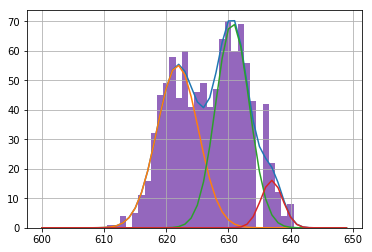

In [19]:
from scipy.stats import norm
import matplotlib.pyplot as plt

pdfs = [ norm(loc=params["mu_avg"][k], scale=np.sqrt(params["beta"][k]/params["alpha"][k])) for k in range(K) ]

xs = np.arange(600,650,1)
ys = [(pdfs[0].pdf(x)*pi[0]+pdfs[1].pdf(x)*pi[1]+pdfs[2].pdf(x)*pi[2])*len(lidar_data) for x in xs]
plt.plot(xs, ys)
for k in range(K):
    ys = [pdfs[k].pdf(x)*pi[k]*len(lidar_data) for x in xs]
    plt.plot(xs, ys)
lidar_data["lidar"].hist(bins = max(lidar_data["lidar"]) - min(lidar_data["lidar"]), align='left')
plt.show()